# Análise da comparação contexto e as palavras das sentenças do CohQuAD Init pt-br 

Realiza a análise da comparação das palavras das sentenças dos documentos originais com o contexto do conjunto de dados utilizando o arquivo:

- `comparacao_contexto_pX_kY.zip`

No nome do arquivo `comparacao_palavra_pX_kY.zip`, X é o número de documentos perturbados e Y o valor de top K predições. 





# 1 Preparação do ambiente

Preparação do ambiente para execução do script.

## 1.1 Tempo inicial de processamento

In [1]:
# Import das bibliotecas.
import time
import datetime

# Marca o tempo de início do processamento
inicio_processamento = time.time()

## 1.2 Funções e classes auxiliares

Verifica se existe o diretório cohebert no diretório corrente.   


In [2]:
# Import das bibliotecas.
import os # Biblioteca para manipular arquivos

# ============================  
def verificaDiretorioCoheBERT():
    """
      Verifica se existe o diretório cohebert no diretório corrente.    
    """
    
    # Verifica se o diretório existe
    if not os.path.exists(DIRETORIO_COHEBERT):  
        # Cria o diretório
        os.makedirs(DIRETORIO_COHEBERT)
        logging.info("Diretório Cohebert criado: {}".format(DIRETORIO_COHEBERT))
    
    return DIRETORIO_COHEBERT

Realiza o download e um arquivo

In [3]:
# Import das bibliotecas.
import requests # Biblioteca de download
from tqdm.notebook import tqdm as tqdm_notebook # Biblioteca para barra de progresso
import os # Biblioteca para manipular arquivos

def downloadArquivo(url_arquivo, nome_arquivo_destino):
    """    
      Realiza o download de um arquivo de uma url em salva em nome_arquivo_destino.
    
      Parâmetros:
        `url_arquivo` - URL do arquivo a ser feito download.      
        `nome_arquivo_destino` - Nome do arquivo a ser salvo.      
    """
    
    # Verifica se existe o diretório base
    DIRETORIO_COHEBERT = verificaDiretorioCoheBERT()
    
    # Realiza o download de um arquivo em uma url
    data = requests.get(url_arquivo, stream=True)
    
    # Verifica se o arquivo existe
    if data.status_code != 200:
        logging.info("Exceção ao tentar realizar download {}. Response {}.".format(url_arquivo, data.status_code))
        data.raise_for_status()
        return

    # Recupera o nome do arquivo a ser realizado o download    
    nome_arquivo = nome_arquivo_destino.split("/")[-1]  

    # Define o nome e caminho do arquivo temporário    
    nome_arquivo_temporario = DIRETORIO_COHEBERT + "/" + nome_arquivo + "_part"
    
    logging.info("Download do arquivo: {}.".format(nome_arquivo_destino))
    
    # Baixa o arquivo
    with open(nome_arquivo_temporario, "wb") as arquivo_binario:        
        tamanho_conteudo = data.headers.get("Content-Length")        
        total = int(tamanho_conteudo) if tamanho_conteudo is not None else None
        # Barra de progresso de download
        progresso_bar = tqdm_notebook(unit="B", total=total, unit_scale=True)                
        # Atualiza a barra de progresso
        for chunk in data.iter_content(chunk_size=1024):        
            if chunk:                
                progresso_bar.update(len(chunk))
                arquivo_binario.write(chunk)
    
    # Renomeia o arquivo temporário para o arquivo definitivo
    os.rename(nome_arquivo_temporario, nome_arquivo_destino)
    
    # Fecha a barra de progresso.
    progresso_bar.close()

Remove tags de um documento

In [4]:
def remove_tags(documento):
    """
      Remove tags de um documento
    """
    
    import re

    documento_limpo = re.compile("<.*?>")
    return re.sub(documento_limpo, "", documento)

Funções auxiliares de arquivos

In [5]:
def carregar(nome_arquivo, encoding="Windows-1252"):
    """
      Carrega um arquivo texto e retorna as linhas como um único parágrafo(texto).
    
      Parâmetros:
        `nome_arquivo` - Nome do arquivo a ser carregado.  
    """

    # Abre o arquivo
    arquivo = open(nome_arquivo, "r", encoding= encoding)
    
    paragrafo = ""
    for linha in arquivo:
        linha = linha.splitlines()
        linha = " ".join(linha)
        # Remove as tags existentes no final das linhas
        linha = remove_tags(linha)
        if linha != "":
          paragrafo = paragrafo + linha.strip() + " "
    
    # Fecha o arquivo
    arquivo.close()

    # Remove os espaços em branco antes e depois do parágrafo
    return paragrafo.strip()

In [6]:
def carregarLista(nome_arquivo, encoding="Windows-1252"):
    """
      Carrega um arquivo texto e retorna as linhas como uma lista de sentenças(texto).
    
      Parâmetros:
        `nome_arquivo` - Nome do arquivo a ser carregado.   
        `encoding` - Codificação dos caracteres do arquivo.
    """

    # Abre o arquivo
    arquivo = open(nome_arquivo, "r", encoding= encoding)
    
    sentencas = []
    for linha in arquivo:        
        linha = linha.splitlines()
        linha = " ".join(linha)
        linha = remove_tags(linha)
        if linha != "":
          sentencas.append(linha.strip())
    
    # Fecha o arquivo
    arquivo.close()

    return sentencas 

In [7]:
def salvar(nome_arquivo,texto):                       
    """
      Salva um texto em arquivo.
     
      Parâmetros:
        `nome_arquivo` - Nome do arquivo a ser salvo.
        `texto` - Texto a ser salvo.     
    """

    arquivo = open(nome_arquivo, "w")
    arquivo.write(str(texto))
    arquivo.close()

Função auxiliar para formatar o tempo como `hh: mm: ss`

In [8]:
# Import das bibliotecas.
import time
import datetime

def formataTempo(tempo):
    """
      Pega a tempo em segundos e retorna uma string hh:mm:ss
    """
    # Arredonda para o segundo mais próximo.
    tempo_arredondado = int(round((tempo)))
    
    # Formata como hh:mm:ss
    return str(datetime.timedelta(seconds=tempo_arredondado))    

Classe(ModelArguments) de definição dos parâmetros do modelo

In [9]:
# Import das bibliotecas.
from dataclasses import dataclass, field
from typing import Dict, Optional
from typing import List

@dataclass
class ModeloArgumentosMedida:
    max_seq_len: Optional[int] = field(
        default=None,
        metadata={"help": "max seq len"},
    )    
    pretrained_model_name_or_path: str = field(
        default="neuralmind/bert-base-portuguese-cased",
        metadata={"help": "nome do modelo pré-treinado do BERT."},
    )
    modelo_spacy: str = field(
        default="pt_core_news_lg",
        metadata={"help": "nome do modelo do spaCy."},
    )
    versao_modelo_spacy: str = field(
        default="-3.2.0",
        metadata={"help": "versão do nome do modelo no spaCy."},
    )
    sentenciar_documento: bool = field(
        default=True,
        metadata={"help": "Dividir o documento em sentenças(frases)."},
    )
    do_lower_case: bool = field(
        default=False,
        metadata={"help": "define se o texto do modelo deve ser todo em minúsculo."},
    )    
    output_attentions: bool = field(
        default=False,
        metadata={"help": "habilita se o modelo retorna os pesos de atenção."},
    )
    output_hidden_states: bool = field(
        default=False,
        metadata={"help": "habilita gerar as camadas ocultas do modelo."},
    )
    usar_mcl_ajustado : bool = field(
        default=False,
        metadata={"help": "habilita o carragamento de mcl ajustado."},
    )
    documentos_perturbados: int = field(
        default="1",
        metadata={"help": "Quantidade de documentos a serem perturbados a partir do original."},
    )
    top_k_predicao: int = field(
        default="100",
        metadata={"help": "Quantidade de palavras a serem recuperadas mais próximas da máscara."},
    )

Biblioteca de limpeza de tela


In [10]:
# Import das bibliotecas.
from IPython.display import clear_output

## 1.3 Tratamento de logs

In [11]:
# Import das bibliotecas.
import logging # Biblioteca de logging

# Formatando a mensagem de logging
logging.basicConfig(format="%(asctime)s : %(levelname)s : %(message)s")

logger = logging.getLogger()
logger.setLevel(logging.INFO)

## 1.4 Identificando o ambiente Colab

In [12]:
# Import das bibliotecas.
import sys # Biblioteca para acessar módulos do sistema

# Se estiver executando no Google Colaboratory
# Retorna true ou false se estiver no Google Colaboratory
IN_COLAB = "google.colab" in sys.modules

## 1.5 Colaboratory

Usando Colab GPU para Treinamento


Uma GPU pode ser adicionada acessando o menu e selecionando:

`Edit -> Notebook Settings -> Hardware accelerator -> (GPU)`

Em seguida, execute a célula a seguir para confirmar que a GPU foi detectada.

In [13]:
# Import das bibliotecas.
import tensorflow as tf

# Recupera o nome do dispositido da GPU.
device_name = tf.test.gpu_device_name()

# O nome do dispositivo deve ser parecido com o seguinte:
if device_name == "/device:GPU:0":
    logging.info("Encontrei GPU em: {}".format(device_name))
else:
    logging.info("Dispositivo GPU não encontrado")
    #raise SystemError("Dispositivo GPU não encontrado")

INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:root:Dispositivo GPU não encontrado


Nome da GPU

Para que a torch use a GPU, precisamos identificar e especificar a GPU como o dispositivo. Posteriormente, em nosso ciclo de treinamento, carregaremos dados no dispositivo.

Vale a pena observar qual GPU você recebeu. A GPU Tesla P100 é muito mais rápido que as outras GPUs, abaixo uma lista ordenada:
- 1o Tesla P100
- 2o Tesla T4
- 3o Tesla P4 (Não tem memória para execução 4 x 8, somente 2 x 4)
- 4o Tesla K80 (Não tem memória para execução 4 x 8, somente 2 x 4)

In [14]:
# Import das bibliotecas.
import torch # Biblioteca para manipular os tensores

def getDeviceGPU():
    """
    Retorna um dispositivo de GPU se disponível ou CPU.
    
    Retorno:
    `device` - Um device de GPU ou CPU.       
    """
        
    # Se existe GPU disponível.
    if torch.cuda.is_available():
        
        # Diz ao PyTorch para usar GPU.    
        device = torch.device("cuda")
        
        logging.info("Existem {} GPU(s) disponíveis.".format(torch.cuda.device_count()))
        logging.info("Iremos usar a GPU: {}.".format(torch.cuda.get_device_name(0)))

    # Se não.
    else:        
        logging.info("Sem GPU disponível, usando CPU.")
        device = torch.device("cpu")
        
    return device

In [15]:
device = getDeviceGPU()

INFO:root:Sem GPU disponível, usando CPU.


Conecta o modelo ao device

In [16]:
# Import das bibliotecas.
import torch # Biblioteca para manipular os tensores

def conectaGPU(model, device):
    """
      Conecta um modelo BERT a GPU.

      Parâmetros:
        `model` - Um modelo BERT carregado.       
        `device` - Um device de GPU.     
    
      Retorno:
        `model` - Um objeto model BERT conectado a GPU.     
    """
    # Associa a GPU ao modelo.
    model.to(device)

    # Se existe GPU disponível.
    if torch.cuda.is_available():    
        # Diga ao pytorch para rodar este modelo na GPU.
        logging.info("Pytorch rodando o modelo na GPU.")
        model.cuda()
        
    else:
        logging.info("Pytorch rodando sem GPU.")

    return model

Memória

Memória disponível no ambiente

In [17]:
# Import das bibliotecas.
from psutil import virtual_memory

ram_gb = virtual_memory().total / 1e9
logging.info("Seu ambiente de execução tem {: .1f} gigabytes de RAM disponível\n".format(ram_gb))

if ram_gb < 20:
  logging.info("Para habilitar um tempo de execução de RAM alta, selecione menu o ambiente de execução> \"Alterar tipo de tempo de execução\"")
  logging.info("e selecione High-RAM. Então, execute novamente está célula")
else:
  logging.info("Você está usando um ambiente de execução de memória RAM alta!")

INFO:root:Seu ambiente de execução tem  13.6 gigabytes de RAM disponível

INFO:root:Para habilitar um tempo de execução de RAM alta, selecione menu o ambiente de execução> "Alterar tipo de tempo de execução"
INFO:root:e selecione High-RAM. Então, execute novamente está célula


## 1.6 Monta uma pasta no google drive para carregar os arquivos de dados.

In [18]:
# Import das bibliotecas.
from google.colab import drive

# Monta o drive na pasta especificada
drive.mount("/content/drive")     

Mounted at /content/drive


## 1.7 Instalação do wandb

Instalação

In [19]:
!pip install --upgrade wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 2.2 MB/s 
     |████████████████████████████████| 162 kB 42.7 MB/s 
     |████████████████████████████████| 181 kB 49.2 MB/s 
     |████████████████████████████████| 63 kB 1.7 MB/s 
     |████████████████████████████████| 158 kB 46.3 MB/s 
     |████████████████████████████████| 157 kB 32.6 MB/s 
     |████████████████████████████████| 157 kB 40.3 MB/s 
     |████████████████████████████████| 157 kB 41.3 MB/s 
     |████████████████████████████████| 157 kB 47.5 MB/s 
     |████████████████████████████████| 157 kB 50.5 MB/s 
     |████████████████████████████████| 157 kB 50.9 MB/s 
     |████████████████████████████████| 157 kB 51.6 MB/s 
     |████████████████████████████████| 156 kB 47.0 MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=fe7224cd072ad736b7a1760a88fa84949d9f350c458924fc9452b2d9f1ca

# 2 Parametrização

## Gerais

In [20]:
# Definição dos parâmetros a serem avaliados
#Quantidade de documentos a serem perturbados a partir do original.
DOCUMENTOS_PERTURBADOS = 1 # Somente 1 para o Cohebert Manual

#Quantidade de palavras a serem recuperadas mais próximas da máscara.
TOP_K_PREDICAO = 1 # Somente 1 para o Cohebert Manual

## Específicos

In [21]:
# Definição dos parâmetros do Modelo.
model_args = ModeloArgumentosMedida(     
    max_seq_len = 512,    
    #pretrained_model_name_or_path = "https://neuralmind-ai.s3.us-east-2.amazonaws.com/nlp/bert-large-portuguese-cased/bert-large-portuguese-cased_pytorch_checkpoint.zip",
    #pretrained_model_name_or_path = "https://neuralmind-ai.s3.us-east-2.amazonaws.com/nlp/bert-base-portuguese-cased/bert-base-portuguese-cased_pytorch_checkpoint.zip",
    pretrained_model_name_or_path = "neuralmind/bert-large-portuguese-cased",
    #pretrained_model_name_or_path = "neuralmind/bert-base-portuguese-cased",    
    #pretrained_model_name_or_path = "bert-base-multilingual-cased",
    #pretrained_model_name_or_path = "bert-base-multilingual-uncased",
    modelo_spacy = "pt_core_news_lg",
    #modelo_spacy = "pt_core_news_md",
    #modelo_spacy = "pt_core_news_sm",
    versao_modelo_spacy = "3.2.0",
    sentenciar_documento = True,
    do_lower_case = False,   # default True  
    output_attentions = False,    # default False
    output_hidden_states = True, # default False, se True retorna todas as camadas do modelo para as operações de soma e concatenação
    usar_mcl_ajustado = False, # Especifica se deve ser carregado um MCL ajustado ou pré-treinado. Necessário especificar o tipo do modelo em pretrained_model_name_or_path. 
    documentos_perturbados = DOCUMENTOS_PERTURBADOS, # Quantidade de documentos a serem perturbados a partir do original.
    top_k_predicao = TOP_K_PREDICAO, # Conjunto de valores: 1, 10, 100, 500 e 1000. Quantidade de palavras a serem recuperadas mais próximas da máscara.
)

## Nome do diretório dos arquivos de dados

In [22]:
# Diretório do cohebert
DIRETORIO_COHEBERT = "COHQUAD_INIT_PTBR"

## Define o caminho para os arquivos de dados

In [23]:
# Diretório local para os arquivos pré-processados
DIRETORIO_LOCAL = "/content/" + DIRETORIO_COHEBERT + "/"

# Diretório no google drive com os arquivos pré-processados
DIRETORIO_DRIVE = "/content/drive/MyDrive/Colab Notebooks/Data/" + DIRETORIO_COHEBERT + "/"

## Configuração do tamanho da fonte dos gráficos

In [24]:
# Import das bibliotecas
import matplotlib

TAMANHO_FONTE = 16
matplotlib.rc("font", size=TAMANHO_FONTE)          # Controla o tamanho do do texto default
matplotlib.rc("axes", titlesize=TAMANHO_FONTE)     # Tamanho da fonte do eixo do título
matplotlib.rc("axes", labelsize=TAMANHO_FONTE)     # Tamanho da fonte dos rótulos do eixo x e y
matplotlib.rc("xtick", labelsize=TAMANHO_FONTE-2)    # Tamanho da fonte das marcações do eixo y
matplotlib.rc("ytick", labelsize=TAMANHO_FONTE)    # Tamanho da fonte dos marcações do eixo x
matplotlib.rc("legend", fontsize=TAMANHO_FONTE-2)  # Tamanho da fonte da legenda
matplotlib.rc("figure", titlesize=TAMANHO_FONTE)   # Tamanho da fonte do título da figura

# 3 Estatísticas comparação do contexto com as palavras



## 3.1 Carregamento dos arquivos de dados originais

### 3.1.1 Especifica os nomes dos arquivos de dados



In [25]:
# Nome do arquivo
NOME_ARQUIVO_ORIGINAL = "original.csv"
NOME_ARQUIVO_ORIGINAL_COMPACTADO = "original.zip"
NOME_ARQUIVO_ORIGINAL_POS = "originalpos.csv"
NOME_ARQUIVO_ORIGINAL_POS_COMPACTADO = "originalpos.zip"

NOME_ARQUIVO_PERTURBADO = "perturbado_p" + str(model_args.documentos_perturbados) + "_k" + str(model_args.top_k_predicao) + ".csv"
NOME_ARQUIVO_PERTURBADO_COMPACTADO = "perturbado_p" + str(model_args.documentos_perturbados) + "_k" + str(model_args.top_k_predicao) + ".zip"
NOME_ARQUIVO_PERTURBADO_POS = "perturbadopos_p" + str(model_args.documentos_perturbados) + "_k" + str(model_args.top_k_predicao) + ".csv"
NOME_ARQUIVO_PERTURBADO_POS_COMPACTADO = "perturbadopos_p" + str(model_args.documentos_perturbados) + "_k" + str(model_args.top_k_predicao) + ".zip"

### 3.1.2 Cria o diretório local para receber os dados

In [26]:
# Import das bibliotecas.
import os

# Cria o diretório para receber os arquivos Originais e Permutados
# Diretório a ser criado
dirbase = DIRETORIO_LOCAL[:-1]

if not os.path.exists(dirbase):  
    # Cria o diretório
    os.makedirs(dirbase)    
    logging.info("Diretório criado: {}".format(dirbase))
else:    
    logging.info("Diretório já existe: {}".format(dirbase))

INFO:root:Diretório criado: /content/COHQUAD_INIT_PTBR


### 3.1.3 Copia e descompacta os arquivos do Google Drive para o Colaboratory

In [27]:
# Se estiver executando no Google Colaboratory
if IN_COLAB:

  !cp "$DIRETORIO_DRIVE$NOME_ARQUIVO_ORIGINAL_COMPACTADO" "$DIRETORIO_LOCAL"
  !cp "$DIRETORIO_DRIVE$NOME_ARQUIVO_ORIGINAL_POS_COMPACTADO" "$DIRETORIO_LOCAL"

  !cp "$DIRETORIO_DRIVE$NOME_ARQUIVO_PERTURBADO_COMPACTADO" "$DIRETORIO_LOCAL"
  !cp "$DIRETORIO_DRIVE$NOME_ARQUIVO_PERTURBADO_POS_COMPACTADO" "$DIRETORIO_LOCAL"

  logging.info("Terminei a cópia!")

INFO:root:Terminei a cópia!


Descompacta os arquivos.

Usa o unzip para descompactar:
*   `-o` sobrescreve o arquivo se existir
*   `-j` Não cria nenhum diretório
*   `-q` Desliga as mensagens 
*   `-d` Diretório de destino


In [28]:
# Se estiver executando no Google Colaboratory
if IN_COLAB:
  !unzip -o -j -q "$DIRETORIO_LOCAL$NOME_ARQUIVO_ORIGINAL_COMPACTADO" -d "$DIRETORIO_LOCAL"
  !unzip -o -j -q "$DIRETORIO_LOCAL$NOME_ARQUIVO_ORIGINAL_POS_COMPACTADO" -d "$DIRETORIO_LOCAL"
  
  !unzip -o -j -q "$DIRETORIO_LOCAL$NOME_ARQUIVO_PERTURBADO_COMPACTADO" -d "$DIRETORIO_LOCAL"
  !unzip -o -j -q "$DIRETORIO_LOCAL$NOME_ARQUIVO_PERTURBADO_POS_COMPACTADO" -d "$DIRETORIO_LOCAL"

  logging.info("Terminei a descompactação!")

INFO:root:Terminei a descompactação!


### 3.1.4 Carregamento das lista com os dados dos arquivos originais

#### Carrega o arquivo dos dados originais e POS

In [29]:
#Biblioteca
import pandas as pd

# Abre o arquivo e retorna o DataFrame
lista_documentos_originais = pd.read_csv(DIRETORIO_LOCAL + NOME_ARQUIVO_ORIGINAL, sep=";", encoding="UTF-8")
lista_documentos_originais_pos = pd.read_csv(DIRETORIO_LOCAL + NOME_ARQUIVO_ORIGINAL_POS, sep=";", encoding="UTF-8")

logging.info("TERMINADO ORIGINAIS: {}.".format(len(lista_documentos_originais)))
logging.info("TERMINADO ORIGINAIS POS: {}.".format(len(lista_documentos_originais_pos)))

INFO:root:TERMINADO ORIGINAIS: 20.
INFO:root:TERMINADO ORIGINAIS POS: 20.


In [30]:
lista_documentos_originais.sample(5)

id                                          sentencas  \
7    8  ['Como desempilhar elementos em uma estrutura ...   
17  18  ['Como são implementadas as operações de enfil...   
19  20  ['Em uma fila a operação de enfileirar ocorre ...   
1    2      ['Como desenfileirar elementos em uma fila?']   
11  12  ['O que é uma pilha e como desempilhar um elem...   

                                            documento  
7   Como desempilhar elementos em uma estrutura de...  
17  Como são implementadas as operações de enfilei...  
19  Em uma fila a operação de enfileirar ocorre em...  
1           Como desenfileirar elementos em uma fila?  
11  O que é uma pilha e como desempilhar um elemen...

In [31]:
# Corrige os tipos dos dados da lista agrupada
tipos = {"id": str}

lista_documentos_originais = lista_documentos_originais.astype(tipos)

In [32]:
lista_documentos_originais_pos.sample(5)

id                                      pos_documento
5    6  [[['Como', 'empilhar', 'e', 'desempilhar', 'el...
15  16  [[['O', 'que', 'é', 'uma', 'fila', 'e', 'como'...
18  19  [[['Em', 'uma', 'pilha', 'a', 'operação', 'de'...
8    9  [[['O', 'que', 'é', 'uma', 'pilha', 'e', 'como...
12  13  [[['O', 'que', 'é', 'uma', 'fila', 'e', 'como'...

In [33]:
# Corrige os tipos dos dados da lista agrupada
tipos = {"id": str}

lista_documentos_originais_pos = lista_documentos_originais_pos.astype(tipos)

#### Corrigir os tipos de colunas dos dados originais e POS

Em dados originais:
- coluna 1 - `sentenças` carregadas do arquivo vem como string e não como lista.

Em dados originais pos:
- coluna 1 - `pos_documento` carregadas do arquivo vem como string e não como lista.

In [34]:
# Import das bibliotecas.
import ast # Biblioteca para conversão de string em lista

# Verifica se o tipo da coluna não é list e converte
lista_documentos_originais["sentencas"] = lista_documentos_originais["sentencas"].apply(lambda x: ast.literal_eval(x) if type(x)!=list else x)

lista_documentos_originais_pos["pos_documento"] = lista_documentos_originais_pos["pos_documento"].apply(lambda x: ast.literal_eval(x) if type(x)!=list else x)

logging.info("TERMINADO CORREÇÃO ORIGINAIS: {}.".format(len(lista_documentos_originais)))
logging.info("TERMINADO CORREÇÃO ORIGINAIS POS: {}.".format(len(lista_documentos_originais_pos)))

INFO:root:TERMINADO CORREÇÃO ORIGINAIS: 20.
INFO:root:TERMINADO CORREÇÃO ORIGINAIS POS: 20.


#### Criando dados indexados originais

In [35]:
# Expecifica o(s) campo(s) indexado(s) e faz uma cópia da lista indexada
lista_documentos_originais_indexado = lista_documentos_originais.set_index(["id"])
lista_documentos_originais_indexado.head()

sentencas  \
id                                                      
1            [Como enfileirar elementos em uma fila?]   
2         [Como desenfileirar elementos em uma fila?]   
3             [Como empilhar elementos em uma pilha?]   
4   [Como empilhar e desempilhar elementos em uma ...   
5   [Como empilhar elementos em uma estrutura de d...   

                                            documento  
id                                                     
1              Como enfileirar elementos em uma fila?  
2           Como desenfileirar elementos em uma fila?  
3               Como empilhar elementos em uma pilha?  
4   Como empilhar e desempilhar elementos em uma p...  
5   Como empilhar elementos em uma estrutura de da...

In [36]:
# Faz uma cópia da lista não indexada
lista_documentos_originais_pos_indexado = lista_documentos_originais_pos.copy()

# Expecifica o(s) campo(s) indexado(s) e faz uma cópia da lista indexada
lista_documentos_originais_pos_indexado.set_index(["id"])
lista_documentos_originais_pos_indexado.head()

id                                      pos_documento
0  1  [[[Como, enfileirar, elementos, em, uma, fila,...
1  2  [[[Como, desenfileirar, elementos, em, uma, fi...
2  3  [[[Como, empilhar, elementos, em, uma, pilha, ...
3  4  [[[Como, empilhar, e, desempilhar, elementos, ...
4  5  [[[Como, empilhar, elementos, em, uma, estrutu...

#### Carrega o arquivo dos dados perturbados e POS

In [37]:
# Abre o arquivo e retorna o DataFrame
lista_documentos_perturbados = pd.read_csv(DIRETORIO_LOCAL + NOME_ARQUIVO_PERTURBADO, sep=";", encoding="UTF-8")
lista_documentos_perturbados_pos = pd.read_csv(DIRETORIO_LOCAL + NOME_ARQUIVO_PERTURBADO_POS, sep=";", encoding="UTF-8")

logging.info("TERMINADO PERTURBADOS: {}.".format(len(lista_documentos_perturbados)))
logging.info("TERMINADO PERTURBADOS POS: {}.".format(len(lista_documentos_perturbados_pos)))

INFO:root:TERMINADO PERTURBADOS: 20.
INFO:root:TERMINADO PERTURBADOS POS: 20.


Alguns csv estão com os nomes das colunas errados

In [38]:
lista_documentos_perturbados = lista_documentos_perturbados.rename(columns={'documentoPerturbado': 'documento_perturbado'})

In [39]:
lista_documentos_perturbados.sample(5)

id                                         perturbado  \
18  19_pert_0  ['Em uma pilha a operação de enfileirar ocorre...   
19  20_pert_0  ['Em uma fila a operação de empilhar ocorre em...   
14  15_pert_0  ['O que é uma fila e como empilhar e desempilh...   
9   10_pert_0  ['O que é uma pilha e como enfileirar seu elem...   
2    3_pert_0          ['Como empilhar elementos em uma fila ?']   

                                 documento_perturbado  \
18  Em uma pilha a operação de enfileirar ocorre e...   
19  Em uma fila a operação de empilhar ocorre em q...   
14  O que é uma fila e como empilhar e desempilhar...   
9   O que é uma pilha e como enfileirar seu elemen...   
2               Como empilhar elementos em uma fila ?   

                                            sentencas  
18  [['Em uma pilha a operação de [MASK] ocorre em...  
19  [['Em uma fila a operação de [MASK] ocorre em ...  
14  [['O que é uma [MASK] e como empilhar e desemp...  
9   [['O que é uma [MASK] e como enfileirar seu el...  
2   [['Como empilhar elementos em uma [MASK] ?', '...

In [40]:
lista_documentos_perturbados_pos.sample(5)

id                                      pos_documento
5    6_pert_0  [[['Como', 'empilhar', 'e', 'desempilhar', 'el...
11  12_pert_0  [[['O', 'que', 'é', 'uma', 'fila', 'e', 'como'...
13  14_pert_0  [[['O', 'que', 'é', 'uma', 'fila', 'e', 'como'...
4    5_pert_0  [[['Como', 'empilhar', 'elementos', 'em', 'uma...
3    4_pert_0  [[['Como', 'empilhar', 'e', 'desempilhar', 'el...

#### Corrigir os tipos de colunas dos dados perturbados e POS

Em dados perturbados:
- coluna 1 - `perturbado` carregadas do arquivo vem como string e não como lista.
- coluna 3 - `sentencas` carregadas do arquivo vem como string e não como lista.

Em dados perturbados pos:
- coluna 1 - `pos_documento` carregadas do arquivo vem como string e não como lista.

In [41]:
# Import das bibliotecas.
import ast # Biblioteca para conversão de string em lista

# Verifica se o tipo da coluna não é list e converte
lista_documentos_perturbados["perturbado"] = lista_documentos_perturbados["perturbado"].apply(lambda x: ast.literal_eval(x) if type(x)!=list else x)
lista_documentos_perturbados["sentencas"] = lista_documentos_perturbados["sentencas"].apply(lambda x: ast.literal_eval(x) if type(x)!=list else x)

lista_documentos_perturbados_pos["pos_documento"] = lista_documentos_perturbados_pos["pos_documento"].apply(lambda x: ast.literal_eval(x) if type(x)!=list else x)

logging.info("TERMINADO CORREÇÃO PERTURBADO: {}.".format(len(lista_documentos_perturbados)))
logging.info("TERMINADO CORREÇÃO PERTURBADO POS: {}.".format(len(lista_documentos_perturbados_pos)))

INFO:root:TERMINADO CORREÇÃO PERTURBADO: 20.
INFO:root:TERMINADO CORREÇÃO PERTURBADO POS: 20.


#### Criando dados indexados perturbados

In [42]:
# Expecifica o(s) campo(s) indexado(s) e faz uma cópia da lista indexada
lista_documentos_perturbados_indexado = lista_documentos_perturbados.set_index(["id"])
lista_documentos_perturbados_indexado.head()

perturbado  \
id                                                            
1_pert_0         [Como enfileirar elementos em uma pilha ?]   
2_pert_0      [Como desenfileirar elementos em uma pilha ?]   
3_pert_0            [Como empilhar elementos em uma fila ?]   
4_pert_0  [Como empilhar e desempilhar elementos em uma ...   
5_pert_0  [Como empilhar elementos em uma estrutura de d...   

                                       documento_perturbado  \
id                                                            
1_pert_0          Como enfileirar elementos em uma pilha ?'   
2_pert_0       Como desenfileirar elementos em uma pilha ?'   
3_pert_0              Como empilhar elementos em uma fila ?   
4_pert_0  Como empilhar e desempilhar elementos em uma f...   
5_pert_0  Como empilhar elementos em uma estrutura de da...   

                                                  sentencas  
id                                                           
1_pert_0  [[Como enfileirar elementos em uma [MASK] ?, f...  
2_pert_0  [[Como desenfileirar elementos em uma [MASK] ?...  
3_pert_0  [[Como empilhar elementos em uma [MASK] ?, pil...  
4_pert_0  [[Como empilhar e desempilhar elementos em uma...  
5_pert_0  [[Como empilhar elementos em uma estrutura de ...

In [43]:
# Expecifica o(s) campo(s) indexado(s) e faz uma cópia da lista indexada
lista_documentos_perturbados_pos_indexado = lista_documentos_perturbados_pos.set_index(["id"])
lista_documentos_perturbados_pos_indexado.head()

pos_documento
id                                                         
1_pert_0  [[[Como, enfileirar, elementos, em, uma, pilha...
2_pert_0  [[[Como, desenfileirar, elementos, em, uma, pi...
3_pert_0  [[[Como, empilhar, elementos, em, uma, fila, ?...
4_pert_0  [[[Como, empilhar, e, desempilhar, elementos, ...
5_pert_0  [[[Como, empilhar, elementos, em, uma, estrutu...

### 3.1.5 Agrupar os dados originais e perturbados

In [44]:
# Import das bibliotecas.
import ast
from tqdm.notebook import tqdm as tqdm_notebook

def agruparDadosOriginaisPerturbados(lista_documentos_originais, lista_documentos_perturbados):
  print("Processando",len(lista_documentos_originais),"documentos originais")

  lista_documentos_agrupados = []

  # Barra de progresso dos documentos
  lista_documentos_originais_bar = tqdm_notebook(lista_documentos_originais.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_documentos_originais))

  # Percorre os documentos
  for i, linha_documento in lista_documentos_originais_bar: 
    #if i < 2:
      #print("linha_documento:",linha_documento)
      # Recupera o id do documento
      id_documento = linha_documento[0]     
      #print("id_documento:",id_documento)     
  
      # Carrega a lista das sentenças do documento
      lista_sentenca_documento = linha_documento[1]    
      #print("\nlista_sentenca_documento:",lista_sentenca_documento)
      #print("len(lista_sentenca_documento):",len(lista_sentenca_documento)) 

      # Adiciona o original a lista dos dados agrupados, considerando como coerente(1)
      lista_documentos_agrupados.append([id_documento, lista_sentenca_documento, linha_documento[2], 1])

      # Percorre os documentos perturbados apartir do original
      for j in range(0, model_args.documentos_perturbados):

        # Id do documento perturbado
        id_perturbado = str(id_documento) + "_pert_" + str(j)

        # localiza o documento perturbado de acordo com o tipo armazenado        
        # Os conjuntos de dados possuem diferentes formas de armazendo        
        documento_perturbado = lista_documentos_perturbados_indexado.loc[id_perturbado]
        # Recupera a sentença do documento perturbado
        lista_perturbado = documento_perturbado[0]
                      
        # Adiciona o perturbado a lista dos dados agrupados considerando como incoerente(0)
        lista_documentos_agrupados.append([id_perturbado, lista_perturbado, documento_perturbado[1], 0])    

  logging.info("TERMINADO AGRUPAMENTO: {}.".format(len(lista_documentos_agrupados)))

  # Cria o dataframe da lista
  lista_documentos_agrupados = pd.DataFrame(lista_documentos_agrupados, columns = ["id","sentencas","documento","classe"])

  # Corrige os tipos dos dados da lista agrupada
  tipos = {"id": str, "sentencas": object, "documento": str, "classe": int}

  lista_documentos_agrupados = lista_documentos_agrupados.astype(tipos)

  return lista_documentos_agrupados

In [45]:
# Importa das bibliotecas
import pandas as pd

print("Analisando documentos originais e perturbados")
# Concatena as listas de documentos originais e perturbados
lista_documentos_agrupados = agruparDadosOriginaisPerturbados(lista_documentos_originais, lista_documentos_perturbados)
lista_documentos_agrupados_pos = pd.concat([lista_documentos_originais_pos, lista_documentos_perturbados_pos])
# Corrige o tipo de dado da coluna id da lista
tipos = {"id": str}
lista_documentos_agrupados_pos = lista_documentos_agrupados_pos.astype(tipos)

Analisando documentos originais e perturbados
Processando 20 documentos originais


Documentos:   0%|          | 0/20 [00:00<?, ? documento/s]

INFO:root:TERMINADO AGRUPAMENTO: 40.


In [46]:
logging.info("TERMINADO AGRUPAMENTO: {}.".format(len(lista_documentos_agrupados)))

INFO:root:TERMINADO AGRUPAMENTO: 40.


In [47]:
lista_documentos_agrupados.sample(5)

id                                          sentencas  \
9    5_pert_0  [Como empilhar elementos em uma estrutura de d...   
29  15_pert_0  [O que é uma fila e como empilhar e desempilha...   
39  20_pert_0  [Em uma fila a operação de empilhar ocorre em ...   
28         15  [O que é uma pilha e como empilhar e desempilh...   
19  10_pert_0  [O que é uma pilha e como enfileirar seu eleme...   

                                            documento  classe  
9   Como empilhar elementos em uma estrutura de da...       0  
29  O que é uma fila e como empilhar e desempilhar...       0  
39  Em uma fila a operação de empilhar ocorre em q...       0  
28  O que é uma pilha e como empilhar e desempilha...       1  
19  O que é uma pilha e como enfileirar seu elemen...       0

In [48]:
logging.info("TERMINADO AGRUPAMENTO POS: {}.".format(len(lista_documentos_agrupados_pos)))

INFO:root:TERMINADO AGRUPAMENTO POS: 40.


In [49]:
lista_documentos_agrupados_pos.sample(5)

id                                      pos_documento
12  13_pert_0  [[[O, que, é, uma, pilha, e, como, enfileirar,...
5           6  [[[Como, empilhar, e, desempilhar, elementos, ...
5    6_pert_0  [[[Como, empilhar, e, desempilhar, elementos, ...
6    7_pert_0  [[[Como, desempilhar, elementos, em, uma, fila...
10         11  [[[O, que, é, uma, fila, e, como, desenfileira...

#### Criar dados indexados

In [50]:
# Expecifica o(s) campo(s) indexado(s) e faz uma cópia da lista indexada
lista_documentos_agrupados_indexado = lista_documentos_agrupados.set_index(["id"])
lista_documentos_agrupados_indexado.head()

sentencas  \
id                                                        
1              [Como enfileirar elementos em uma fila?]   
1_pert_0     [Como enfileirar elementos em uma pilha ?]   
2           [Como desenfileirar elementos em uma fila?]   
2_pert_0  [Como desenfileirar elementos em uma pilha ?]   
3               [Como empilhar elementos em uma pilha?]   

                                             documento  classe  
id                                                              
1               Como enfileirar elementos em uma fila?       1  
1_pert_0     Como enfileirar elementos em uma pilha ?'       0  
2            Como desenfileirar elementos em uma fila?       1  
2_pert_0  Como desenfileirar elementos em uma pilha ?'       0  
3                Como empilhar elementos em uma pilha?       1

In [51]:
# Expecifica o(s) campo(s) indexado(s) e faz uma cópia da lista indexada
lista_documentos_agrupados_pos_indexado = lista_documentos_agrupados_pos.set_index(["id"])
lista_documentos_agrupados_pos_indexado.head()

pos_documento
id                                                   
1   [[[Como, enfileirar, elementos, em, uma, fila,...
2   [[[Como, desenfileirar, elementos, em, uma, fi...
3   [[[Como, empilhar, elementos, em, uma, pilha, ...
4   [[[Como, empilhar, e, desempilhar, elementos, ...
5   [[[Como, empilhar, elementos, em, uma, estrutu...

## 3.2 Carregamento do arquivo de dado comparação palavra e contexto

### 3.2.1 Especifica os nomes dos arquivos de dados



In [52]:
# Nome do arquivo
NOME_ARQUIVO_COMPARACAO_CONTEXTO = "comparacao_contexto_p" + str(model_args.documentos_perturbados) + "_k" + str(model_args.top_k_predicao) + ".csv"
NOME_ARQUIVO_COMPARACAO_CONTEXTO_COMPACTADO = "comparacao_contexto_p" + str(model_args.documentos_perturbados) + "_k" + str(model_args.top_k_predicao) + ".zip"

### 3.2.2 Cria o diretório local para receber os dados

In [53]:
# Import das bibliotecas.
import os

# Cria o diretório para receber os arquivos Originais e Permutados
# Diretório a ser criado
dirbase = DIRETORIO_LOCAL[:-1]

if not os.path.exists(dirbase):  
    # Cria o diretório
    os.makedirs(dirbase)    
    logging.info("Diretório criado: {}".format(dirbase))
else:    
    logging.info("Diretório já existe: {}".format(dirbase))

INFO:root:Diretório já existe: /content/COHQUAD_INIT_PTBR


### 3.2.2 Copia e descompacta os arquivos do Google Drive para o Colaboratory

In [54]:
# Se estiver executando no Google Colaboratory
if IN_COLAB:

  # Copia o arquivo de comparações do google drive para a diretório local
  !cp "$DIRETORIO_DRIVE$NOME_ARQUIVO_COMPARACAO_CONTEXTO_COMPACTADO" "$DIRETORIO_LOCAL$NOME_ARQUIVO_COMPARACAO_CONTEXTO_COMPACTADO"
  
  logging.info("Terminei a cópia!")

INFO:root:Terminei a cópia!


Usa o unzip para descompactar:
*   `-o` sobrescreve o arquivo se existir
*   `-j` Não cria nenhum diretório
*   `-q` Desliga as mensagens 
*   `-d` Diretório de destino


In [55]:
# Se estiver executando no Google Colaboratory
if IN_COLAB:

  !unzip -o -j -q "$DIRETORIO_LOCAL$NOME_ARQUIVO_COMPARACAO_CONTEXTO_COMPACTADO" -d "$DIRETORIO_LOCAL"

  logging.info("Descompactação realizada!")

INFO:root:Descompactação realizada!


### 3.2.4 Carregamento das lista com os dados do arquivo


In [56]:
#Biblioteca
import pandas as pd

# Abre o arquivo e retorna o DataFrame
lista_comparacao_contexto = pd.read_csv(DIRETORIO_LOCAL + NOME_ARQUIVO_COMPARACAO_CONTEXTO, sep=";", encoding="UTF-8")

logging.info("TERMINADO ORIGINAIS: {}.".format(len(lista_comparacao_contexto))) 

INFO:root:TERMINADO ORIGINAIS: 434.


In [57]:
lista_comparacao_contexto.sample(5)

id  index_documento  index_sentenca  index_wi    wi  pos_i  \
116   7_pert_0               13               0         5  fila   NOUN   
424  20_pert_0               39               0         2  fila   NOUN   
427  20_pert_0               39               0         5    de  SCONJ   
335         17               32               0         5    de  SCONJ   
151   9_pert_0               17               0         2     é    AUX   

     cos_ctxall_mean  euc_ctxall_mean  man_ctxall_mean  cos_ctxclean_mean  \
116         0.883136        16.657347         783.6521           0.874366   
424         0.856606        18.835596         909.3941           0.831533   
427         0.813356        22.465139        1109.6619           0.745509   
335         0.820092        22.458151        1124.6453           0.760700   
151         0.796654        23.701113        1145.5101           0.674882   

     ...  man_ctxclean_max  cos_ctxverb_max  euc_ctxverb_max  man_ctxverb_max  \
116  ...         1085.3494              NaN              NaN              NaN   
424  ...         1255.7118         0.663506        31.349274      1497.855957   
427  ...         1269.6321         0.696749        29.254765      1417.013550   
335  ...         1249.3633         0.757224        25.599363      1277.883545   
151  ...         1409.1027         0.909460        16.408731       794.563599   

     cos_ctxnoun_max  euc_ctxnoun_max  man_ctxnoun_max  cos_ctxverbnoun_max  \
116         0.811116        22.931309        1055.1996             0.811116   
424         0.764928        26.228453        1236.4404             0.755595   
427         0.693051        29.375050        1394.2969             0.724601   
335         0.686739        29.770386        1411.2672             0.762948   
151         0.595899        34.436237        1590.4253             0.793995   

     euc_ctxverbnoun_max  man_ctxverbnoun_max  
116            22.931309            1055.1996  
424            26.441223            1254.6250  
427            27.447060            1315.8416  
335            25.326080            1246.5264  
151            23.935080            1116.2770  

[5 rows x 36 columns]

Remove as pontuações

In [58]:
#lista_comparacao_contexto = lista_comparacao_contexto.query('pos_i != "PUNCT"')

In [59]:
lista_comparacao_contexto.sample(5)

id  index_documento  index_sentenca  index_wi         wi  pos_i  \
53   4_pert_0                7               0         2          e  CCONJ   
330        17               32               0         0       Como    ADV   
14          2                2               0         0       Como  SCONJ   
393        19               36               0         7     ocorre   VERB   
113  7_pert_0               13               0         2  elementos   NOUN   

     cos_ctxall_mean  euc_ctxall_mean  man_ctxall_mean  cos_ctxclean_mean  \
53          0.842823        20.350563        1002.0845           0.803573   
330         0.784933        23.906082        1173.9200           0.751763   
14          0.803080        23.166096        1145.0505           0.770033   
393         0.790395        27.961323        1317.3953           0.833435   
113         0.815306        28.221014        1213.1974           0.876753   

     ...  man_ctxclean_max  cos_ctxverb_max  euc_ctxverb_max  man_ctxverb_max  \
53   ...         1114.2432         0.765371        25.051250      1233.899536   
330  ...         1243.7852         0.756762        25.344782      1253.738037   
14   ...         1224.0259         0.702624        28.857546      1419.631348   
393  ...         1197.0410         0.926212        18.062258       858.401611   
113  ...         1035.7546              NaN              NaN              NaN   

     cos_ctxnoun_max  euc_ctxnoun_max  man_ctxnoun_max  cos_ctxverbnoun_max  \
53          0.692470        29.070448       1416.21690             0.766613   
330         0.647137        31.337414       1501.19900             0.743586   
14          0.665063        31.364069       1510.84230             0.703620   
393         0.721341        31.714905       1505.72300             0.840248   
113         0.907212        21.403572        917.07837             0.907212   

     euc_ctxverbnoun_max  man_ctxverbnoun_max  
53             24.743538           1218.26390  
330            25.981497           1271.77640  
14             28.808561           1397.34390  
393            24.731537           1176.74580  
113            21.403572            917.07837  

[5 rows x 36 columns]

### 3.2.5 Criando dados indexados

In [60]:
# Expecifica o(s) campo(s) indexado(s) e faz uma cópia da lista indexada
lista_comparacao_contexto_indexado = lista_comparacao_contexto.set_index(["id", "index_sentenca", "index_wi", "pos_i"])
lista_comparacao_contexto_indexado.head()

index_documento          wi  \
id index_sentenca index_wi pos_i                                
1  0              0        SCONJ                0        Como   
                  1        VERB                 0  enfileirar   
                  2        NOUN                 0   elementos   
                  3        ADP                  0          em   
                  4        DET                  0         uma   

                                  cos_ctxall_mean  euc_ctxall_mean  \
id index_sentenca index_wi pos_i                                     
1  0              0        SCONJ         0.828282        21.519108   
                  1        VERB          0.957184        10.615781   
                  2        NOUN          0.803867        26.599089   
                  3        ADP           0.871055        20.539906   
                  4        DET           0.840564        20.068256   

                                  man_ctxall_mean  cos_ctxclean_mean  \
id index_sentenca index_wi pos_i                                       
1  0              0        SCONJ       1075.54500           0.795338   
                  1        VERB         524.86475           0.923698   
                  2        NOUN        1214.86870           0.868563   
                  3        ADP          985.52810           0.828741   
                  4        DET          958.67487           0.787430   

                                  euc_ctxclean_mean  man_ctxclean_mean  \
id index_sentenca index_wi pos_i                                         
1  0              0        SCONJ          23.453634         1157.05810   
                  1        VERB           13.929336          681.58167   
                  2        NOUN           22.597616         1028.90060   
                  3        ADP            23.203224         1111.17330   
                  4        DET            23.178740         1096.64480   

                                  cos_ctxverb_mean  euc_ctxverb_mean  ...  \
id index_sentenca index_wi pos_i                                      ...   
1  0              0        SCONJ          0.759586         25.941952  ...   
                  1        VERB           1.000000          0.000000  ...   
                  2        NOUN           0.740469         30.121443  ...   
                  3        ADP            0.796027         25.312115  ...   
                  4        DET            0.744569         26.130171  ...   

                                  man_ctxclean_max  cos_ctxverb_max  \
id index_sentenca index_wi pos_i                                      
1  0              0        SCONJ         1157.0581         0.759586   
                  1        VERB          1131.7803         0.888775   
                  2        NOUN          1028.9006         0.740469   
                  3        ADP           1111.1733         0.796027   
                  4        DET           1096.6448         0.744569   

                                  euc_ctxverb_max  man_ctxverb_max  \
id index_sentenca index_wi pos_i                                     
1  0              0        SCONJ        25.941952      1294.481323   
                  1        VERB         18.006966       972.863525   
                  2        NOUN         30.121443      1415.033447   
                  3        ADP          25.312115      1248.880005   
                  4        DET          26.130171      1257.120117   

                                  cos_ctxnoun_max  euc_ctxnoun_max  \
id index_sentenca index_wi pos_i                                     
1  0              0        SCONJ         0.680192        29.916761   
                  1        VERB          0.740781        27.314680   
                  2        NOUN          0.927326        17.372259   
                  3        ADP           0.801385        24.997398   
                  4        DET           0.727426        27.010202   

                                  man_ctxno

## 3.3 Estatísticas

### Colunas medidas discrepantes

In [61]:
coluna_discrepancia_cos = "min"
coluna_discrepancia_euc = "max"
coluna_discrepancia_man = "max"

### Contexto com todas as palavras(ctxall)

#### Estatísticas das medidas do contexto de todas palavras e as palavras

In [62]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("precision", 6)

# Exibe as estatísticas
lista_comparacao_contexto[["cos_ctxall_mean", 
                           "euc_ctxall_mean", 
                           "man_ctxall_mean", 
                           "cos_ctxall_max", 
                           "euc_ctxall_max",  
                           "man_ctxall_max"]].describe(include=["float", "int"]).apply(lambda s: s.apply("{0:.6f}".format))

cos_ctxall_mean euc_ctxall_mean man_ctxall_mean cos_ctxall_max  \
count      434.000000      434.000000      434.000000     434.000000   
mean         0.809036       22.545367     1079.184534       0.786949   
std          0.097198        4.498635      181.745434       0.089885   
min          0.182750       10.615781      523.811300       0.182750   
25%          0.784972       20.726692     1012.812490       0.769888   
50%          0.816715       22.453432     1096.618300       0.804781   
75%          0.842142       24.581079     1176.546525       0.825233   
max          0.957184       39.752243     1487.845600       0.886525   

      euc_ctxall_max man_ctxall_max  
count     434.000000     434.000000  
mean       24.282320    1166.985796  
std         3.396215     130.971497  
min        18.772223     912.539200  
25%        21.772604    1075.217200  
50%        23.406943    1144.820650  
75%        26.267326    1248.383550  
max        39.752243    1618.837900

#### Estatísticas das maiores discrepâncias por documento

In [63]:
discrepancias  = lista_comparacao_contexto.groupby("id").agg({"cos_ctxall_mean": [coluna_discrepancia_cos], 
                                                              "euc_ctxall_mean": [coluna_discrepancia_euc], 
                                                              "man_ctxall_mean": [coluna_discrepancia_man],
                                                              "cos_ctxall_max": [coluna_discrepancia_cos], 
                                                              "euc_ctxall_max": [coluna_discrepancia_euc], 
                                                              "man_ctxall_max": [coluna_discrepancia_man],
                                                              })

In [64]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("precision", 6)

# Exibe as estatísticas
discrepancias.describe(include=["float", "int"]) 

cos_ctxall_mean euc_ctxall_mean man_ctxall_mean cos_ctxall_max  \
                  min             max             max            min   
count       40.000000       40.000000       40.000000      40.000000   
mean         0.657735       29.664500     1305.912337       0.647649   
std          0.224970        4.335892       96.668731       0.219793   
min          0.182750       22.376444     1097.784000       0.182750   
25%          0.704094       26.948939     1227.728350       0.704094   
50%          0.757791       28.816320     1323.366600       0.735958   
75%          0.793656       33.262492     1367.839650       0.773799   
max          0.818847       39.752243     1487.845600       0.818847   

      euc_ctxall_max man_ctxall_max  
                 max            max  
count      40.000000      40.000000  
mean       29.982401    1376.767492  
std         4.060685     131.399981  
min        22.487411    1106.853500  
25%        27.394031    1308.196725  
50%        29.059809    1363.276650  
75%        33.262492    1428.278750  
max        39.752243    1618.837900

#### Top 20 palavras com mais ocorrências das sentenças dos documentos

In [65]:
# Import das bibliotecas
from tqdm.notebook import tqdm as tqdm_notebook
from collections import Counter

# Barra de progresso dos documentos
lista_documentos_pos_bar = tqdm_notebook(lista_documentos_agrupados_pos.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_documentos_agrupados_pos))

# Contador das palavras
contador = Counter()

# Percorre os documentos
for i, linha_documento_pos in lista_documentos_pos_bar:  
     
    # Carrega a lista das sentenças do documento 
    lista_sentenca_documento = linha_documento_pos[1]

    # Percorre as sentenças pos do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
        #print(sentenca[0])       
        # Carrega a lista dos tokens das sentenças
        for k, palavra in enumerate(sentenca[0]):
            contador[palavra] += 1 

Documentos:   0%|          | 0/40 [00:00<?, ? documento/s]

In [66]:
top = 20
# Lista as ocorrências das palavras
for i, item in enumerate(sorted(contador, key = contador.get, reverse=True)):
  if i < top:
    print (i+1, item, contador[item])     

1 uma 40
2 ? 40
3 e 28
4 elementos 24
5 em 24
6 Como 20
7 fila 20
8 pilha 20
9 empilhar 18
10 O 16
11 que 16
12 é 16
13 como 16
14 desempilhar 14
15 de 14
16 enfileirar 12
17 elemento 12
18 desenfileirar 8
19 um 8
20 nela 8


### Contexto com palavras menos stopswords (ctxclean)

#### Estatísticas das medidas do contexto de todas palavras sen stopwords e as palavras

In [67]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("precision", 6)

# Exibe as estatísticas
lista_comparacao_contexto[["cos_ctxclean_mean",   
                           "euc_ctxclean_mean", 
                           "man_ctxclean_mean",   
                           "cos_ctxclean_max", 
                           "euc_ctxclean_max",    
                           "man_ctxclean_max"]].describe(include=["float", "int"]).apply(lambda s: s.apply("{0:.6f}".format))

cos_ctxclean_mean euc_ctxclean_mean man_ctxclean_mean cos_ctxclean_max  \
count        434.000000        434.000000        434.000000       434.000000   
mean           0.784257         23.907486       1136.257946         0.762148   
std            0.111525          4.523539        194.450014         0.105426   
min            0.152244         13.852944        672.883540         0.152244   
25%            0.751316         21.299966       1024.947675         0.736898   
50%            0.805256         23.652821       1147.549550         0.778704   
75%            0.847642         25.793607       1236.004825         0.826447   
max            0.923698         37.613647       1694.084700         0.880125   

      euc_ctxclean_max man_ctxclean_max  
count       434.000000       434.000000  
mean         25.553831      1218.704918  
std           3.686188       160.215061  
min          18.806923       853.086200  
25%          23.036346      1113.624450  
50%          24.970947      1194.814200  
75%          27.289695      1307.499925  
max          37.613647      1694.084700

#### Estatísticas das maiores discrepâncias por documento

In [68]:
discrepancias  = lista_comparacao_contexto.groupby("id").agg({"cos_ctxclean_mean": [coluna_discrepancia_cos], 
                                                              "euc_ctxclean_mean": [coluna_discrepancia_euc], 
                                                              "man_ctxclean_mean": [coluna_discrepancia_man],
                                                              "cos_ctxclean_max": [coluna_discrepancia_cos], 
                                                              "euc_ctxclean_max": [coluna_discrepancia_euc], 
                                                              "man_ctxclean_max": [coluna_discrepancia_man],
                                                              })

In [69]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("precision", 6)

# Exibe as estatísticas
discrepancias.describe(include=["float", "int"]) 

cos_ctxclean_mean euc_ctxclean_mean man_ctxclean_mean cos_ctxclean_max  \
                    min               max               max              min   
count         40.000000         40.000000         40.000000        40.000000   
mean           0.594294         31.147932       1405.218618         0.580597   
std            0.224860          5.027179        202.691441         0.215511   
min            0.152244         23.255230       1148.335900         0.152244   
25%            0.570445         25.413631       1225.848050         0.570445   
50%            0.666036         33.176476       1318.379800         0.642935   
75%            0.769218         35.357911       1628.840175         0.739503   
max            0.793976         37.613647       1694.084700         0.793976   

      euc_ctxclean_max man_ctxclean_max  
                   max              max  
count        40.000000        40.000000  
mean         31.809858      1492.037193  
std           4.426734       169.031648  
min          23.255230      1148.335900  
25%          27.915929      1355.303075  
50%          33.176476      1563.544050  
75%          35.357911      1636.930475  
max          37.613647      1694.084700

#### Top 20 palavras com mais ocorrências das sentenças dos documentos

In [70]:
# Import das bibliotecas
from tqdm.notebook import tqdm as tqdm_notebook
from collections import Counter

# Barra de progresso dos documentos
lista_documentos_pos_bar = tqdm_notebook(lista_documentos_agrupados_pos.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_documentos_agrupados_pos))

# Contador das palavras
contador = Counter()

# Percorre os documentos
for i, linha_documento_pos in lista_documentos_pos_bar:  
     
    # Carrega a lista das sentenças do documento 
    lista_sentenca_documento = linha_documento_pos[1]

    # Percorre as sentenças pos do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
        #print(sentenca[0])       
        # Carrega a lista dos tokens das sentenças
        for k, palavra in enumerate(sentenca[0]):
            contador[palavra] += 1 

Documentos:   0%|          | 0/40 [00:00<?, ? documento/s]

In [71]:
top = 20
# Lista as ocorrências das palavras
for i, item in enumerate(sorted(contador, key = contador.get, reverse=True)):
  if i < top:
    print (i+1, item, contador[item])     

1 uma 40
2 ? 40
3 e 28
4 elementos 24
5 em 24
6 Como 20
7 fila 20
8 pilha 20
9 empilhar 18
10 O 16
11 que 16
12 é 16
13 como 16
14 desempilhar 14
15 de 14
16 enfileirar 12
17 elemento 12
18 desenfileirar 8
19 um 8
20 nela 8


### Contexto com palavras da classe VERB(ctxverb)

#### Estatísticas das medidas do contexto de palavras da classe VERB e as palavras

In [72]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("precision", 6)

# Exibe as estatísticas
lista_comparacao_contexto[["cos_ctxverb_mean",  
                           "euc_ctxverb_mean", 
                           "man_ctxverb_mean",  
                           "cos_ctxverb_max", 
                           "euc_ctxverb_max",   
                           "man_ctxverb_max"]].describe(include=["float", "int"]).apply(lambda s: s.apply("{0:.6f}".format))

cos_ctxverb_mean euc_ctxverb_mean man_ctxverb_mean cos_ctxverb_max  \
count       400.000000       400.000000       400.000000      400.000000   
mean          0.733458        26.401851      1269.694131        0.712948   
std           0.130248         7.606234       347.742879        0.117730   
min           0.102380         0.000000         0.000000        0.102380   
25%           0.691360        24.990921      1223.450165        0.678993   
50%           0.733142        27.363439      1343.094482        0.723459   
75%           0.771328        30.296926      1456.679169        0.761683   
max           1.000000        46.616928      1988.902832        1.000000   

      euc_ctxverb_max man_ctxverb_max  
count      400.000000      400.000000  
mean        28.180100     1361.569711  
std          5.748429      251.646705  
min          0.000000        0.000000  
25%         25.745354     1278.155640  
50%         27.960430     1365.575439  
75%         30.814656     1483.296814  
max         46.616928     1988.902832

#### Estatísticas das maiores discrepâncias por documento

In [73]:
discrepancias  = lista_comparacao_contexto.groupby("id").agg({"cos_ctxverb_mean": [coluna_discrepancia_cos], 
                                                              "euc_ctxverb_mean": [coluna_discrepancia_euc], 
                                                              "man_ctxverb_mean": [coluna_discrepancia_man],
                                                              "cos_ctxverb_max": [coluna_discrepancia_cos], 
                                                              "euc_ctxverb_max": [coluna_discrepancia_euc], 
                                                              "man_ctxverb_max": [coluna_discrepancia_man],
                                                              })

In [74]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("precision", 6)

# Exibe as estatísticas
discrepancias.describe(include=["float", "int"]) 

cos_ctxverb_mean euc_ctxverb_mean man_ctxverb_mean cos_ctxverb_max  \
                   min              max              max             min   
count        36.000000        36.000000        36.000000       36.000000   
mean          0.529710        35.606256      1586.399221        0.529488   
std           0.218297         4.791689       149.835398        0.218113   
min           0.102380        29.043142      1415.033447        0.102380   
25%           0.494615        31.823001      1495.183105        0.494615   
50%           0.644732        34.142000      1558.789612        0.644732   
75%           0.668861        38.603108      1601.347046        0.668861   
max           0.731978        46.616928      1988.902832        0.724857   

      euc_ctxverb_max man_ctxverb_max  
                  max             max  
count       36.000000       36.000000  
mean        35.712137     1622.939487  
std          4.713499      154.375455  
min         29.043142     1415.033447  
25%         32.083431     1530.970795  
50%         34.157574     1575.293884  
75%         38.603108     1687.175537  
max         46.616928     1988.902832

#### Top 20 palavras com mais ocorrências das sentenças dos documentos

In [75]:
# Import das bibliotecas.
from tqdm.notebook import tqdm as tqdm_notebook
from collections import Counter

# Barra de progresso dos documentos
lista_documentos_pos_bar = tqdm_notebook(lista_documentos_agrupados_pos.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_documentos_agrupados_pos))

# Contador das palavras
contador = Counter()

# Percorre os documentos
for i, linha_documento_pos in lista_documentos_pos_bar:  
     
    # Carrega a lista das sentenças do documento
    lista_sentenca_documento = linha_documento_pos[1]    

    # Percorre as sentenças pos do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
        #print(sentenca[0])       
        # Carrega a lista dos tokens das sentenças
        for k, palavra in enumerate(sentenca[0]):
            contador[palavra] += 1

Documentos:   0%|          | 0/40 [00:00<?, ? documento/s]

In [76]:
top = 20
# Lista as ocorrências das palavras
for i, item in enumerate(sorted(contador, key = contador.get, reverse=True)):
  if i < top:
    print (i+1, item, contador[item]) 

1 uma 40
2 ? 40
3 e 28
4 elementos 24
5 em 24
6 Como 20
7 fila 20
8 pilha 20
9 empilhar 18
10 O 16
11 que 16
12 é 16
13 como 16
14 desempilhar 14
15 de 14
16 enfileirar 12
17 elemento 12
18 desenfileirar 8
19 um 8
20 nela 8


### Contexto com palavras da classe NOUN(ctxnoun)

#### Estatísticas das medidas do contexto de palavras da classe NOUN e as palavras

In [77]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("precision", 6)

# Exibe as estatísticas
lista_comparacao_contexto[["cos_ctxnoun_mean",  
                           "euc_ctxnoun_mean", 
                           "man_ctxnoun_mean",  
                           "cos_ctxnoun_max", 
                           "euc_ctxnoun_max",   
                           "man_ctxnoun_max"]].describe(include=["float", "int"]).apply(lambda s: s.apply("{0:.6f}".format))

cos_ctxnoun_mean euc_ctxnoun_mean man_ctxnoun_mean cos_ctxnoun_max  \
count       434.000000       434.000000       434.000000      434.000000   
mean          0.725902        27.295900      1281.832050        0.705413   
std           0.138156         6.326536       294.433708        0.136051   
min           0.147500        14.569006       697.053340        0.147500   
25%           0.650279        21.664404      1023.520670        0.628455   
50%           0.726938        28.133000      1318.147700        0.690586   
75%           0.839177        31.694495      1507.857500        0.806419   
max           0.938791        41.862366      1930.248700        0.938791   

      euc_ctxnoun_max man_ctxnoun_max  
count      434.000000      434.000000  
mean        28.697973     1351.410877  
std          6.105160      285.668437  
min         15.253929      712.051200  
25%         24.145485     1163.928300  
50%         29.854590     1405.890950  
75%         32.940389     1550.109050  
max         41.862366     1930.248700

#### Estatísticas das maiores discrepâncias por documento

In [78]:
discrepancias  = lista_comparacao_contexto.groupby("id").agg({"cos_ctxnoun_mean": [coluna_discrepancia_cos], 
                                                              "euc_ctxnoun_mean": [coluna_discrepancia_euc], 
                                                              "man_ctxnoun_mean": [coluna_discrepancia_man],
                                                              "cos_ctxnoun_max": [coluna_discrepancia_cos], 
                                                              "euc_ctxnoun_max": [coluna_discrepancia_euc], 
                                                              "man_ctxnoun_max": [coluna_discrepancia_man],
                                                              })

In [79]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("precision", 6)

# Exibe as estatísticas
discrepancias.describe(include=["float", "int"]) 

cos_ctxnoun_mean euc_ctxnoun_mean man_ctxnoun_mean cos_ctxnoun_max  \
                   min              max              max             min   
count        40.000000        40.000000        40.000000       40.000000   
mean          0.521358        35.092841      1622.730977        0.513430   
std           0.190297         4.290098       178.520674        0.185298   
min           0.147500        28.253685      1341.220700        0.147500   
25%           0.487709        31.318983      1479.507150        0.487709   
50%           0.576175        35.293068      1556.513750        0.558396   
75%           0.663105        39.096666      1791.237975        0.658687   
max           0.727795        41.862366      1930.248700        0.708185   

      euc_ctxnoun_max man_ctxnoun_max  
                  max             max  
count       40.000000       40.000000  
mean        35.643927     1678.809470  
std          4.048011      171.364275  
min         28.253685     1376.661300  
25%         32.253902     1509.812275  
50%         36.499985     1747.730000  
75%         39.096666     1812.595850  
max         41.862366     1930.248700

#### Top 20 palavras com mais ocorrências das sentenças dos documentos

In [80]:
# Import das bibliotecas.
import ast
from tqdm.notebook import tqdm as tqdm_notebook
from collections import Counter

# Barra de progresso dos documentos
lista_documentos_pos_bar = tqdm_notebook(lista_documentos_agrupados_pos.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_documentos_agrupados_pos))

# Contador das palavras
contador = Counter()

# Percorre os documentos
for i, linha_documento_pos in lista_documentos_pos_bar:  
     
    # Carrega a lista das sentenças do documento
    lista_sentenca_documento = linha_documento_pos[1]

    # Percorre as sentenças pos do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
        #print(sentenca[0])       
        # Carrega a lista dos tokens das sentenças
        for k, palavra in enumerate(sentenca[0]):
            contador[palavra] += 1

Documentos:   0%|          | 0/40 [00:00<?, ? documento/s]

In [81]:
top = 20
# Lista as ocorrências das palavras
for i, item in enumerate(sorted(contador, key = contador.get, reverse=True)):
  if i < top:
    print (i+1, item, contador[item])     

1 uma 40
2 ? 40
3 e 28
4 elementos 24
5 em 24
6 Como 20
7 fila 20
8 pilha 20
9 empilhar 18
10 O 16
11 que 16
12 é 16
13 como 16
14 desempilhar 14
15 de 14
16 enfileirar 12
17 elemento 12
18 desenfileirar 8
19 um 8
20 nela 8


### Contexto com palavras da classe VERB(AUX) e NOUN(ctxverbnoun)

#### Estatísticas das medidas do contexto de palavras da classe VERB(AUX) e NOUN e as palavras

In [82]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("precision", 6)

# Exibe as estatísticas
lista_comparacao_contexto[["cos_ctxverbnoun_mean",  
                           "euc_ctxverbnoun_mean", 
                           "man_ctxverbnoun_mean",  
                           "cos_ctxverbnoun_max", 
                           "euc_ctxverbnoun_max",   
                           "man_ctxverbnoun_max"]].describe(include=["float", "int"]).apply(lambda s: s.apply("{0:.6f}".format))

cos_ctxverbnoun_mean euc_ctxverbnoun_mean man_ctxverbnoun_mean  \
count           434.000000           434.000000           434.000000   
mean              0.776572            24.362522          1158.727311   
std               0.112074             4.538284           206.959266   
min               0.135959            13.450160           655.001040   
25%               0.727206            21.498970          1019.978270   
50%               0.790383            24.612207          1168.372300   
75%               0.849129            27.394274          1339.489400   
max               0.926419            38.309658          1563.725700   

      cos_ctxverbnoun_max euc_ctxverbnoun_max man_ctxverbnoun_max  
count          434.000000          434.000000          434.000000  
mean             0.754915           25.972212         1239.890828  
std              0.105817            3.690693          170.277563  
min              0.135959           16.810907          770.116940  
25%              0.715690           23.314416         1118.110075  
50%              0.764626           25.974965         1243.392750  
75%              0.818144           28.002842         1358.202000  
max              0.909825           38.309658         1714.956900

#### Estatísticas das maiores discrepâncias por documento

In [83]:
discrepancias  = lista_comparacao_contexto.groupby("id").agg({"cos_ctxverbnoun_mean": [coluna_discrepancia_cos], 
                                                              "euc_ctxverbnoun_mean": [coluna_discrepancia_euc], 
                                                              "man_ctxverbnoun_mean": [coluna_discrepancia_man],
                                                              "cos_ctxverbnoun_max": [coluna_discrepancia_cos], 
                                                              "euc_ctxverbnoun_max": [coluna_discrepancia_euc], 
                                                              "man_ctxverbnoun_max": [coluna_discrepancia_man],
                                                              })

In [84]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("precision", 6)

# Exibe as estatísticas
discrepancias.describe(include=["float", "int"]) 

cos_ctxverbnoun_mean euc_ctxverbnoun_mean man_ctxverbnoun_mean  \
                       min                  max                  max   
count            40.000000            40.000000            40.000000   
mean              0.580322            31.659366          1442.921150   
std               0.210877             3.466590            81.414432   
min               0.135959            26.951654          1308.319500   
25%               0.640118            28.534584          1382.706100   
50%               0.667194            30.929829          1440.613450   
75%               0.705958            33.674283          1516.205500   
max               0.733323            38.309658          1563.725700   

      cos_ctxverbnoun_max euc_ctxverbnoun_max man_ctxverbnoun_max  
                      min                 max                 max  
count           40.000000           40.000000           40.000000  
mean             0.578739           31.773817         1493.641680  
std              0.209895            3.410445          103.473003  
min              0.135959           26.951654         1323.588600  
25%              0.640118           28.926237         1398.117675  
50%              0.667194           30.975864         1487.188400  
75%              0.704155           33.674283         1554.762350  
max              0.733323           38.309658         1714.956900

#### Top 20 palavras com mais ocorrências das sentenças dos documentos

In [85]:
# Import das bibliotecas.
import ast
from tqdm.notebook import tqdm as tqdm_notebook
from collections import Counter

# Barra de progresso dos documentos
lista_documentos_pos_bar = tqdm_notebook(lista_documentos_agrupados_pos.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_documentos_agrupados_pos))

# Contador das palavras
contador = Counter()

# Percorre os documentos
for i, linha_documento_pos in lista_documentos_pos_bar:  
     
    # Carrega a lista das sentenças do documento
    lista_sentenca_documento = linha_documento_pos[1]
 
    # Percorre as sentenças pos do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
        #print(sentenca[0])       
        # Carrega a lista dos tokens das sentenças
        for k, palavra in enumerate(sentenca[0]):
            contador[palavra] += 1        

Documentos:   0%|          | 0/40 [00:00<?, ? documento/s]

In [86]:
top = 20
# Lista as ocorrências das palavras
for i, item in enumerate(sorted(contador, key = contador.get, reverse=True)):
  if i < top:
    print (i+1, item, contador[item])     

1 uma 40
2 ? 40
3 e 28
4 elementos 24
5 em 24
6 Como 20
7 fila 20
8 pilha 20
9 empilhar 18
10 O 16
11 que 16
12 é 16
13 como 16
14 desempilhar 14
15 de 14
16 enfileirar 12
17 elemento 12
18 desenfileirar 8
19 um 8
20 nela 8


## 3.4 Estatísticas das discrepâncias por classe moforsintática

### Contexto com todas as palavras(ctxall)

In [87]:
equacao_medida = "ctxall"

#### COS

In [88]:
medida = "cos"

##### MEAN

In [89]:
estrategia_medida = "mean"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [90]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#      avg      std      min      25%      50%      75%  \
pos_i                                                                    
ADP    38.000000 0.845908 0.025136 0.793402 0.822422 0.847361 0.870101   
ADV    21.000000 0.836123 0.043762 0.777958 0.814247 0.831315 0.846457   
AUX    20.000000 0.786507 0.021490 0.740130 0.768821 0.795822 0.801880   
CCONJ  28.000000 0.629235 0.277532 0.182750 0.301053 0.807689 0.822601   
DET    69.000000 0.832156 0.025575 0.773076 0.813052 0.832849 0.848491   
NOUN  108.000000 0.808041 0.047006 0.733532 0.768442 0.805519 0.833498   
PRON   41.000000 0.764260 0.043435 0.680702 0.734872 0.768771 0.800467   
PUNCT  40.000000 0.804190 0.022491 0.769617 0.781444 0.808499 0.824862   
SCONJ  23.000000 0.817368 0.015520 0.785305 0.808897 0.813262 0.829782   
VERB   46.000000 0.893063 0.053817 0.775444 0.879507 0.907349 0.926397   

           max  
pos_i           
ADP   0.886525  
ADV   0.916235  
AUX   0.818966  
CCONJ 0.842823  
DET   0.894961  
NOUN  0.944496  
PRON  0.837515  
PUNCT 0.833986  
SCONJ 0.843328  
VERB  0.957184

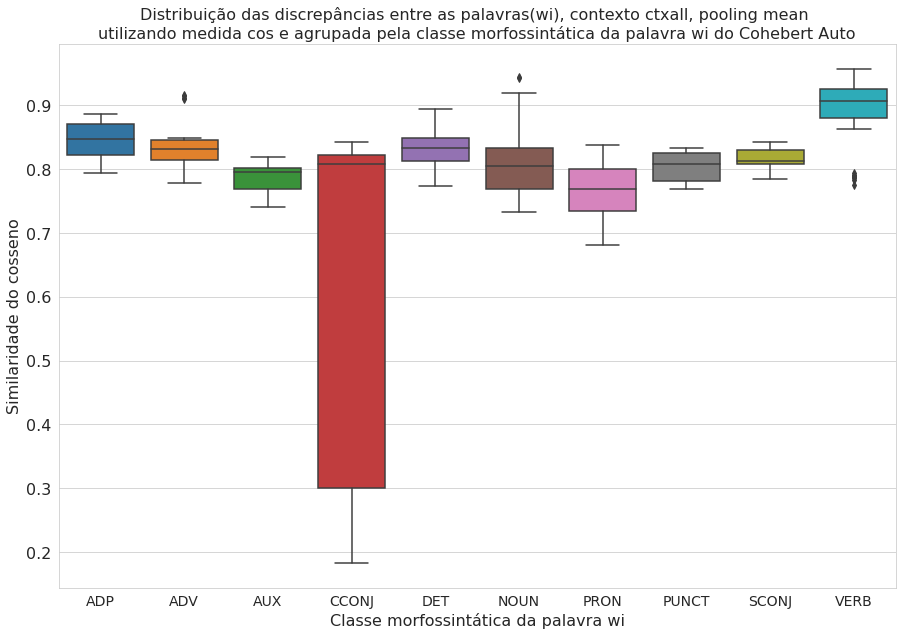

In [91]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# lista_cm = lista_comparacao_palavra[lista_comparacao_palavra['id'].str.contains("_pert_")]

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do Cohebert Auto")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Similaridade do cosseno")

# Mostra o gráfico
plt.show()

##### MAX

In [92]:
estrategia_medida = "max"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [93]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#      avg      std      min      25%      50%      75%  \
pos_i                                                                    
ADP    38.000000 0.845908 0.025136 0.793402 0.822422 0.847361 0.870101   
ADV    21.000000 0.802179 0.041186 0.704228 0.783480 0.814402 0.835591   
AUX    20.000000 0.786507 0.021490 0.740130 0.768821 0.795822 0.801880   
CCONJ  28.000000 0.629235 0.277532 0.182750 0.301053 0.807689 0.822601   
DET    69.000000 0.826101 0.033816 0.683828 0.811882 0.828691 0.844617   
NOUN  108.000000 0.783477 0.029948 0.686115 0.762020 0.780524 0.810559   
PRON   41.000000 0.764260 0.043435 0.680702 0.734872 0.768771 0.800467   
PUNCT  40.000000 0.804190 0.022491 0.769617 0.781444 0.808499 0.824862   
SCONJ  23.000000 0.817368 0.015520 0.785305 0.808897 0.813262 0.829782   
VERB   46.000000 0.766929 0.038060 0.668772 0.737689 0.768354 0.790019   

           max  
pos_i           
ADP   0.886525  
ADV   0.849103  
AUX   0.818966  
CCONJ 0.842823  
DET   0.877737  
NOUN  0.850094  
PRON  0.837515  
PUNCT 0.833986  
SCONJ 0.843328  
VERB  0.849577

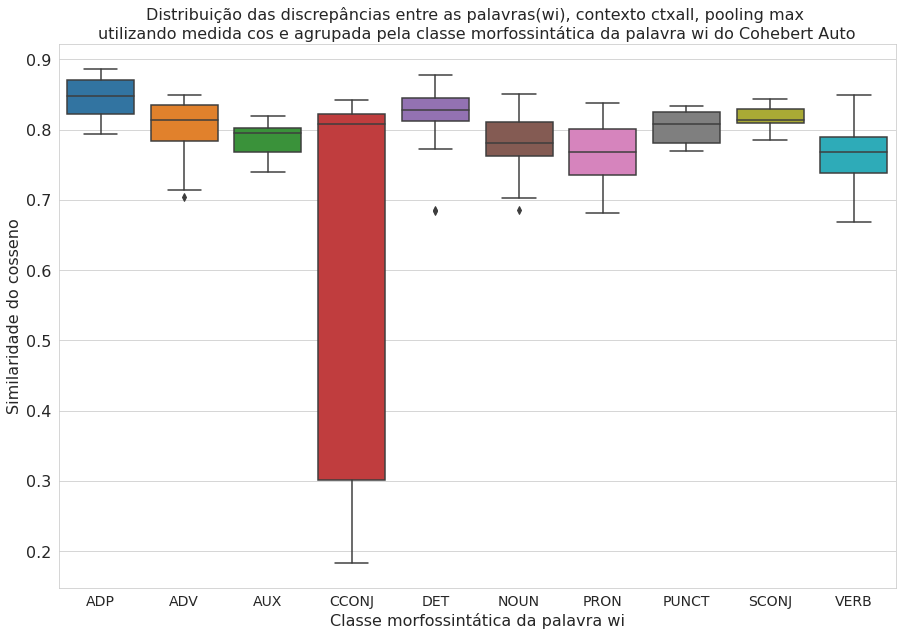

In [94]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do Cohebert Auto")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Similaridade do cosseno")

# Mostra o gráfico
plt.show()

#### EUC

In [95]:
medida = "euc"

##### MEAN

In [96]:
estrategia_medida = "mean"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [97]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#       avg      std       min       25%       50%       75%  \
pos_i                                                                         
ADP    38.000000 21.691650 1.489567 19.008547 20.577126 21.651995 22.719337   
ADV    21.000000 21.162814 3.470777 13.972829 21.180754 22.304878 23.237909   
AUX    20.000000 24.337399 1.378587 22.282555 23.193683 24.122701 25.659601   
CCONJ  28.000000 25.786528 5.898550 20.350563 21.405265 22.434255 32.133887   
DET    69.000000 21.122099 1.755902 15.686503 20.160477 21.172958 21.925825   
NOUN  108.000000 24.261539 4.978141 11.953954 21.326224 24.944664 27.752695   
PRON   41.000000 25.619960 2.794676 20.718315 22.742056 26.399078 27.781313   
PUNCT  40.000000 22.828830 1.222262 21.220879 21.631236 22.510685 24.067448   
SCONJ  23.000000 22.395247 0.951308 20.562014 21.619356 22.514669 23.080832   
VERB   46.000000 16.323555 5.069324 10.615781 13.399829 14.850517 16.606049   

            max  
pos_i            
ADP   24.394371  
ADV   24.068378  
AUX   27.113714  
CCONJ 35.117470  
DET   25.874020  
NOUN  39.752243  
PRON  29.922977  
PUNCT 24.774311  
SCONJ 24.168806  
VERB  28.985649

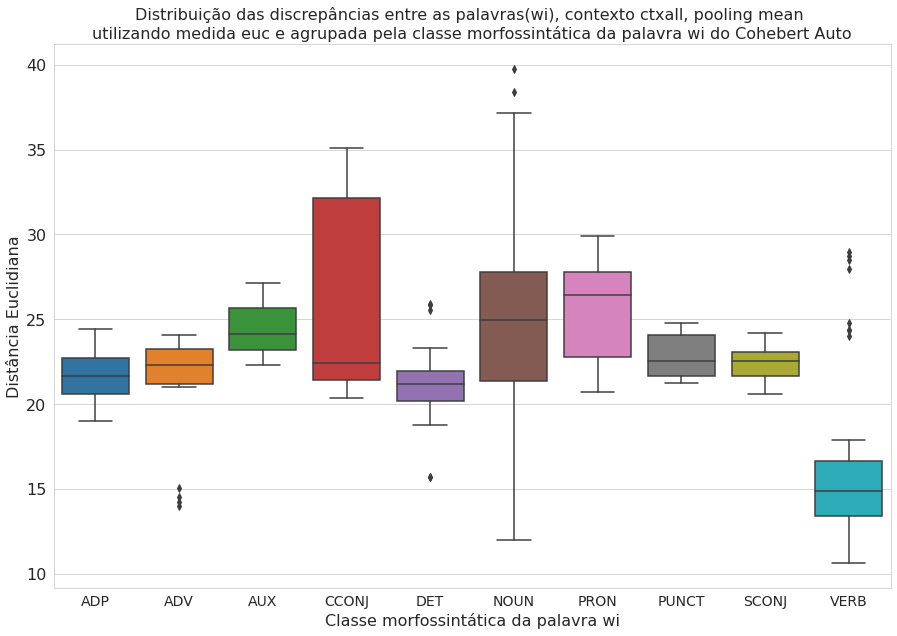

In [98]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do Cohebert Auto")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Distância Euclidiana")

# Mostra o gráfico
plt.show()

##### MAX

In [99]:
estrategia_medida = "max"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [100]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#       avg      std       min       25%       50%       75%  \
pos_i                                                                         
ADP    38.000000 21.691650 1.489567 19.008547 20.577126 21.651995 22.719337   
ADV    21.000000 23.907119 2.753884 21.013828 21.977333 23.206358 23.998495   
AUX    20.000000 24.337399 1.378587 22.282555 23.193683 24.122701 25.659601   
CCONJ  28.000000 25.786528 5.898550 20.350563 21.405265 22.434255 32.133887   
DET    69.000000 21.579689 2.272414 18.772223 20.399004 21.317518 22.127378   
NOUN  108.000000 26.174660 3.248101 20.534048 24.302133 25.659441 27.995468   
PRON   41.000000 25.619960 2.794676 20.718315 22.742056 26.399078 27.781313   
PUNCT  40.000000 22.828830 1.222262 21.220879 21.631236 22.510685 24.067448   
SCONJ  23.000000 22.395247 0.951308 20.562014 21.619356 22.514669 23.080832   
VERB   46.000000 26.280428 2.489502 20.644423 24.632038 26.440045 28.099047   

            max  
pos_i            
ADP   24.394371  
ADV   31.091808  
AUX   27.113714  
CCONJ 35.117470  
DET   31.684525  
NOUN  39.752243  
PRON  29.922977  
PUNCT 24.774311  
SCONJ 24.168806  
VERB  31.910425

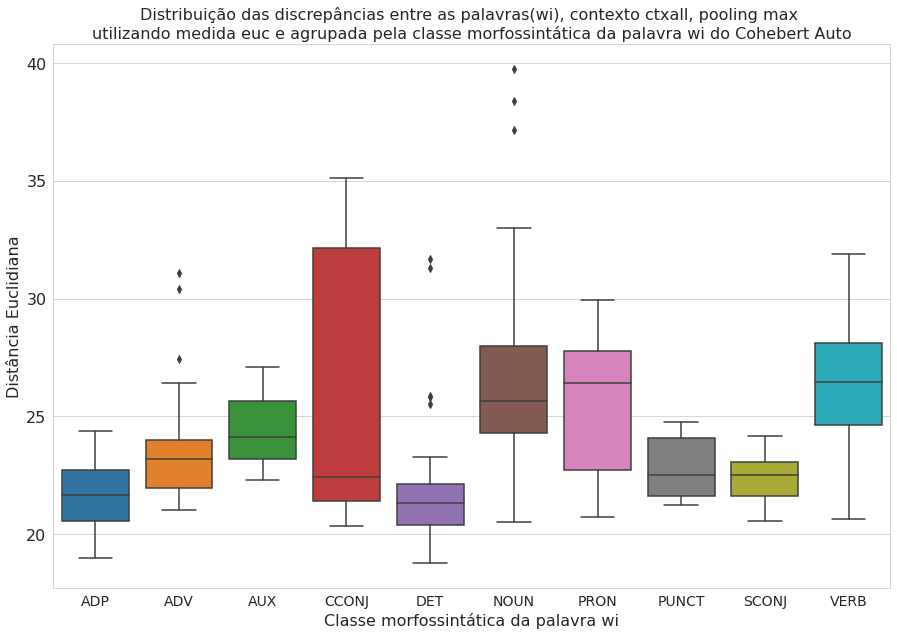

In [101]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do Cohebert Auto")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Distância Euclidiana")

# Mostra o gráfico
plt.show()

#### MAN

In [102]:
medida = "man"

##### MEAN

In [103]:
estrategia_medida = "mean"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [104]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#         avg        std         min         25%         50%  \
pos_i                                                                         
ADP    38.000000 1065.605941  73.249725  935.226560 1003.339540 1072.829500   
ADV    21.000000 1052.290038 179.978724  677.845700 1063.417200 1120.675900   
AUX    20.000000 1173.566475  72.449699 1066.291000 1115.926925 1171.931650   
CCONJ  28.000000 1091.581055  42.944734 1002.084500 1063.073400 1089.489200   
DET    69.000000 1042.500604  87.153921  775.046400  996.437740 1036.430200   
NOUN  108.000000 1116.128691 185.761908  583.641850 1011.632858 1146.856650   
PRON   41.000000 1253.822302 147.446395 1010.179140 1093.783800 1303.820600   
PUNCT  40.000000 1142.257617  56.969247 1062.032500 1084.644600 1129.906400   
SCONJ  23.000000 1116.748165  48.311196 1022.931300 1082.179250 1124.645300   
VERB   46.000000  793.102282 230.874340  523.811300  650.498055  728.308000   

              75%         max  
pos_i                          
ADP   1125.281750 1175.586200  
ADV   1166.670800 1184.586400  
AUX   1229.501475 1325.552600  
CCONJ 1120.418125 1189.468300  
DET   1084.345000 1272.510000  
NOUN  1268.933250 1403.067900  
PRON  1363.713900 1487.845600  
PUNCT 1196.361850 1232.014900  
SCONJ 1148.211350 1209.377000  
VERB   826.157740 1354.712900

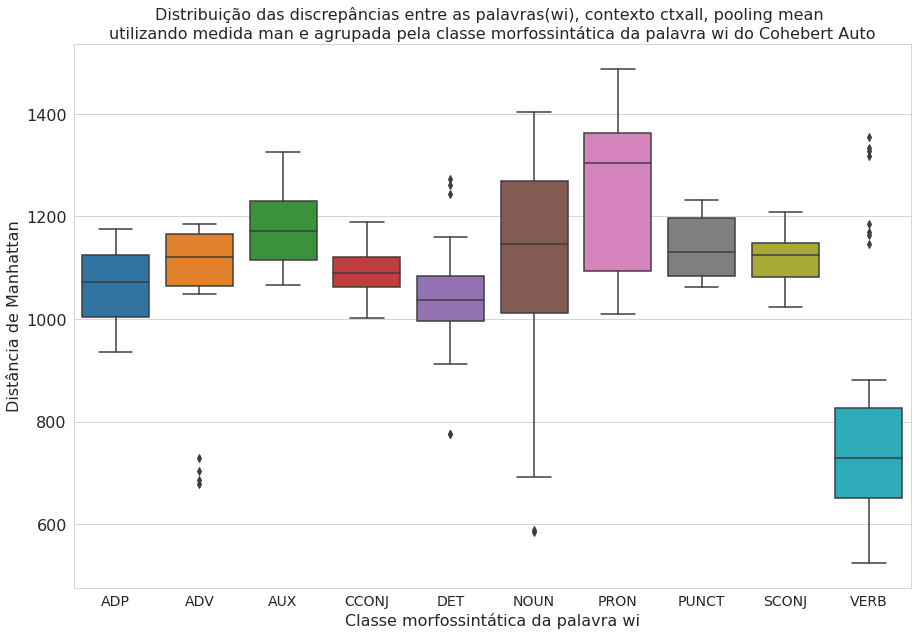

In [105]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do Cohebert Auto")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Distância de Manhattan")

# Mostra o gráfico
plt.show()

##### MAX

In [106]:
estrategia_medida = "max"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [107]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#         avg        std         min         25%         50%  \
pos_i                                                                         
ADP    38.000000 1065.605941  73.249725  935.226560 1003.339540 1072.829500   
ADV    21.000000 1197.282386 145.462234 1048.727800 1107.436800 1165.386800   
AUX    20.000000 1173.566475  72.449699 1066.291000 1115.926925 1171.931650   
CCONJ  28.000000 1091.581055  42.944734 1002.084500 1063.073400 1089.489200   
DET    69.000000 1066.052831 116.969820  912.539200  999.381960 1042.982500   
NOUN  108.000000 1212.967062 114.397284  970.301760 1136.752075 1215.953450   
PRON   41.000000 1253.822302 147.446395 1010.179140 1093.783800 1303.820600   
PUNCT  40.000000 1142.257617  56.969247 1062.032500 1084.644600 1129.906400   
SCONJ  23.000000 1116.748165  48.311196 1022.931300 1082.179250 1124.645300   
VERB   46.000000 1292.607948 121.039702 1050.928200 1211.493425 1297.671200   

              75%         max  
pos_i                          
ADP   1125.281750 1175.586200  
ADV   1176.791500 1590.133500  
AUX   1229.501475 1325.552600  
CCONJ 1120.418125 1189.468300  
DET   1086.110400 1595.537000  
NOUN  1294.611450 1593.325400  
PRON  1363.713900 1487.845600  
PUNCT 1196.361850 1232.014900  
SCONJ 1148.211350 1209.377000  
VERB  1357.816175 1618.837900

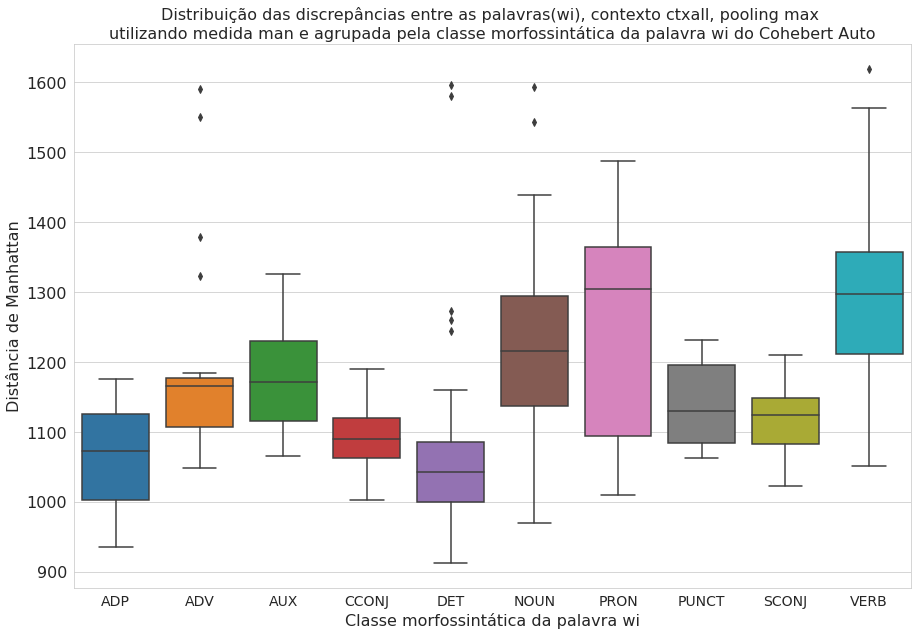

In [108]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do Cohebert Auto")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Distância de Manhattan")

# Mostra o gráfico
plt.show()

### Contexto com todas as palavras sem as stopwords(ctxclean)

In [109]:
equacao_medida = "ctxclean"

#### COS

In [110]:
medida = "cos"

##### MEAN

In [111]:
estrategia_medida = "mean"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [112]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#      avg      std      min      25%      50%      75%  \
pos_i                                                                    
ADP    38.000000 0.801191 0.030361 0.739848 0.780990 0.795348 0.828549   
ADV    21.000000 0.769679 0.062159 0.706584 0.740352 0.750635 0.756444   
AUX    20.000000 0.690854 0.039933 0.634680 0.667439 0.680731 0.695487   
CCONJ  28.000000 0.565933 0.264616 0.152244 0.229227 0.730838 0.746588   
DET    69.000000 0.782446 0.035532 0.708935 0.758504 0.779263 0.803759   
NOUN  108.000000 0.852564 0.019892 0.805090 0.839714 0.853680 0.867455   
PRON   41.000000 0.687556 0.095084 0.556671 0.595298 0.698176 0.715604   
PUNCT  40.000000 0.804486 0.025896 0.747703 0.792621 0.807371 0.821825   
SCONJ  23.000000 0.766879 0.022251 0.725334 0.747159 0.768946 0.786135   
VERB   46.000000 0.870055 0.034174 0.795053 0.844776 0.878028 0.898603   

           max  
pos_i           
ADP   0.849757  
ADV   0.900794  
AUX   0.769836  
CCONJ 0.803573  
DET   0.872022  
NOUN  0.910874  
PRON  0.865051  
PUNCT 0.850599  
SCONJ 0.796185  
VERB  0.923698

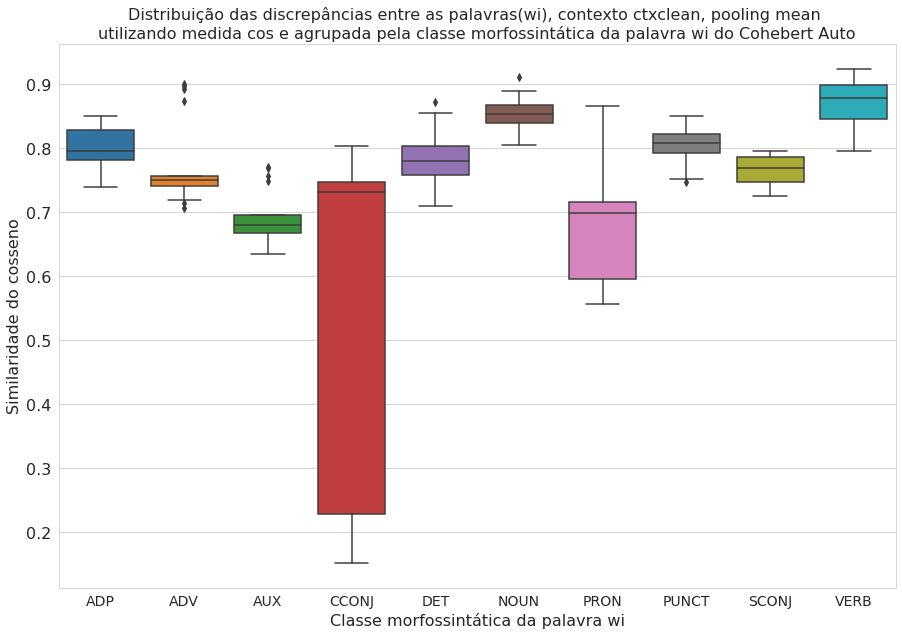

In [113]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do Cohebert Auto")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Similaridade do cosseno")

# Mostra o gráfico
plt.show()

##### MAX

In [114]:
estrategia_medida = "max"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [115]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#      avg      std      min      25%      50%      75%  \
pos_i                                                                    
ADP    38.000000 0.801191 0.030361 0.739848 0.780990 0.795348 0.828549   
ADV    21.000000 0.735243 0.020459 0.683934 0.719068 0.741565 0.751659   
AUX    20.000000 0.690854 0.039933 0.634680 0.667439 0.680731 0.695487   
CCONJ  28.000000 0.565933 0.264616 0.152244 0.229227 0.730838 0.746588   
DET    69.000000 0.776559 0.038356 0.653005 0.756632 0.775935 0.801362   
NOUN  108.000000 0.827833 0.042814 0.666820 0.805339 0.843952 0.856499   
PRON   41.000000 0.687556 0.095084 0.556671 0.595298 0.698176 0.715604   
PUNCT  40.000000 0.804486 0.025896 0.747703 0.792621 0.807371 0.821825   
SCONJ  23.000000 0.766879 0.022251 0.725334 0.747159 0.768946 0.786135   
VERB   46.000000 0.744079 0.048538 0.644451 0.708674 0.743577 0.772792   

           max  
pos_i           
ADP   0.849757  
ADV   0.756588  
AUX   0.769836  
CCONJ 0.803573  
DET   0.845130  
NOUN  0.880125  
PRON  0.865051  
PUNCT 0.850599  
SCONJ 0.796185  
VERB  0.848258

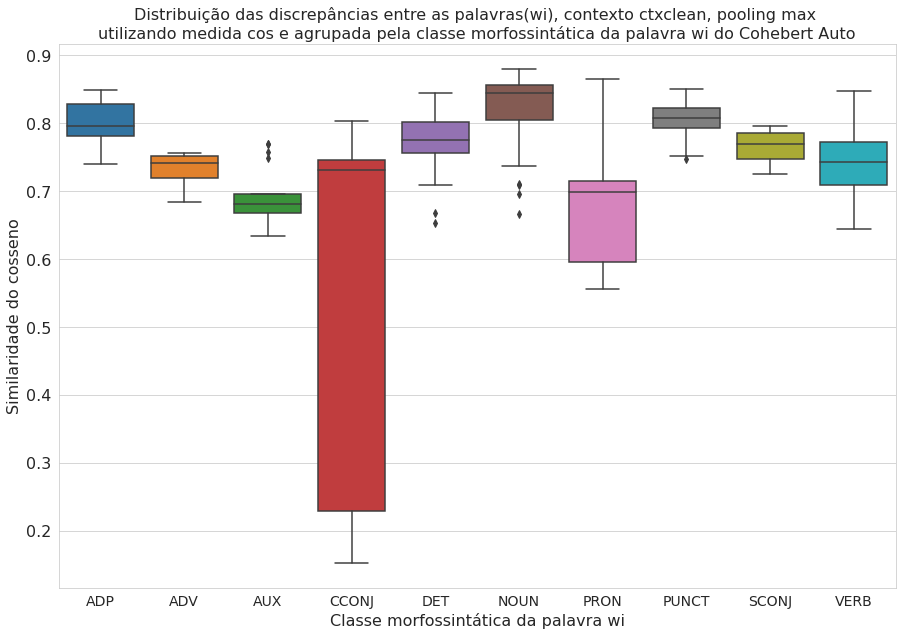

In [116]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do Cohebert Auto")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Similaridade do cosseno")

# Mostra o gráfico
plt.show()

#### EUC

In [117]:
medida = "euc"

##### MEAN

In [118]:
estrategia_medida = "mean"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [119]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#       avg      std       min       25%       50%       75%  \
pos_i                                                                         
ADP    38.000000 24.298352 1.618593 21.629093 22.912230 24.437131 25.463767   
ADV    21.000000 24.808533 4.464759 14.893313 25.234367 26.589516 27.097080   
AUX    20.000000 29.082397 2.329410 24.275120 29.066267 29.666791 30.692336   
CCONJ  28.000000 29.316342 5.316154 22.630600 25.689705 26.462142 35.857723   
DET    69.000000 23.949554 2.033719 17.187716 22.788029 23.962721 24.874620   
NOUN  108.000000 21.743624 3.313682 15.049207 19.931090 21.173715 23.309369   
PRON   41.000000 29.203888 4.458891 21.658165 27.272602 28.533382 33.483074   
PUNCT  40.000000 22.903812 1.470251 19.877274 21.957900 22.802380 23.720039   
SCONJ  23.000000 25.144396 1.391629 23.255230 23.837234 25.004234 26.332709   
VERB   46.000000 18.181810 3.343464 13.852944 15.953062 17.146815 19.578509   

            max  
pos_i            
ADP   27.604006  
ADV   29.052565  
AUX   31.915607  
CCONJ 37.613647  
DET   28.699699  
NOUN  35.812756  
PRON  35.610611  
PUNCT 25.787270  
SCONJ 27.629211  
VERB  25.889809

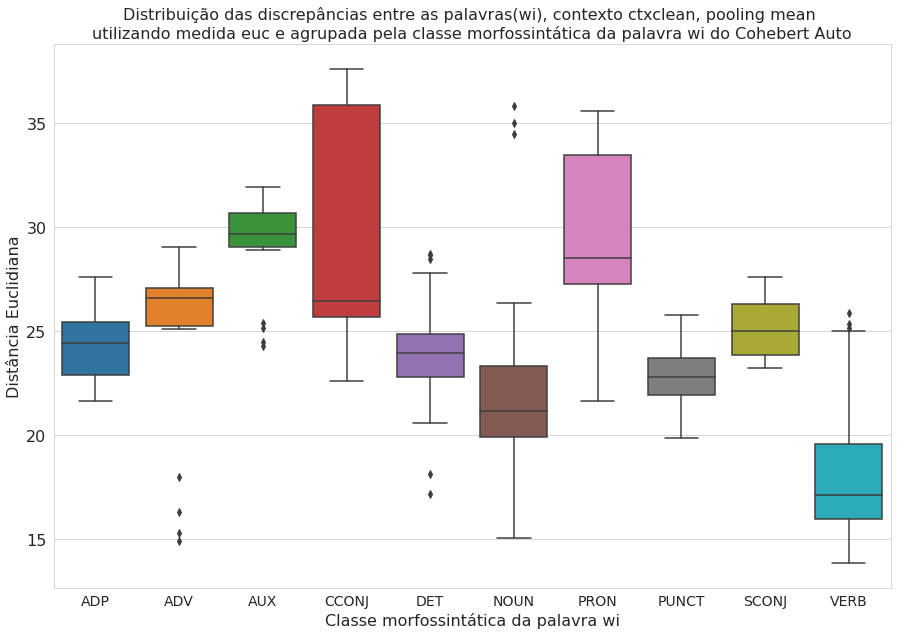

In [120]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do Cohebert Auto")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Distância Euclidiana")

# Mostra o gráfico
plt.show()

##### MAX

In [121]:
estrategia_medida = "max"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [122]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#       avg      std       min       25%       50%       75%  \
pos_i                                                                         
ADP    38.000000 24.298352 1.618593 21.629093 22.912230 24.437131 25.463767   
ADV    21.000000 27.476826 1.790682 25.095573 26.571877 27.022491 28.262859   
AUX    20.000000 29.082397 2.329410 24.275120 29.066267 29.666791 30.692336   
CCONJ  28.000000 29.316342 5.316154 22.630600 25.689705 26.462142 35.857723   
DET    69.000000 24.382466 2.232968 20.575109 22.940285 24.047747 25.145046   
NOUN  108.000000 23.616702 3.155514 18.806923 21.105685 23.181672 24.886296   
PRON   41.000000 29.203888 4.458891 21.658165 27.272602 28.533382 33.483074   
PUNCT  40.000000 22.903812 1.470251 19.877274 21.957900 22.802380 23.720039   
SCONJ  23.000000 25.144396 1.391629 23.255230 23.837234 25.004234 26.332709   
VERB   46.000000 27.449556 2.359412 22.535269 25.572046 27.431482 29.034761   

            max  
pos_i            
ADP   27.604006  
ADV   32.046986  
AUX   31.915607  
CCONJ 37.613647  
DET   33.072311  
NOUN  35.812756  
PRON  35.610611  
PUNCT 25.787270  
SCONJ 27.629211  
VERB  33.051857

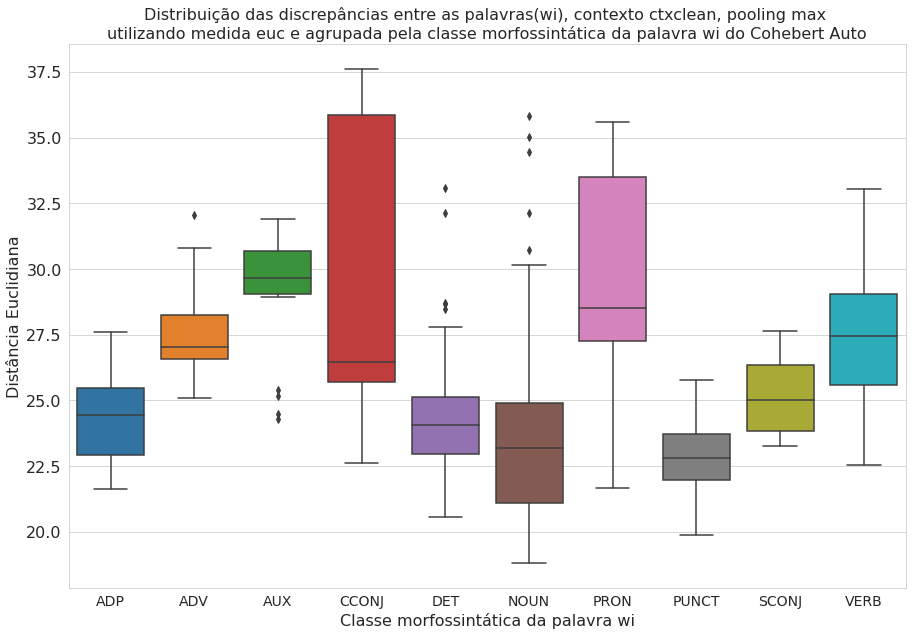

In [123]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do Cohebert Auto")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Distância Euclidiana")

# Mostra o gráfico
plt.show()

#### MAN

In [124]:
medida = "man"

##### MEAN

In [125]:
estrategia_medida = "mean"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [126]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#         avg        std         min         25%         50%  \
pos_i                                                                         
ADP    38.000000 1185.589658  79.253461 1059.188000 1114.788600 1199.421100   
ADV    21.000000 1220.991564 228.963356  710.153700 1230.220000 1322.898900   
AUX    20.000000 1378.235230 110.435640 1155.969100 1378.987875 1406.919750   
CCONJ  28.000000 1224.898543  57.424672 1114.243200 1180.744250 1225.545150   
DET    69.000000 1163.545958  92.059487  841.525700 1112.512000 1157.243200   
NOUN  108.000000 1008.329189 109.823918  738.976800  935.729925 1000.031875   
PRON   41.000000 1406.074310 208.191517 1065.325400 1293.894300 1343.234100   
PUNCT  40.000000 1128.266224  69.148202  969.006960 1094.510200 1131.721050   
SCONJ  23.000000 1233.953270  68.677545 1140.233200 1172.611250 1224.025900   
VERB   46.000000  874.695885 154.373642  672.883540  781.312135  818.506435   

              75%         max  
pos_i                          
ADP   1239.865425 1342.810000  
ADV   1346.346900 1418.941900  
AUX   1447.913075 1515.887500  
CCONJ 1267.843650 1325.354100  
DET   1201.209600 1390.959000  
NOUN  1097.876975 1237.825200  
PRON  1626.921000 1694.084700  
PUNCT 1175.239850 1236.933700  
SCONJ 1276.188100 1343.175000  
VERB   947.473330 1220.759600

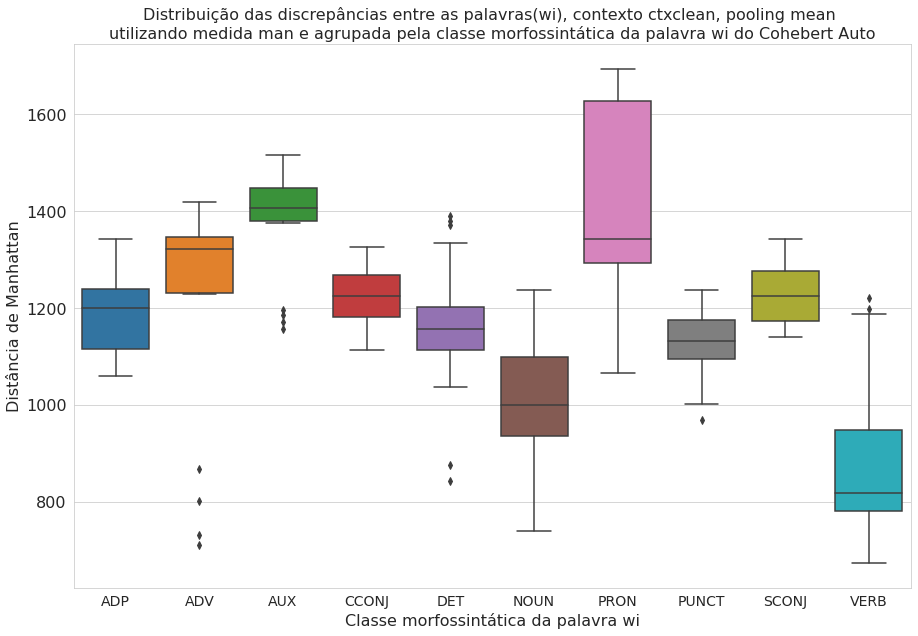

In [127]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do Cohebert Auto")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Distância de Manhattan")

# Mostra o gráfico
plt.show()

##### MAX

In [128]:
estrategia_medida = "max"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [129]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#         avg        std         min         25%         50%  \
pos_i                                                                         
ADP    38.000000 1185.589658  79.253461 1059.188000 1114.788600 1199.421100   
ADV    21.000000 1361.366395 102.183132 1229.837600 1320.208400 1340.790000   
AUX    20.000000 1378.235230 110.435640 1155.969100 1378.987875 1406.919750   
CCONJ  28.000000 1224.898543  57.424672 1114.243200 1180.744250 1225.545150   
DET    69.000000 1185.773145 107.325536 1037.305200 1123.474400 1162.698700   
NOUN  108.000000 1102.997194 137.463404  853.086200 1001.130638 1094.705650   
PRON   41.000000 1406.074310 208.191517 1065.325400 1293.894300 1343.234100   
PUNCT  40.000000 1128.266224  69.148202  969.006960 1094.510200 1131.721050   
SCONJ  23.000000 1233.953270  68.677545 1140.233200 1172.611250 1224.025900   
VERB   46.000000 1332.876183 120.373245 1126.992700 1254.296550 1312.431000   

              75%         max  
pos_i                          
ADP   1239.865425 1342.810000  
ADV   1400.957000 1627.799300  
AUX   1447.913075 1515.887500  
CCONJ 1267.843650 1325.354100  
DET   1216.184000 1640.739500  
NOUN  1169.674100 1617.785800  
PRON  1626.921000 1694.084700  
PUNCT 1175.239850 1236.933700  
SCONJ 1276.188100 1343.175000  
VERB  1406.279325 1654.705700

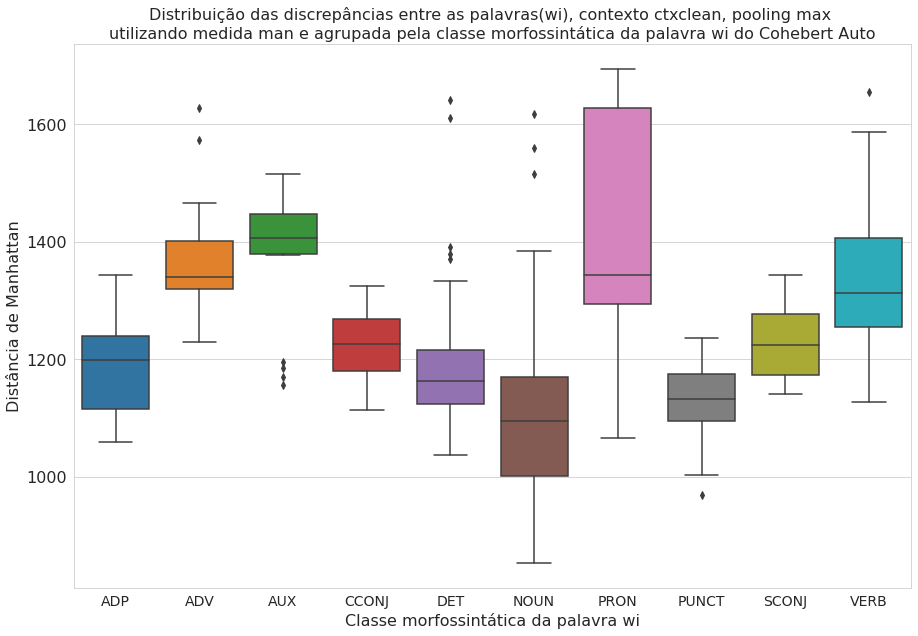

In [130]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do Cohebert Auto")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Distância de Manhattan")

# Mostra o gráfico
plt.show()

### Contexto com palavras da classe VERB e AUX(ctxverb)

In [131]:
equacao_medida = "ctxverb"

#### COS

In [132]:
medida = "cos"

##### MEAN

In [133]:
estrategia_medida = "mean"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [134]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#      avg      std      min      25%      50%      75%      max
pos_i                                                                         
ADP   28.000000 0.738128 0.030187 0.684279 0.709708 0.748288 0.756287 0.796027
ADV   21.000000 0.734427 0.068771 0.592761 0.664390 0.766948 0.771588 0.816233
AUX   20.000000 0.921729 0.045296 0.840420 0.907067 0.913685 0.917218 1.000000
CCONJ 28.000000 0.545226 0.277369 0.102380 0.182410 0.713738 0.747770 0.766522
DET   65.000000 0.727959 0.055331 0.582649 0.695136 0.725423 0.775840 0.821144
NOUN  92.000000 0.682682 0.065309 0.480838 0.654796 0.694541 0.726632 0.790527
PRON  41.000000 0.713799 0.055383 0.543517 0.692386 0.734380 0.748788 0.765561
PUNCT 36.000000 0.694518 0.038710 0.618531 0.666107 0.699733 0.730926 0.742709
SCONJ 23.000000 0.731763 0.030373 0.692472 0.702209 0.735567 0.758883 0.779443
VERB  46.000000 0.921061 0.052430 0.838702 0.883408 0.895120 0.972769 1.000000

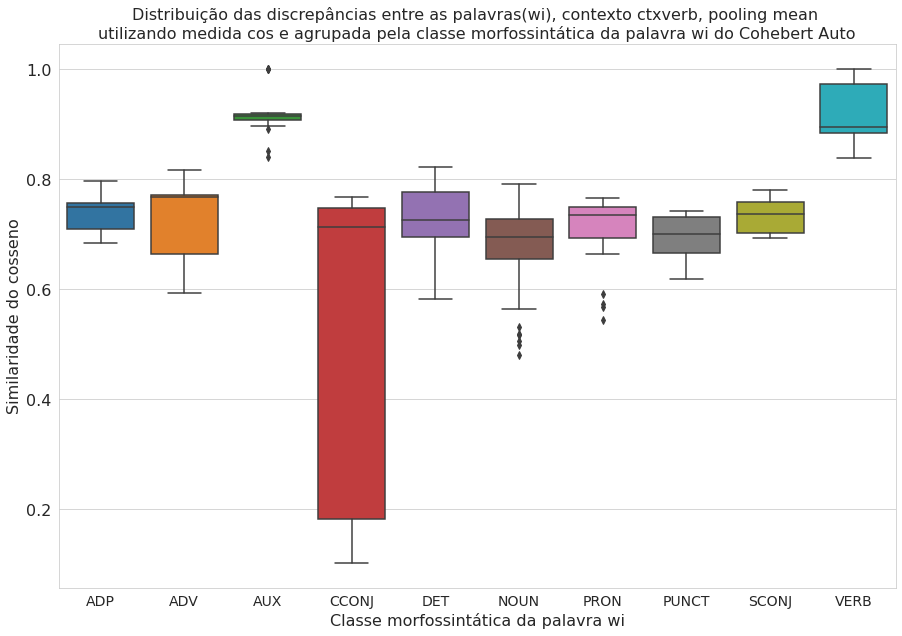

In [135]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do Cohebert Auto")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Similaridade do cosseno")

# Mostra o gráfico
plt.show()

##### MAX

In [136]:
estrategia_medida = "max"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [137]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#      avg      std      min      25%      50%      75%      max
pos_i                                                                         
ADP   28.000000 0.738128 0.030187 0.684279 0.709708 0.748288 0.756287 0.796027
ADV   21.000000 0.709358 0.087807 0.502586 0.643785 0.763600 0.770056 0.789151
AUX   20.000000 0.921729 0.045296 0.840420 0.907067 0.913685 0.917218 1.000000
CCONJ 28.000000 0.545226 0.277369 0.102380 0.182410 0.713738 0.747770 0.766522
DET   65.000000 0.722106 0.058133 0.582649 0.691475 0.724856 0.770034 0.821144
NOUN  92.000000 0.665070 0.062716 0.480838 0.648251 0.674121 0.704838 0.755232
PRON  41.000000 0.713799 0.055383 0.543517 0.692386 0.734380 0.748788 0.765561
PUNCT 36.000000 0.694518 0.038710 0.618531 0.666107 0.699733 0.730926 0.742709
SCONJ 23.000000 0.731763 0.030373 0.692472 0.702209 0.735567 0.758883 0.779443
VERB  46.000000 0.797646 0.070152 0.670455 0.749148 0.788088 0.844462 0.931386

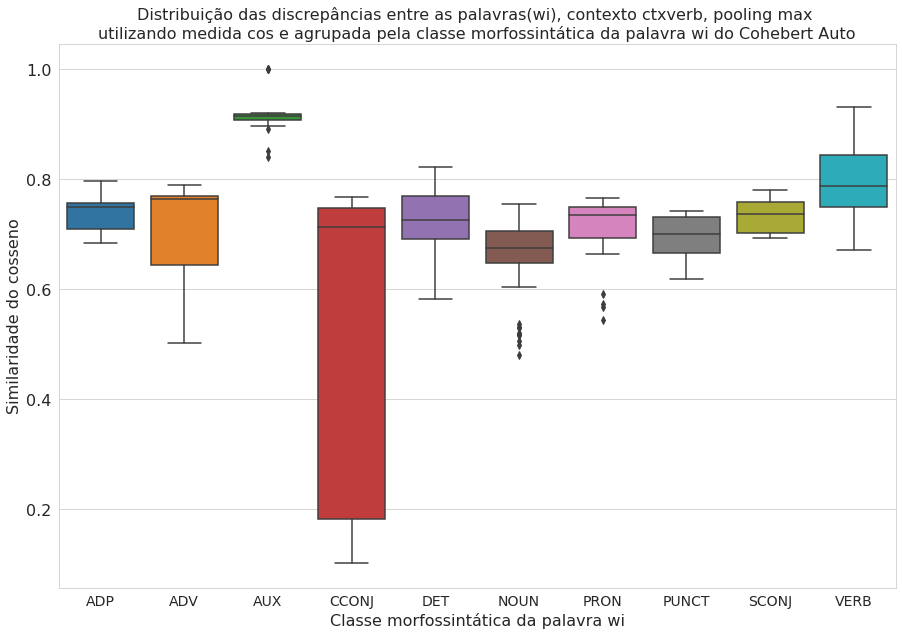

In [138]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do Cohebert Auto")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Similaridade do cosseno")

# Mostra o gráfico
plt.show()

#### EUC

In [139]:
medida = "euc"

##### MEAN

In [140]:
estrategia_medida = "mean"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [141]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#       avg      std       min       25%       50%       75%  \
pos_i                                                                        
ADP   28.000000 28.040266 1.422200 25.312115 27.193081 27.620645 29.266089   
ADV   21.000000 27.313916 4.345554 20.747019 25.102406 25.738203 32.735310   
AUX   20.000000 13.575419 7.068099  0.000000 16.030541 16.355145 16.769197   
CCONJ 28.000000 30.675531 5.824763 24.532892 25.744531 27.303640 37.666129   
DET   65.000000 27.207462 3.458014 21.522627 24.227085 27.028625 29.215708   
NOUN  92.000000 31.080633 4.813125 22.345469 28.087083 30.385395 33.155839   
PRON  41.000000 28.911149 3.608335 25.009300 26.275940 28.220617 30.395283   
PUNCT 36.000000 28.961088 2.274916 26.427544 26.932854 28.417486 30.096876   
SCONJ 23.000000 27.255426 1.710104 24.180506 25.844609 26.979792 28.764819   
VERB  46.000000 12.801372 6.955124  0.000000  8.283899 16.264188 17.946588   

            max  
pos_i            
ADP   30.936363  
ADV   34.379868  
AUX   20.635284  
CCONJ 39.914532  
DET   35.739681  
NOUN  46.616928  
PRON  39.349304  
PUNCT 34.050678  
SCONJ 29.962635  
VERB  20.235275

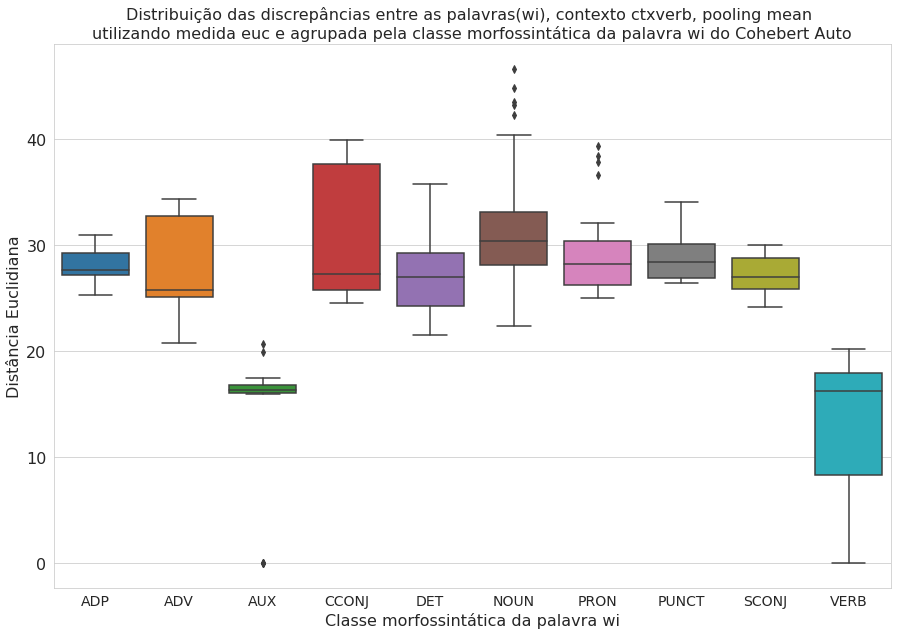

In [142]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do Cohebert Auto")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Distância Euclidiana")

# Mostra o gráfico
plt.show()

##### MAX

In [143]:
estrategia_medida = "max"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [144]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#       avg      std       min       25%       50%       75%  \
pos_i                                                                        
ADP   28.000000 28.040266 1.422200 25.312115 27.193081 27.620645 29.266089   
ADV   21.000000 29.145682 5.310019 23.670513 25.521244 25.865068 33.721413   
AUX   20.000000 13.575419 7.068099  0.000000 16.030541 16.355145 16.769197   
CCONJ 28.000000 30.675531 5.824763 24.532892 25.744531 27.303640 37.666129   
DET   65.000000 27.615527 3.584385 21.522627 24.935783 27.321217 29.712896   
NOUN  92.000000 32.289044 4.243266 27.065489 29.645148 31.298631 33.383882   
PRON  41.000000 28.911149 3.608335 25.009300 26.275940 28.220617 30.395283   
PUNCT 36.000000 28.961088 2.274916 26.427544 26.932854 28.417486 30.096876   
SCONJ 23.000000 27.255426 1.710104 24.180506 25.844609 26.979792 28.764819   
VERB  46.000000 24.434727 4.029588 17.562273 21.563921 25.010489 26.823060   

            max  
pos_i            
ADP   30.936363  
ADV   40.281300  
AUX   20.635284  
CCONJ 39.914532  
DET   35.739681  
NOUN  46.616928  
PRON  39.349304  
PUNCT 34.050678  
SCONJ 29.962635  
VERB  31.964499

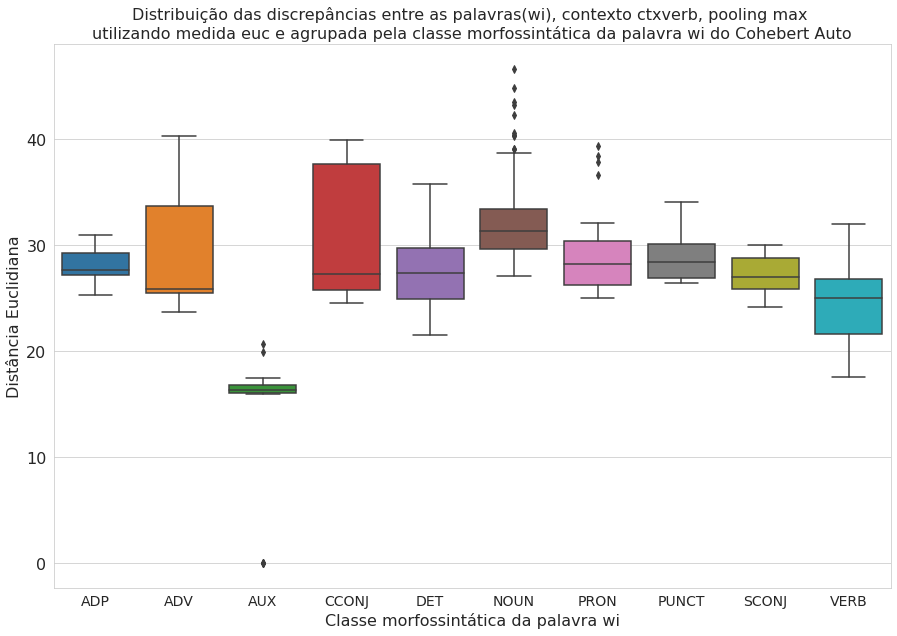

In [145]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do Cohebert Auto")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Distância Euclidiana")

# Mostra o gráfico
plt.show()

#### MAN

In [146]:
medida = "man"

##### MEAN

In [147]:
estrategia_medida = "mean"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [148]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#         avg        std         min         25%         50%  \
pos_i                                                                        
ADP   28.000000 1379.990008  77.043394 1248.880005 1330.100220 1356.346130   
ADV   21.000000 1349.239732 208.187363  994.033020 1253.738037 1294.920044   
AUX   20.000000  658.153561 341.899516    0.000000  780.063904  793.817505   
CCONJ 28.000000 1351.183153 101.553938 1210.136230 1279.216034 1309.368713   
DET   65.000000 1340.976007 168.078998 1061.915161 1213.008301 1326.410156   
NOUN  92.000000 1449.237132 185.852195 1084.597900 1337.831299 1428.692078   
PRON  41.000000 1414.865571 169.651384 1217.188232 1278.246338 1387.295166   
PUNCT 36.000000 1441.833988 102.179306 1322.247314 1347.407745 1413.677917   
SCONJ 23.000000 1352.631581  75.163266 1207.845093 1289.955261 1346.643311   
VERB  46.000000  617.139205 333.938193    0.000000  405.051170  791.006409   

              75%         max  
pos_i                          
ADP   1454.848145 1523.408691  
ADV   1605.118652 1694.468628  
AUX    815.790527  984.767151  
CCONJ 1421.470215 1571.861572  
DET   1435.201172 1768.969238  
NOUN  1550.790405 1988.902832  
PRON  1485.656250 1876.228882  
PUNCT 1514.871338 1666.678223  
SCONJ 1418.322449 1461.911621  
VERB   855.818146  964.706482

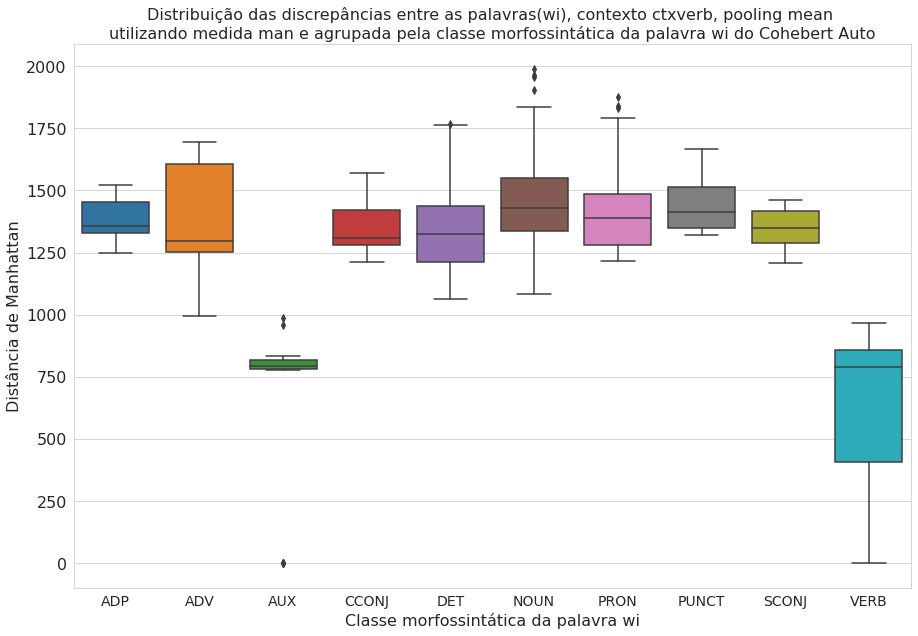

In [149]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do Cohebert Auto")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Distância de Manhattan")

# Mostra o gráfico
plt.show()

##### MAX

In [150]:
estrategia_medida = "max"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [151]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#         avg        std         min         25%         50%  \
pos_i                                                                        
ADP   28.000000 1379.990008  77.043394 1248.880005 1330.100220 1356.346130   
ADV   21.000000 1445.383103 249.901920 1172.891846 1279.261719 1295.263184   
AUX   20.000000  658.153561 341.899516    0.000000  780.063904  793.817505   
CCONJ 28.000000 1351.183153 101.553938 1210.136230 1279.216034 1309.368713   
DET   65.000000 1361.537468 174.390125 1064.153809 1240.216553 1336.420654   
NOUN  92.000000 1510.411717 171.269542 1247.031250 1407.397003 1467.139709   
PRON  41.000000 1414.865571 169.651384 1217.188232 1278.246338 1387.295166   
PUNCT 36.000000 1441.833988 102.179306 1322.247314 1347.407745 1413.677917   
SCONJ 23.000000 1352.631581  75.163266 1207.845093 1289.955261 1346.643311   
VERB  46.000000 1220.762342 196.940437  842.355835 1078.851562 1247.949280   

              75%         max  
pos_i                          
ADP   1454.848145 1523.408691  
ADV   1670.137451 1951.874268  
AUX    815.790527  984.767151  
CCONJ 1421.470215 1571.861572  
DET   1477.897705 1768.969238  
NOUN  1561.662170 1988.902832  
PRON  1485.656250 1876.228882  
PUNCT 1514.871338 1666.678223  
SCONJ 1418.322449 1461.911621  
VERB  1350.717987 1612.307739

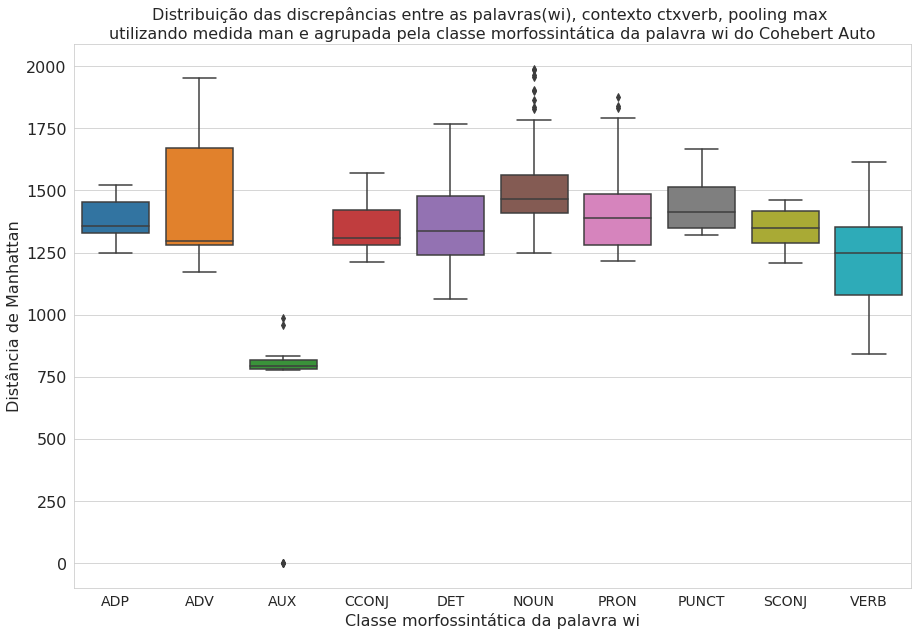

In [152]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do Cohebert Auto")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Distância de Manhattan")

# Mostra o gráfico
plt.show()

### Contexto com palavras da classe NOUN(ctxnoun)

In [153]:
equacao_medida = "ctxnoun"

#### COS

In [154]:
medida = "cos"

##### MEAN

In [155]:
estrategia_medida = "mean"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [156]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#      avg      std      min      25%      50%      75%  \
pos_i                                                                    
ADP    38.000000 0.766553 0.050114 0.675898 0.732374 0.775734 0.808950   
ADV    21.000000 0.657259 0.054880 0.578964 0.632603 0.650343 0.676038   
AUX    20.000000 0.599500 0.042389 0.547776 0.562666 0.592491 0.624895   
CCONJ  28.000000 0.477451 0.208345 0.147500 0.220332 0.582435 0.624041   
DET    69.000000 0.729908 0.049887 0.633926 0.693576 0.726868 0.767055   
NOUN  108.000000 0.888524 0.025915 0.825329 0.870703 0.885522 0.907312   
PRON   41.000000 0.578636 0.082771 0.473523 0.524028 0.553175 0.618765   
PUNCT  40.000000 0.660322 0.030064 0.607156 0.637889 0.657599 0.682785   
SCONJ  23.000000 0.669493 0.035290 0.589157 0.652893 0.672157 0.687996   
VERB   46.000000 0.758516 0.041452 0.682117 0.733888 0.755251 0.786102   

           max  
pos_i           
ADP   0.845480  
ADV   0.788652  
AUX   0.683061  
CCONJ 0.692470  
DET   0.853191  
NOUN  0.938791  
PRON  0.760544  
PUNCT 0.727795  
SCONJ 0.734215  
VERB  0.845183

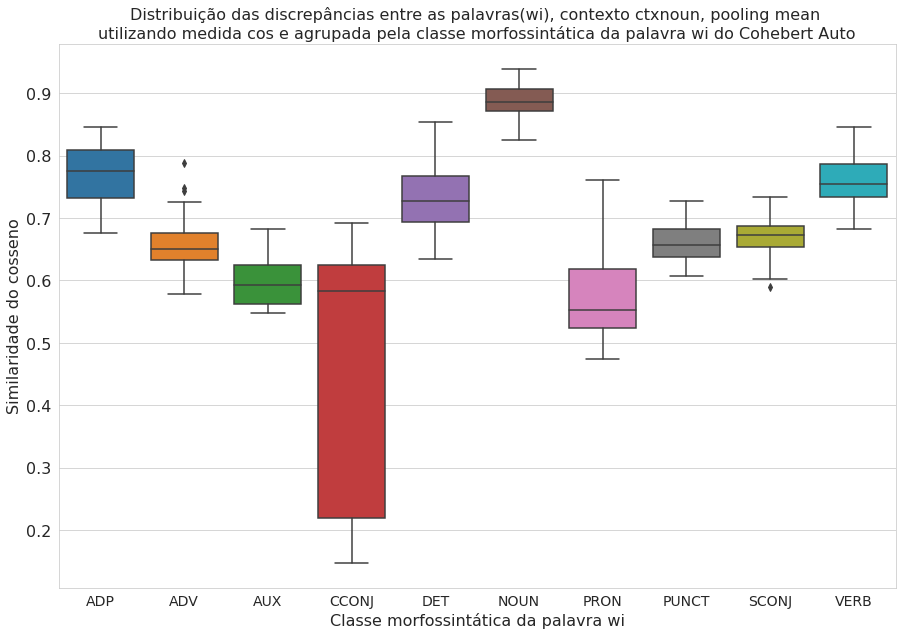

In [157]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do Cohebert Auto")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Similaridade do cosseno")

# Mostra o gráfico
plt.show()

##### MAX

In [158]:
estrategia_medida = "max"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [159]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#      avg      std      min      25%      50%      75%  \
pos_i                                                                    
ADP    38.000000 0.766553 0.050114 0.675898 0.732374 0.775734 0.808950   
ADV    21.000000 0.628624 0.035336 0.545576 0.603110 0.635953 0.653297   
AUX    20.000000 0.599500 0.042389 0.547776 0.562666 0.592491 0.624895   
CCONJ  28.000000 0.477451 0.208345 0.147500 0.220332 0.582435 0.624041   
DET    69.000000 0.724883 0.056403 0.549781 0.689658 0.721136 0.766046   
NOUN  108.000000 0.864111 0.058816 0.654618 0.828783 0.878747 0.906829   
PRON   41.000000 0.578636 0.082771 0.473523 0.524028 0.553175 0.618765   
PUNCT  40.000000 0.660322 0.030064 0.607156 0.637889 0.657599 0.682785   
SCONJ  23.000000 0.669493 0.035290 0.589157 0.652893 0.672157 0.687996   
VERB   46.000000 0.643140 0.053293 0.538292 0.608251 0.635877 0.681920   

           max  
pos_i           
ADP   0.845480  
ADV   0.681493  
AUX   0.683061  
CCONJ 0.692470  
DET   0.853191  
NOUN  0.938791  
PRON  0.760544  
PUNCT 0.727795  
SCONJ 0.734215  
VERB  0.750776

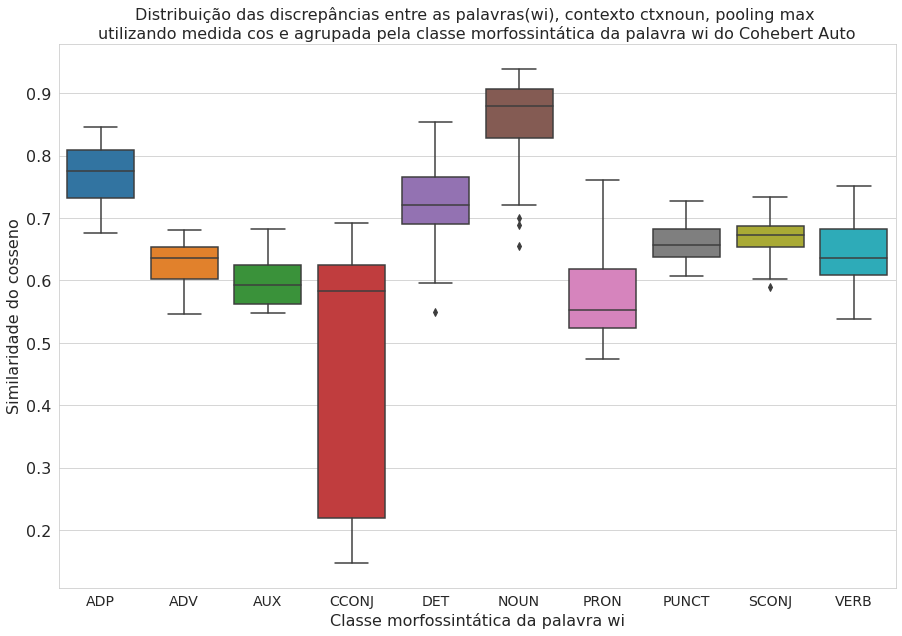

In [160]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do Cohebert Auto")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Similaridade do cosseno")

# Mostra o gráfico
plt.show()

#### EUC

In [161]:
medida = "euc"

##### MEAN

In [162]:
estrategia_medida = "mean"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [163]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#       avg      std       min       25%       50%       75%  \
pos_i                                                                         
ADP    38.000000 26.505327 2.721234 22.040478 24.145485 26.454199 28.446405   
ADV    21.000000 31.363921 3.366631 23.847445 30.235966 31.339556 33.559547   
AUX    20.000000 34.160937 2.651273 28.993835 32.441385 34.787714 36.461021   
CCONJ  28.000000 34.918944 3.667844 29.070448 32.021040 34.451349 37.256219   
DET    69.000000 27.446633 2.663784 20.199186 25.715721 27.507902 29.355232   
NOUN  108.000000 19.057229 2.890300 14.569006 17.207865 18.936301 20.135258   
PRON   41.000000 35.187548 3.671819 27.346512 32.149807 35.859871 38.025028   
PUNCT  40.000000 30.980975 1.698662 27.585634 30.075258 31.002498 31.908237   
SCONJ  23.000000 30.778890 2.064064 26.896145 29.649438 30.482046 31.847339   
VERB   46.000000 25.604029 3.095116 18.897543 23.741280 25.307844 27.197792   

            max  
pos_i            
ADP   31.583282  
ADV   36.661480  
AUX   37.766052  
CCONJ 41.862366  
DET   33.742077  
NOUN  34.023926  
PRON  40.790325  
PUNCT 33.949024  
SCONJ 35.250549  
VERB  32.435139

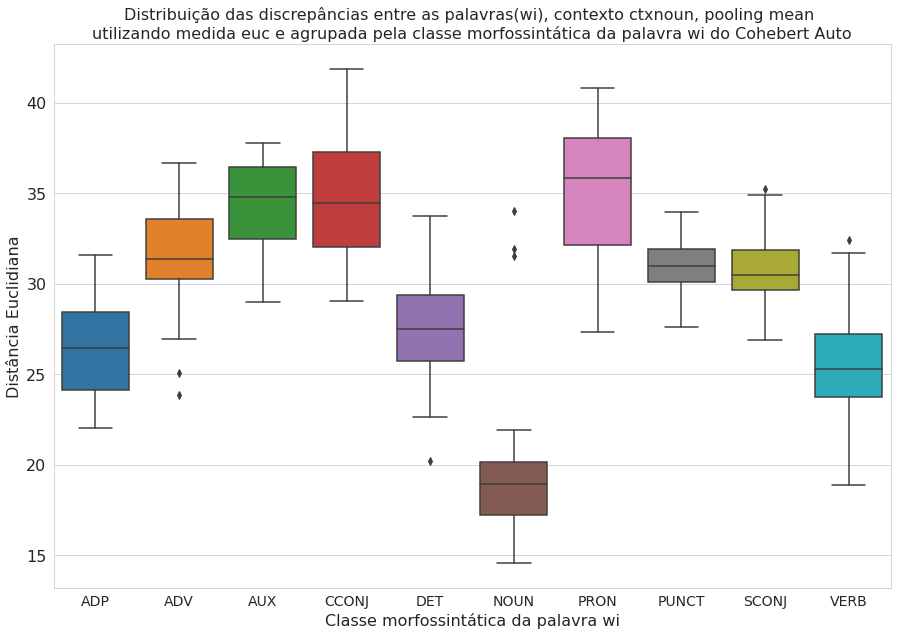

In [164]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do Cohebert Auto")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Distância Euclidiana")

# Mostra o gráfico
plt.show()

##### MAX

In [165]:
estrategia_medida = "max"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [166]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#       avg      std       min       25%       50%       75%  \
pos_i                                                                         
ADP    38.000000 26.505327 2.721234 22.040478 24.145485 26.454199 28.446405   
ADV    21.000000 33.322856 2.563757 30.067091 31.337414 32.942638 34.946182   
AUX    20.000000 34.160937 2.651273 28.993835 32.441385 34.787714 36.461021   
CCONJ  28.000000 34.918944 3.667844 29.070448 32.021040 34.451349 37.256219   
DET    69.000000 27.792669 3.082151 20.199186 25.935707 27.631752 29.726408   
NOUN  108.000000 20.936219 4.069775 15.253929 17.949716 20.074553 22.766421   
PRON   41.000000 35.187548 3.671819 27.346512 32.149807 35.859871 38.025028   
PUNCT  40.000000 30.980975 1.698662 27.585634 30.075258 31.002498 31.908237   
SCONJ  23.000000 30.778890 2.064064 26.896145 29.649438 30.482046 31.847339   
VERB   46.000000 33.007389 2.619525 27.314680 31.470810 33.026672 34.451274   

            max  
pos_i            
ADP   31.583282  
ADV   39.248241  
AUX   37.766052  
CCONJ 41.862366  
DET   38.266544  
NOUN  34.023926  
PRON  40.790325  
PUNCT 33.949024  
SCONJ 35.250549  
VERB  38.622162

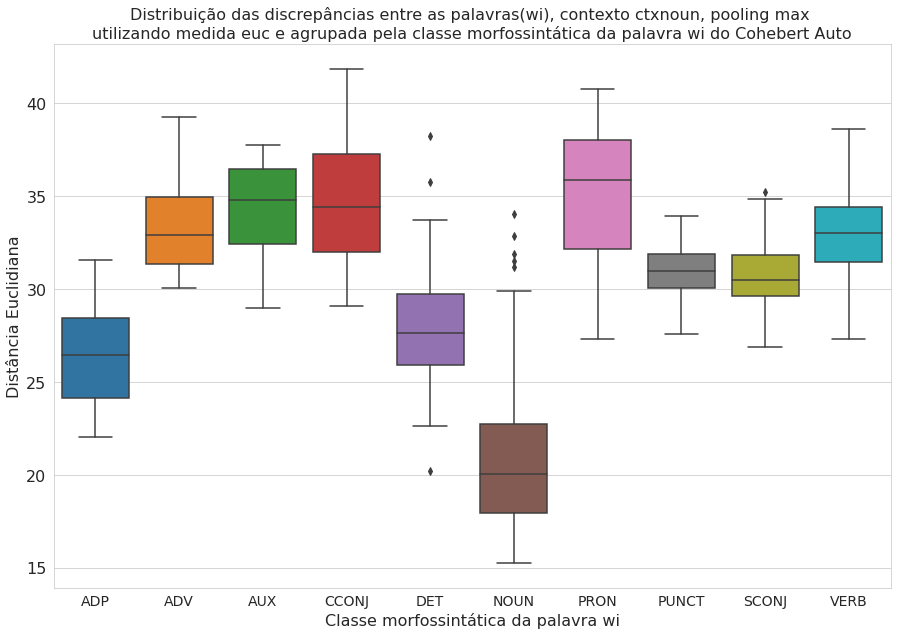

In [167]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do Cohebert Auto")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Distância Euclidiana")

# Mostra o gráfico
plt.show()

#### MAN

In [168]:
medida = "man"

##### MEAN

In [169]:
estrategia_medida = "mean"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [170]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#         avg        std         min         25%         50%  \
pos_i                                                                         
ADP    38.000000 1271.943103 127.146251 1073.391500 1166.479375 1249.147600   
ADV    21.000000 1518.945881 176.223384 1127.565800 1473.480500 1531.763700   
AUX    20.000000 1588.564050 112.713108 1374.132900 1524.947875 1601.041050   
CCONJ  28.000000 1482.381361 140.054840 1252.309200 1352.863350 1492.827600   
DET    69.000000 1299.757662 114.695737 1001.147200 1228.858600 1298.183100   
NOUN  108.000000  876.930347  98.406364  697.053340  785.963300  880.169000   
PRON   41.000000 1671.855590 155.372679 1355.011800 1550.219500 1675.418200   
PUNCT  40.000000 1503.396022  72.526178 1341.220700 1467.217975 1513.968700   
SCONJ  23.000000 1479.562839 105.145122 1283.660900 1421.900500 1474.187700   
VERB   46.000000 1210.909298 145.352283  897.339970 1137.720600 1192.478400   

              75%         max  
pos_i                          
ADP   1371.193475 1508.345000  
ADV   1629.272100 1753.070300  
AUX   1678.434325 1738.710800  
CCONJ 1602.678500 1720.012500  
DET   1367.249500 1593.753700  
NOUN   942.397150 1165.996800  
PRON  1790.963900 1930.248700  
PUNCT 1537.343325 1636.302600  
SCONJ 1511.673600 1720.492800  
VERB  1279.407575 1543.213400

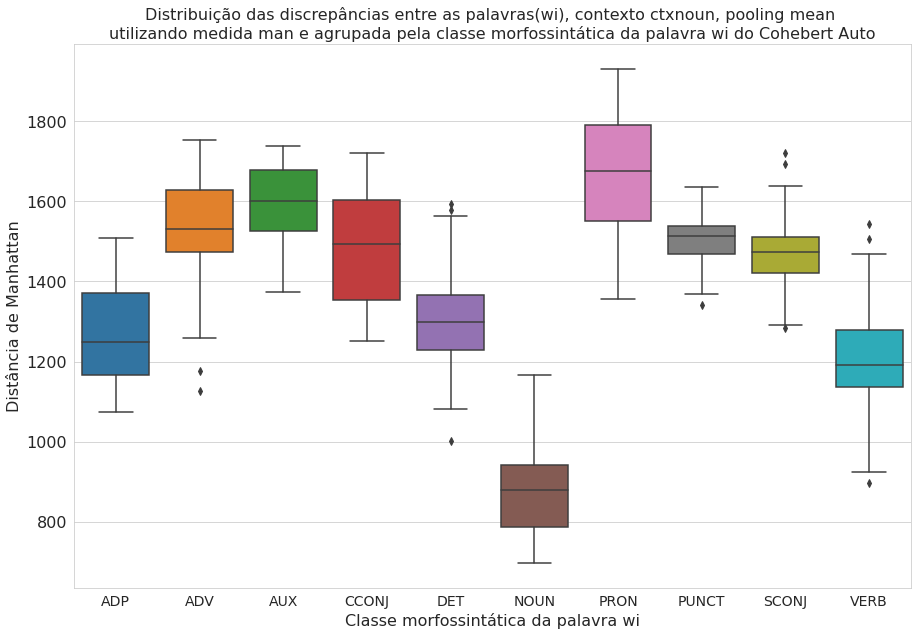

In [171]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do Cohebert Auto")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Distância de Manhattan")

# Mostra o gráfico
plt.show()

##### MAX

In [172]:
estrategia_medida = "max"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [173]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#         avg        std         min         25%         50%  \
pos_i                                                                         
ADP    38.000000 1271.943103 127.146251 1073.391500 1166.479375 1249.147600   
ADV    21.000000 1622.970329 118.649196 1472.927600 1506.395000 1621.600200   
AUX    20.000000 1588.564050 112.713108 1374.132900 1524.947875 1601.041050   
CCONJ  28.000000 1482.381361 140.054840 1252.309200 1352.863350 1492.827600   
DET    69.000000 1317.401364 139.870190 1001.147200 1238.525900 1308.934600   
NOUN  108.000000  974.212930 189.534783  712.051200  825.967145  936.972900   
PRON   41.000000 1671.855590 155.372679 1355.011800 1550.219500 1675.418200   
PUNCT  40.000000 1503.396022  72.526178 1341.220700 1467.217975 1513.968700   
SCONJ  23.000000 1479.562839 105.145122 1283.660900 1421.900500 1474.187700   
VERB   46.000000 1565.012846 119.870640 1333.597400 1482.689575 1547.926400   

              75%         max  
pos_i                          
ADP   1371.193475 1508.345000  
ADV   1693.801000 1900.606700  
AUX   1678.434325 1738.710800  
CCONJ 1602.678500 1720.012500  
DET   1390.855800 1836.122300  
NOUN  1061.291750 1632.805500  
PRON  1790.963900 1930.248700  
PUNCT 1537.343325 1636.302600  
SCONJ 1511.673600 1720.492800  
VERB  1620.855625 1861.415000

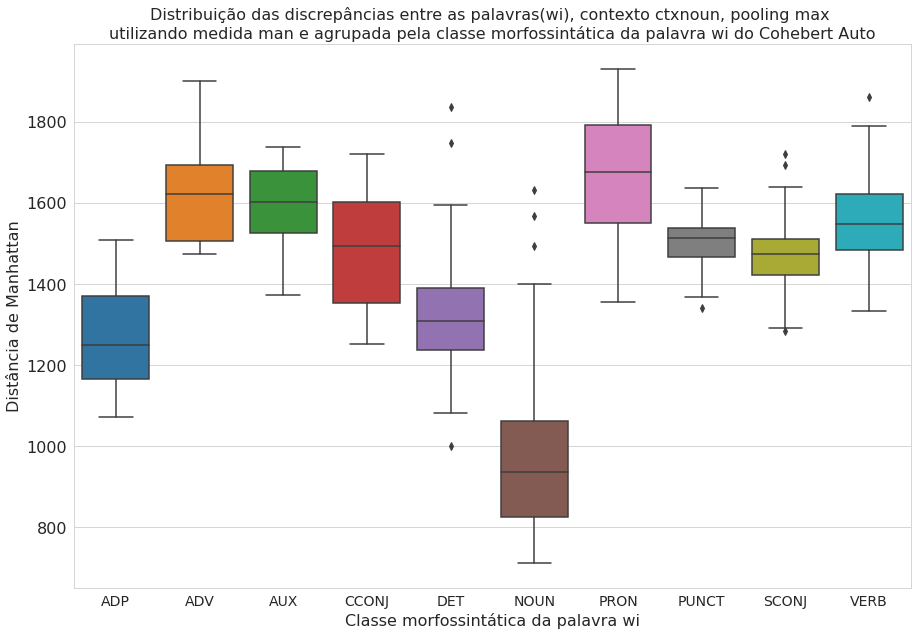

In [174]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do Cohebert Auto")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Distância de Manhattan")

# Mostra o gráfico
plt.show()

### Contexto com palavras da classe VERB(AUX) e NOUN(ctxverbnoun)

In [175]:
equacao_medida = "ctxverbnoun"

#### COS

In [176]:
medida = "cos"

##### MEAN

In [177]:
estrategia_medida = "mean"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [178]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#      avg      std      min      25%      50%      75%  \
pos_i                                                                    
ADP    38.000000 0.787755 0.043313 0.706124 0.768251 0.790687 0.822976   
ADV    21.000000 0.748672 0.040151 0.670828 0.731485 0.743941 0.757580   
AUX    20.000000 0.791786 0.013315 0.765143 0.784585 0.789423 0.798521   
CCONJ  28.000000 0.543945 0.256856 0.135959 0.215907 0.703857 0.722518   
DET    69.000000 0.777092 0.041475 0.672376 0.758672 0.781018 0.804062   
NOUN  108.000000 0.860804 0.024822 0.802245 0.846128 0.860213 0.875497   
PRON   41.000000 0.689463 0.038772 0.622232 0.655662 0.687380 0.714338   
PUNCT  40.000000 0.714277 0.022995 0.644551 0.706693 0.719701 0.731001   
SCONJ  23.000000 0.731606 0.025749 0.697301 0.717719 0.729200 0.735042   
VERB   46.000000 0.870809 0.031808 0.813792 0.845761 0.871724 0.894941   

           max  
pos_i           
ADP   0.845480  
ADV   0.836372  
AUX   0.824791  
CCONJ 0.766613  
DET   0.849272  
NOUN  0.918863  
PRON  0.767919  
PUNCT 0.738754  
SCONJ 0.795106  
VERB  0.926419

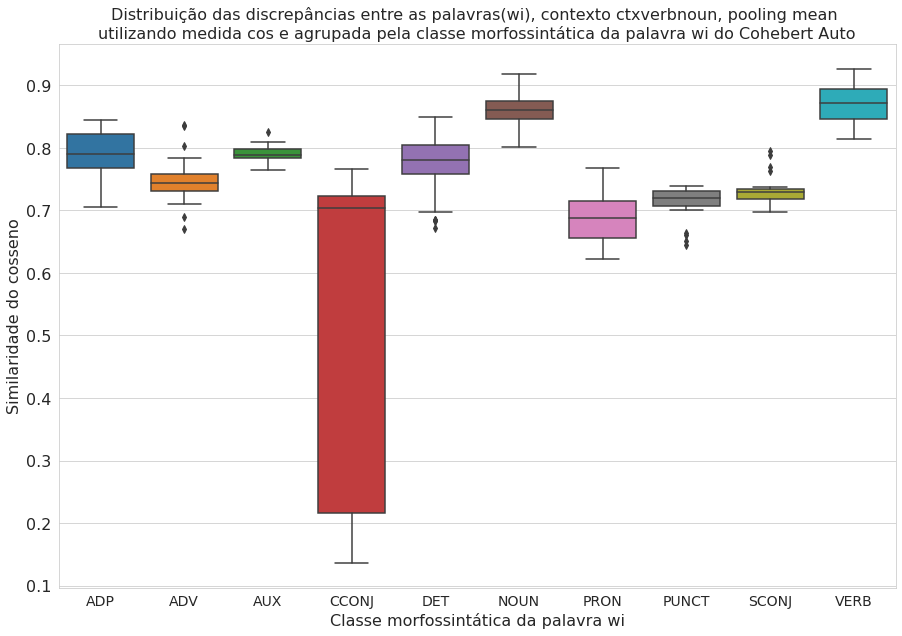

In [179]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do Cohebert Auto")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Similaridade do cosseno")

# Mostra o gráfico
plt.show()

##### MAX

In [180]:
estrategia_medida = "max"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [181]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#      avg      std      min      25%      50%      75%  \
pos_i                                                                    
ADP    38.000000 0.787755 0.043313 0.706124 0.768251 0.790687 0.822976   
ADV    21.000000 0.718578 0.037698 0.641678 0.689075 0.735260 0.744352   
AUX    20.000000 0.791786 0.013315 0.765143 0.784585 0.789423 0.798521   
CCONJ  28.000000 0.543945 0.256856 0.135959 0.215907 0.703857 0.722518   
DET    69.000000 0.771538 0.048781 0.610925 0.752579 0.777853 0.802156   
NOUN  108.000000 0.836471 0.047681 0.671942 0.812471 0.849512 0.866011   
PRON   41.000000 0.689463 0.038772 0.622232 0.655662 0.687380 0.714338   
PUNCT  40.000000 0.714277 0.022995 0.644551 0.706693 0.719701 0.731001   
SCONJ  23.000000 0.731606 0.025749 0.697301 0.717719 0.729200 0.735042   
VERB   46.000000 0.745678 0.053294 0.641902 0.704491 0.746549 0.774696   

           max  
pos_i           
ADP   0.845480  
ADV   0.759473  
AUX   0.824791  
CCONJ 0.766613  
DET   0.849272  
NOUN  0.909825  
PRON  0.767919  
PUNCT 0.738754  
SCONJ 0.795106  
VERB  0.858533

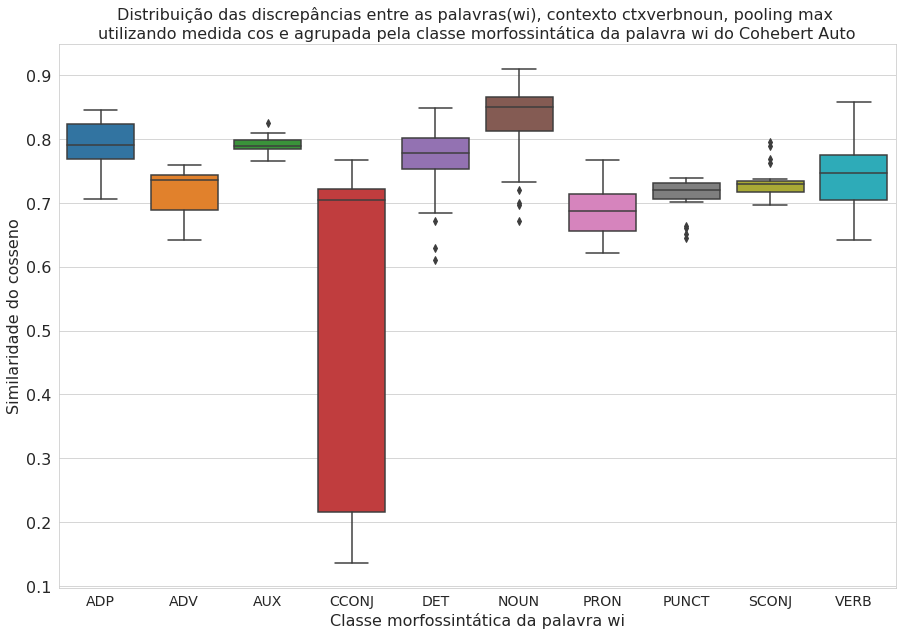

In [182]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do Cohebert Auto")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Similaridade do cosseno")

# Mostra o gráfico
plt.show()

#### EUC

In [183]:
medida = "euc"

##### MEAN

In [184]:
estrategia_medida = "mean"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [185]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#       avg      std       min       25%       50%       75%  \
pos_i                                                                         
ADP    38.000000 25.102501 2.204548 22.001286 23.200906 24.960397 26.662812   
ADV    21.000000 26.069031 2.938902 19.108879 25.443907 26.986599 27.415804   
AUX    20.000000 24.165722 1.080118 21.570675 23.771501 24.326805 25.017167   
CCONJ  28.000000 30.368383 4.886293 24.743538 26.690937 27.769804 36.209963   
DET    69.000000 24.340404 2.361055 20.277349 22.721638 23.972900 25.417206   
NOUN  108.000000 21.145817 3.379122 14.569006 19.062768 20.715960 22.599946   
PRON   41.000000 29.429711 1.850569 26.827873 27.926077 29.032808 31.079651   
PUNCT  40.000000 27.694748 1.195282 26.152267 26.813555 27.437585 28.285600   
SCONJ  23.000000 27.108130 1.527379 23.298159 26.980382 27.307211 27.758900   
VERB   46.000000 18.200638 3.079528 13.450160 16.229404 17.537029 19.923605   

            max  
pos_i            
ADP   29.273218  
ADV   30.953794  
AUX   25.637686  
CCONJ 38.309658  
DET   30.686665  
NOUN  35.277199  
PRON  32.764492  
PUNCT 30.944723  
SCONJ 29.207205  
VERB  25.065130

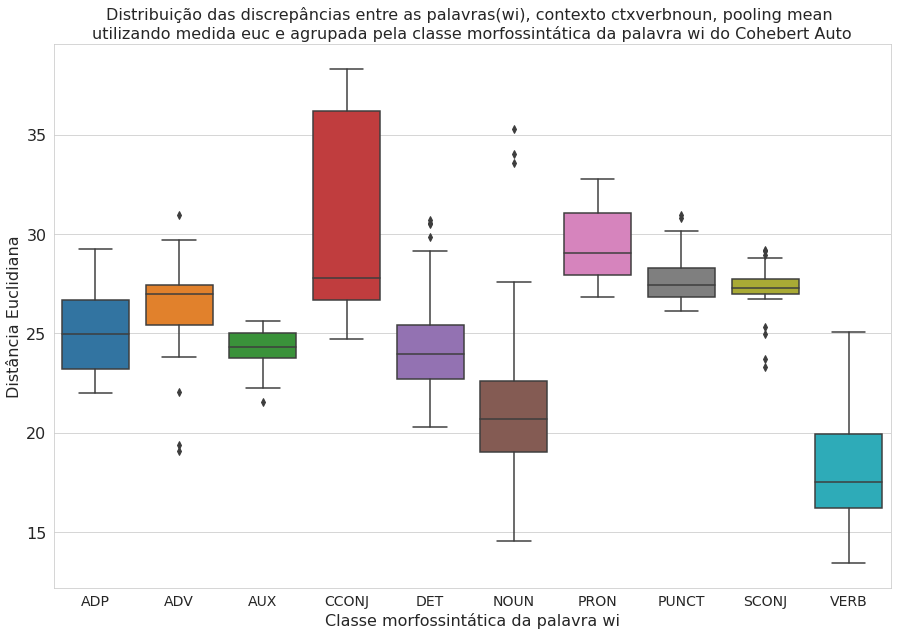

In [186]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do Cohebert Auto")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Distância Euclidiana")

# Mostra o gráfico
plt.show()

##### MAX

In [187]:
estrategia_medida = "max"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [188]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#       avg      std       min       25%       50%       75%  \
pos_i                                                                         
ADP    38.000000 25.102501 2.204548 22.001286 23.200906 24.960397 26.662812   
ADV    21.000000 28.275035 2.603963 25.116104 26.717819 27.351727 29.695944   
AUX    20.000000 24.165722 1.080118 21.570675 23.771501 24.326805 25.017167   
CCONJ  28.000000 30.368383 4.886293 24.743538 26.690937 27.769804 36.209963   
DET    69.000000 24.733836 2.827390 20.294981 22.899788 24.058786 25.560139   
NOUN  108.000000 23.010553 3.471957 16.810907 20.582219 22.575870 24.666563   
PRON   41.000000 29.429711 1.850569 26.827873 27.926077 29.032808 31.079651   
PUNCT  40.000000 27.694748 1.195282 26.152267 26.813555 27.437585 28.285600   
SCONJ  23.000000 27.108130 1.527379 23.298159 26.980382 27.307211 27.758900   
VERB   46.000000 27.412402 2.602303 22.566936 25.498053 26.969605 29.001858   

            max  
pos_i            
ADP   29.273218  
ADV   33.937496  
AUX   25.637686  
CCONJ 38.309658  
DET   34.891056  
NOUN  35.277199  
PRON  32.764492  
PUNCT 30.944723  
SCONJ 29.207205  
VERB  33.166889

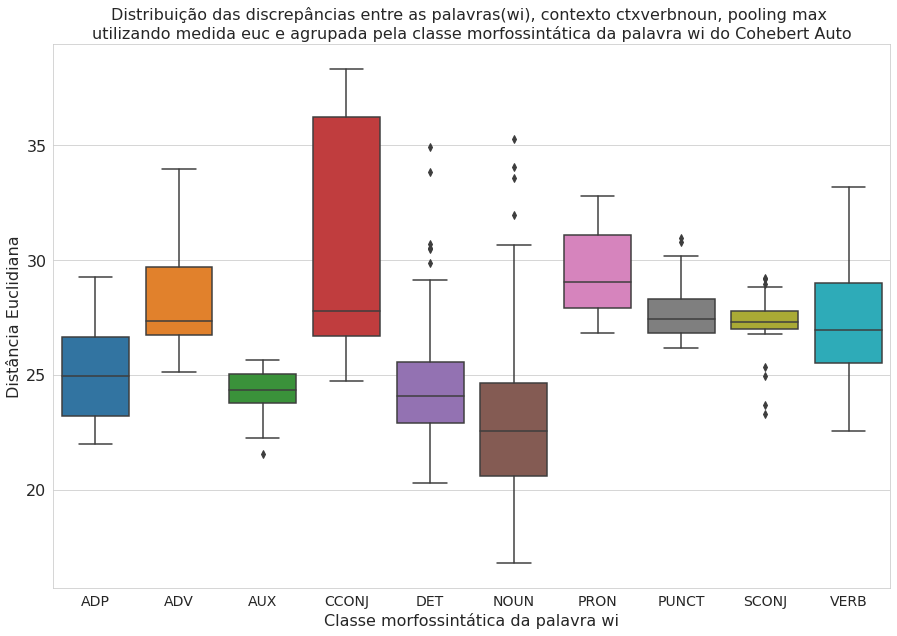

In [189]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do Cohebert Auto")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Distância Euclidiana")

# Mostra o gráfico
plt.show()

#### MAN

In [190]:
medida = "man"

##### MEAN

In [191]:
estrategia_medida = "mean"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [192]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#         avg        std         min         25%         50%  \
pos_i                                                                         
ADP    38.000000 1219.209184 106.570449 1073.391500 1123.014350 1216.699050   
ADV    21.000000 1288.497893 159.160843  915.889100 1239.498000 1350.979700   
AUX    20.000000 1134.526590  49.035867 1027.200800 1113.810025 1141.389950   
CCONJ  28.000000 1292.947986  70.134988 1186.124000 1238.293625 1295.705150   
DET    69.000000 1178.650987 104.087858  990.182600 1106.334200 1158.624300   
NOUN  108.000000  977.633517 118.570648  697.053340  901.420675  966.033520   
PRON   41.000000 1426.755107  88.307749 1299.727700 1358.319100 1393.015900   
PUNCT  40.000000 1367.810160  44.480434 1292.009300 1336.017350 1362.562800   
SCONJ  23.000000 1325.854239  69.533712 1142.793600 1317.557650 1340.675500   
VERB   46.000000  869.365683 144.405540  655.001040  785.531113  835.677175   

              75%         max  
pos_i                          
ADP   1297.629050 1415.192900  
ADV   1357.541400 1516.637500  
AUX   1159.300625 1211.469000  
CCONJ 1342.536275 1432.428500  
DET   1222.434300 1480.914400  
NOUN  1063.882475 1236.895300  
PRON  1510.818100 1563.725700  
PUNCT 1391.976900 1484.320400  
SCONJ 1373.718700 1398.304800  
VERB   947.866625 1193.968600

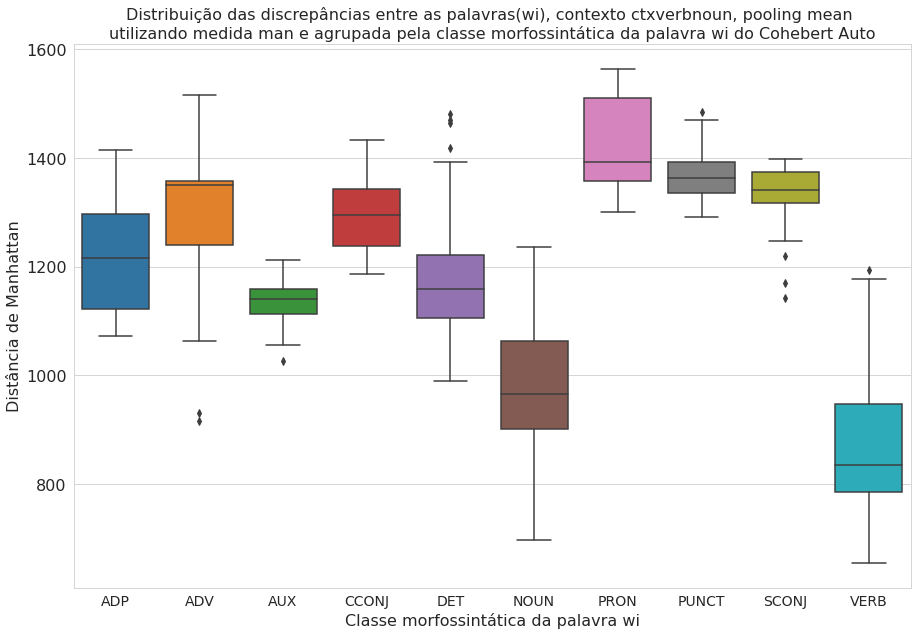

In [193]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do Cohebert Auto")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Distância de Manhattan")

# Mostra o gráfico
plt.show()

##### MAX

In [194]:
estrategia_medida = "max"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [195]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#         avg        std         min         25%         50%  \
pos_i                                                                         
ADP    38.000000 1219.209184 106.570449 1073.391500 1123.014350 1216.699050   
ADV    21.000000 1403.760390 129.006005 1233.769900 1345.700600 1355.591300   
AUX    20.000000 1134.526590  49.035867 1027.200800 1113.810025 1141.389950   
CCONJ  28.000000 1292.947986  70.134988 1186.124000 1238.293625 1295.705150   
DET    69.000000 1198.643706 132.085799 1020.602300 1111.006500 1168.039800   
NOUN  108.000000 1073.501115 155.219401  770.116940  941.427000 1057.011500   
PRON   41.000000 1426.755107  88.307749 1299.727700 1358.319100 1393.015900   
PUNCT  40.000000 1367.810160  44.480434 1292.009300 1336.017350 1362.562800   
SCONJ  23.000000 1325.854239  69.533712 1142.793600 1317.557650 1340.675500   
VERB   46.000000 1327.436465 130.476255 1108.135500 1245.445950 1312.332300   

              75%         max  
pos_i                          
ADP   1297.629050 1415.192900  
ADV   1485.513800 1691.777100  
AUX   1159.300625 1211.469000  
CCONJ 1342.536275 1432.428500  
DET   1232.860000 1714.956900  
NOUN  1161.485100 1609.833100  
PRON  1510.818100 1563.725700  
PUNCT 1391.976900 1484.320400  
SCONJ 1373.718700 1398.304800  
VERB  1406.444075 1659.436400

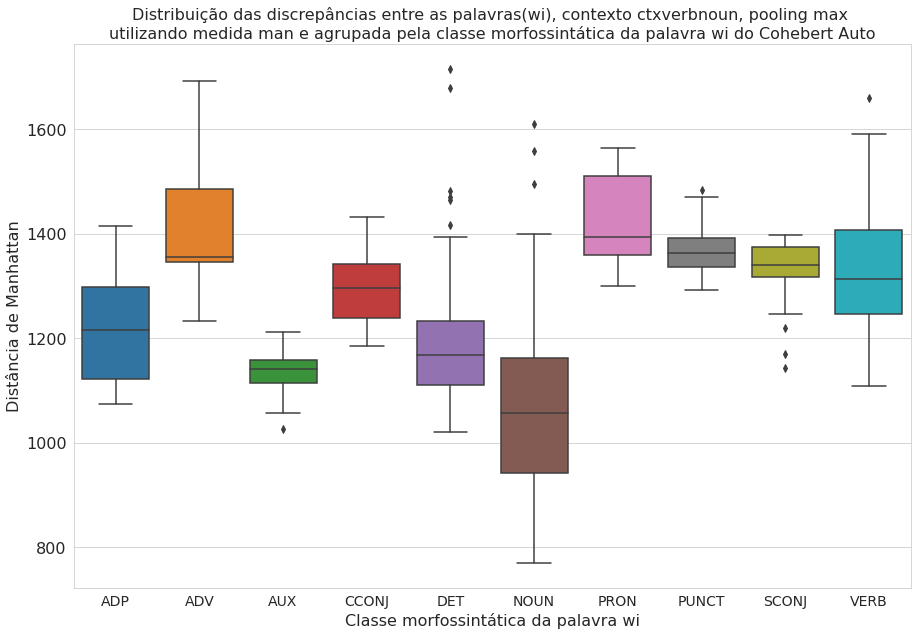

In [196]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do Cohebert Auto")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Distância de Manhattan")

# Mostra o gráfico
plt.show()

## 3.5 Estatísticas das discrepâncias do contexto e palavras

### Geral

Conta pares de classes de palavras

In [197]:
# Import das bibliotecas
import ast
from tqdm.notebook import tqdm as tqdm_notebook
from collections import Counter

# Barra de progresso dos documentos
lista_comparacao_bar = tqdm_notebook(lista_comparacao_contexto.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_comparacao_contexto))

# Contador das palavras
contador = Counter()

# Percorre as comparações
for i, linha_comparacao in lista_comparacao_bar:  
  #if i < 10:             
    contador[linha_comparacao[4]] += 1

Documentos:   0%|          | 0/434 [00:00<?, ? documento/s]

Ordenada as contagens dos pares

In [198]:
top = 10
dicdados = {}
# Lista as ocorrências das palavras
for i, item in enumerate(sorted(contador, key = contador.get, reverse=True)):
  if i < top:
    dicdados.update({item: contador[item]})    

Mostra o gráfico

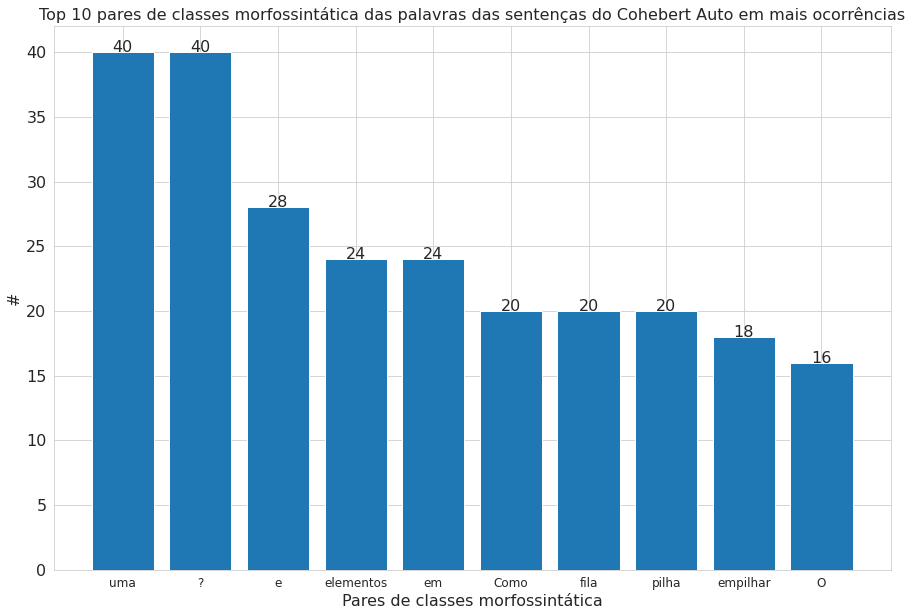

In [199]:
# Import da biblioteca
import matplotlib.pyplot as plt

# Define o tamanho do gráfico 
plt.figure(figsize =(15, 10))

# Recupera os rótulos e os valores
rotulos = list(dicdados.keys())
valores = list(dicdados.values())

# Título do gráfico
plt.title("Top 10 pares de classes morfossintática das palavras das sentenças do Cohebert Auto em mais ocorrências")
# Texto do eixo x
plt.xlabel("Pares de classes morfossintática")
# Texto do eixo y
plt.ylabel("#")

# Insere os dados no gráfico
plt.bar(rotulos, valores)

plt.xticks(fontsize=12)

# Adiciona os rótulos as barras
for i in range(len(valores)):
  plt.annotate(str(valores[i]), xy = (rotulos[i], valores[i]), ha = "center")

# Mostra o gráfico
plt.show()

### Contexto com todas as palavras (ctxall)

#### VERB

In [200]:
classe_morfosintatica = "VERB"

##### Estatísticas

Filtrar comparação contexto com verbos

In [201]:
lista_comparacao_classes = lista_comparacao_contexto[(lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]

lista_comparacao_classesVV = lista_comparacao_classes

print("Comparações:", len(lista_comparacao_classes))

Comparações: 46


Estatísticas das medidas dos contextos e palavras

In [202]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("precision", 6)

# Exibe as estatísticas
lista_comparacao_classes[["cos_ctxall_mean" ,"euc_ctxall_mean",
                          "man_ctxall_max"  ,"cos_ctxall_max",
                          "euc_ctxall_max"  ,"man_ctxall_max"]].describe(include=["float", "int"]) 

cos_ctxall_mean  euc_ctxall_mean  man_ctxall_max  cos_ctxall_max  \
count        46.000000        46.000000       46.000000       46.000000   
mean          0.893063        16.323555     1292.607948        0.766929   
std           0.053817         5.069324      121.039702        0.038060   
min           0.775444        10.615781     1050.928200        0.668772   
25%           0.879507        13.399829     1211.493425        0.737689   
50%           0.907349        14.850517     1297.671200        0.768354   
75%           0.926397        16.606049     1357.816175        0.790019   
max           0.957184        28.985649     1618.837900        0.849577   

       euc_ctxall_max  man_ctxall_max  
count       46.000000       46.000000  
mean        26.280428     1292.607948  
std          2.489502      121.039702  
min         20.644423     1050.928200  
25%         24.632038     1211.493425  
50%         26.440045     1297.671200  
75%         28.099047     1357.816175  
max         31.910425     1618.837900

##### Top 20

Top 20 palavras(wi) em mais ocorrências nas comparações de pos(wi) do tipo VERB

In [203]:
# Import das bibliotecas
import ast
from tqdm.notebook import tqdm as tqdm_notebook
from collections import Counter

# Barra de progresso dos documentos
lista_comparacao_classes_bar = tqdm_notebook(lista_comparacao_classes.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_comparacao_classes))

# Contador das palavras
contador = Counter()

# Percorre as comparações
for i, linha_comparacao in lista_comparacao_classes_bar:  
  #if i < 10:             
    contador[linha_comparacao[3]] += 1

Documentos:   0%|          | 0/46 [00:00<?, ? documento/s]

In [204]:
top = 20
lista = []
# Lista as ocorrências das palavras
for i, item in enumerate(sorted(contador, key = contador.get, reverse=True)):
  if i < top:
    lista.append([i+1, item, contador[item]])      

In [205]:
# Converte em um dataFrame
df1 = pd.DataFrame(lista, columns=("ranque", "palavra", "#wi"))

# Motra o rank
print(df1.to_string(index=False))

 ranque  palavra  #wi
      1        7   16
      2        1   12
      3        6    8
      4        3    4
      5        2    4
      6        8    2


##### COS - MEAN

In [206]:
medida = "cos_ctxall_mean"

Documentos outliers

In [207]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 0.04688939452171326
Limite superior             : 0.9967306554317474
Limite inferior             : 0.8091730773448944


Encontra os documentos com as maiores similaridades (cos(wi,contexto) < limite_inferior)

In [208]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 0 de 46 ( 0.0 )


Encontra os documentos com as maiores discrepâncias (cos(wi,contexto) > limite_superior)

In [209]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 8 de 46 ( 0.17391304347826086 )


In [210]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  8 de 46 ( 0.17391304347826086 )


###### Top 5 documentos com as maiores similaridades (cos(wi,ctxall) > limite_superior) entre palavras da classe VERB e o contexto de todas as palavras.

In [211]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxall) < limite_inferior) entre palavras da classe VERB e o contexto de todas as palavras.

In [212]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 0.7754440903663635 implementadas
         Como são implementadas as operações de enfileirar e desenfileirar elementos em uma fila?

 2 0.7837890982627869 implementadas
         Como são implementadas as operações de empilhar e desempilhar elementos em uma fila ?

 3 0.7865517735481262 ocorre
         Em uma pilha a operação de enfileirar ocorre em qual extremidade ?

 4 0.7881106734275818 ocorre
         Em uma fila a operação de enfileirar ocorre em qual extremidade?

 5 0.7886267304420471 implementadas
         Como são implementadas as operações de enfileirar e desenfileirar elementos em uma pilha ?


###### Top 5 documentos com as discrepâncias (cos(wi,ctxall) < limite_inferior) entre palavras da classe VERB e o contexto de todas as palavras e a lista das palavras em ordem de discrepâncias.

In [213]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes = lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 Como são implementadas as operações de empilhar e desempilhar elementos em uma pilha?
       1 0.8998832106590271 empilhar
       2 0.8653181195259094 desempilhar
       3 0.7936985492706299 implementadas

 2 Em uma pilha a operação de empilhar ocorre em qual extremidade?
       1 0.876401960849762 empilhar
       2 0.7903953194618225 ocorre

 3 Em uma fila a operação de empilhar ocorre em qual extremidade ?
       1 0.8636415004730225 empilhar
       2 0.7888890504837036 ocorre

 4 Como são implementadas as operações de enfileirar e desenfileirar elementos em uma pilha ?
       1 0.9057942628860474 enfileirar
       2 0.7886267304420471 implementadas

 5 Em uma fila a operação de enfileirar ocorre em qual extremidade?
       1 0.8888227939605713 enfileirar
       2 0.7881106734275818 ocorre


##### COS - MAX

In [214]:
medida = "cos_ctxall_max"

Documentos outliers

In [215]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 0.05232931673526764
Limite superior             : 0.8685127273201942
Limite inferior             : 0.6591954603791237


Encontra os documentos com as maiores similaridades (cos(wi,contexto) < limite_inferior)

In [216]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 0 de 46 ( 0.0 )


Encontra os documentos com as maiores discrepâncias (cos(wi,contexto) > limite_superior)

In [217]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 46 ( 0.0 )


In [218]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  0 de 46 ( 0.0 )


###### Top 5 documentos com as maiores similaridades (cos(wi,ctxall) > limite_superior) entre palavras da classe VERB e o contexto de todas as palavras.

In [219]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxall) < limite_inferior) entre palavras da classe VERB e o contexto de todas as palavras.

In [220]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as discrepâncias (cos(wi,ctxall) < limite_inferior) entre palavras da classe VERB e o contexto de todas as palavras e a lista das palavras em ordem de discrepâncias.

In [221]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1

##### EUC - MEAN

In [222]:
medida = "euc_ctxall_mean"

Documentos outliers

In [223]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 3.2062201499938965
Limite superior             : 21.4153790473938
Limite inferior             : 8.590498447418213


Encontra os documentos com as maiores discrepâncias (euc(wi,contexto) > limite_superior)

In [224]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 8 de 46 ( 0.17391304347826086 )


Encontra os documentos com as maiores similaridades (euc(wi,contexto) < limite_inferior)

In [225]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 46 ( 0.0 )


In [226]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  8 de 46 ( 0.17391304347826086 )


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxall) > limite_superior) entre palavras da classe VERB e o contexto de todas as palavras.


In [227]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 28.98564910888672 ocorre
         Em uma pilha a operação de enfileirar ocorre em qual extremidade ?

 2 28.744054794311523 ocorre
         Em uma fila a operação de enfileirar ocorre em qual extremidade?

 3 28.467384338378903 ocorre
         Em uma fila a operação de empilhar ocorre em qual extremidade ?

 4 27.961322784423828 ocorre
         Em uma pilha a operação de empilhar ocorre em qual extremidade?

 5 24.77916145324707 implementadas
         Como são implementadas as operações de enfileirar e desenfileirar elementos em uma fila?


###### Top 5 documentos com as maiores similaridades (euc(wi,ctxall) < limite_superior) entre palavras da classe VERB e o contexto de todas as palavras.


In [228]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxall) > limite_superior) entre palavras da classe VERB e o contexto de todas as palavras e a lista das palavras em ordem de discrepâncias.

In [229]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 Em uma pilha a operação de enfileirar ocorre em qual extremidade ?
       1 28.98564910888672 ocorre
       2 15.982599258422852 enfileirar

 2 Em uma fila a operação de enfileirar ocorre em qual extremidade?
       1 28.744054794311523 ocorre
       2 15.988921165466309 enfileirar

 3 Em uma fila a operação de empilhar ocorre em qual extremidade ?
       1 28.467384338378903 ocorre
       2 17.658527374267578 empilhar

 4 Em uma pilha a operação de empilhar ocorre em qual extremidade?
       1 27.961322784423828 ocorre
       2 16.811758041381836 empilhar

 5 Como são implementadas as operações de enfileirar e desenfileirar elementos em uma fila?
       1 24.77916145324707 implementadas
       2 14.539591789245604 enfileirar


##### EUC - MAX

In [230]:
medida = "euc_ctxall_max"

Documentos outliers

In [231]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 3.467009067535397
Limite superior             : 33.299560308456414
Limite inferior             : 19.431524038314826


Encontra os documentos com as maiores discrepâncias (euc(wi,contexto) > limite_superior)

In [232]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 0 de 46 ( 0.0 )


Encontra os documentos com as maiores similaridades (euc(wi,contexto) < limite_inferior)

In [233]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 46 ( 0.0 )


In [234]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  0 de 46 ( 0.0 )


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxall) > limite_superior) entre palavras da classe VERB e o contexto de todas as palavras.


In [235]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores similaridades (euc(wi,ctxall) < limite_superior) entre palavras da classe VERB e o contexto de todas as palavras.


In [236]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxall) > limite_superior) entre palavras da classe VERB e o contexto de todas as palavras e a lista das palavras em ordem de discrepâncias.

In [237]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1

##### MAN - MEAN

In [238]:
medida = "man_ctxall_mean"

Documentos outliers

In [239]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 175.65968499999997
Limite superior             : 1089.6472675
Limite inferior             : 387.00852750000007


Encontra os documentos com as maiores discrepâncias (man(wi,contexto) > limite_superior)

In [240]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 8 de 46 ( 0.17391304347826086 )


Encontra os documentos com as maiores similaridades (man(wi,wj) < limite_inferior)

In [241]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 46 ( 0.0 )


In [242]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  8 de 46 ( 0.17391304347826086 )


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxall) > limite_superior) entre palavras da classe VERB e o contexto de todas as palavras.

In [243]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 1354.7129 ocorre
         Em uma pilha a operação de enfileirar ocorre em qual extremidade ?

 2 1332.9752 ocorre
         Em uma fila a operação de enfileirar ocorre em qual extremidade?

 3 1328.2142 ocorre
         Em uma fila a operação de empilhar ocorre em qual extremidade ?

 4 1317.3953 ocorre
         Em uma pilha a operação de empilhar ocorre em qual extremidade?

 5 1184.3247 implementadas
         Como são implementadas as operações de enfileirar e desenfileirar elementos em uma fila?


###### Top 5 documentos com as maiores similaridades (man(wi,ctxall) < limite_inferior) entre palavras da classe VERB e o contexto de todas as palavras.

In [244]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxall) > limite_superior) entre palavras da classe VERB e o contexto de todas as palavras e a lista das palavras em ordem de discrepâncias.

In [245]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 Em uma pilha a operação de enfileirar ocorre em qual extremidade ?
       1 1354.7129 ocorre
       2 792.93256 enfileirar

 2 Em uma fila a operação de enfileirar ocorre em qual extremidade?
       1 1332.9752 ocorre
       2 792.5985 enfileirar

 3 Em uma fila a operação de empilhar ocorre em qual extremidade ?
       1 1328.2142 ocorre
       2 881.0465 empilhar

 4 Em uma pilha a operação de empilhar ocorre em qual extremidade?
       1 1317.3953 ocorre
       2 837.2328 empilhar

 5 Como são implementadas as operações de enfileirar e desenfileirar elementos em uma fila?
       1 1184.3247 implementadas
       2 710.4276 enfileirar


##### MAN - MAX

In [246]:
medida = "man_ctxall_max"

Documentos outliers

In [247]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 146.32275000000004
Limite superior             : 1577.3002999999999
Limite inferior             : 992.0092999999998


Encontra os documentos com as maiores discrepâncias (man(wi,contexto) > limite_superior)

In [248]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 1 de 46 ( 0.021739130434782608 )


Encontra os documentos com as maiores similaridades (man(wi,wj) < limite_inferior)

In [249]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 46 ( 0.0 )


In [250]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  1 de 46 ( 0.021739130434782608 )


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxall) > limite_superior) entre palavras da classe VERB e o contexto de todas as palavras.

In [251]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 1618.8379 desempilhar
         Como são implementadas as operações de empilhar e desempilhar elementos em uma pilha?


###### Top 5 documentos com as maiores similaridades (man(wi,ctxall) < limite_inferior) entre palavras da classe VERB e o contexto de todas as palavras.

In [252]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxall) > limite_superior) entre palavras da classe VERB e o contexto de todas as palavras e a lista das palavras em ordem de discrepâncias.

In [253]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 Como são implementadas as operações de empilhar e desempilhar elementos em uma pilha?
       1 1618.8379 desempilhar
       2 1333.1119 implementadas
       3 1266.0807 empilhar


#### NOUN

In [254]:
classe_morfosintatica = "NOUN"

##### Estatísticas

Filtrar comparação contexto com verbos

In [255]:
lista_comparacao_classes = lista_comparacao_contexto[(lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]

lista_comparacao_classesNN = lista_comparacao_classes

print("Comparações:", len(lista_comparacao_classes))

Comparações: 108


Estatísticas das medidas dos contextos e palavras

In [256]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("precision", 6)

# Exibe as estatísticas
lista_comparacao_classes[["cos_ctxall_mean","euc_ctxall_mean","man_ctxall_mean", "cos_ctxall_max","euc_ctxall_max","man_ctxall_max"]].describe(include=["float", "int"]) 

cos_ctxall_mean  euc_ctxall_mean  man_ctxall_mean  cos_ctxall_max  \
count       108.000000       108.000000       108.000000      108.000000   
mean          0.808041        24.261539      1116.128691        0.783477   
std           0.047006         4.978141       185.761908        0.029948   
min           0.733532        11.953954       583.641850        0.686115   
25%           0.768442        21.326224      1011.632858        0.762020   
50%           0.805519        24.944664      1146.856650        0.780524   
75%           0.833498        27.752695      1268.933250        0.810559   
max           0.944496        39.752243      1403.067900        0.850094   

       euc_ctxall_max  man_ctxall_max  
count      108.000000      108.000000  
mean        26.174660     1212.967062  
std          3.248101      114.397284  
min         20.534048      970.301760  
25%         24.302133     1136.752075  
50%         25.659441     1215.953450  
75%         27.995468     1294.611450  
max         39.752243     1593.325400

##### Top 20

Top 20 palavras(wi) em mais ocorrências nas comparações de pos(wi) do tipo NOUN e pos(wj) do tipo NOUN

In [257]:
# Import das bibliotecas
import ast
from tqdm.notebook import tqdm as tqdm_notebook
from collections import Counter

# Barra de progresso dos documentos
lista_comparacao_classes_bar = tqdm_notebook(lista_comparacao_classes.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_comparacao_classes))

# Contador das palavras
contador = Counter()

# Percorre as comparações
for i, linha_comparacao in lista_comparacao_classes_bar:  
  #if i < 10:             
    contador[linha_comparacao[3]] += 1

Documentos:   0%|          | 0/108 [00:00<?, ? documento/s]

In [258]:
top = 20
lista = []
# Lista as ocorrências das palavras
for i, item in enumerate(sorted(contador, key = contador.get, reverse=True)):
  if i < top:
    lista.append([i+1, item, contador[item]])      

In [259]:
# Converte em um dataFrame
df1 = pd.DataFrame(lista, columns=("ranque", "palavra", "#wi"))

# Motra o rank
print(df1.to_string(index=False))

 ranque  palavra  #wi
      1        4   28
      2        9   20
      3        2   16
      4        5   12
      5        7   10
      6       10    6
      7        8    4
      8        1    4
      9       11    4
     10       12    4


##### COS - MEAN

In [260]:
medida = "cos_ctxall_mean"

Documentos outliers

In [261]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 0.06505577266216278
Limite superior             : 0.9310812428593636
Limite inferior             : 0.6708581522107124


Encontra os documentos com as maiores similaridades (cos(wi,contexto) > limite_superior)

In [262]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 2 de 108 ( 0.018518518518518517 )


Encontra os documentos com as maiores discrepâncias (cos(wi,contexto) < limite_inferior)

In [263]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 108 ( 0.0 )


In [264]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)
print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  2 de 108 ( 0.018518518518518517 )


###### Top 5 documentos com as maiores similaridades (cos(wi,ctxall) > limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras.

In [265]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 0.9444961547851562 desempilhar
         Como desempilhar elementos em uma fila ?

 2 0.9426923394203186 desempilhar
         Como desempilhar elementos em uma pilha?


###### Top 5 documentos com as maiores similaridades (cos(wi,ctxall) > limite_inferior) entre palavras da classe NOUN e o contexto de todas as palavras.


In [266]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxall) < limite_inferior) entre palavras da classe NOUN e o contexto de todas as palavras e a lista das palavras em ordem de discrepâncias.

In [267]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1

##### COS - MAX

In [268]:
medida = "cos_ctxall_max"

Documentos outliers

In [269]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 0.0485396683216095
Limite superior             : 0.8833689540624619
Limite inferior             : 0.6892102807760239


Encontra os documentos com as maiores similaridades (cos(wi,contexto) > limite_superior)

In [270]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 0 de 108 ( 0.0 )


Encontra os documentos com as maiores discrepâncias (cos(wi,contexto) < limite_inferior)

In [271]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 1 de 108 ( 0.009259259259259259 )


In [272]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)
print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  1 de 108 ( 0.009259259259259259 )


###### Top 5 documentos com as maiores similaridades (cos(wi,ctxall) > limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras.

In [273]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores similaridades (cos(wi,ctxall) > limite_inferior) entre palavras da classe NOUN e o contexto de todas as palavras.


In [274]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 0.6861150860786438 desempilhar
         O que é uma pilha e como empilhar e desempilhar seus elementos?


###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxall) < limite_inferior) entre palavras da classe NOUN e o contexto de todas as palavras e a lista das palavras em ordem de discrepâncias.

In [275]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 O que é uma pilha e como empilhar e desempilhar seus elementos?
       1 0.75799959897995 elementos
       2 0.7509679198265076 pilha
       3 0.6861150860786438 desempilhar


##### EUC - MEAN

In [276]:
medida = "euc_ctxall_mean"

Documentos outliers

In [277]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 6.4264702796936
Limite superior             : 37.392400026321404
Limite inferior             : 11.686518907547002


Encontra os documentos com as maiores discrepâncias (euc(wi,contexto) > limite_superior)

In [278]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior:", len(lista_comparacao_outliers_superior))

Outliers superior: 2


Encontra os documentos com as maiores similaridades (euc(wi,contexto) < limite_inferior)

In [279]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 108 ( 0.0 )


In [280]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)
print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  2 de 108 ( 0.018518518518518517 )


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxall) > limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras.

In [281]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 39.75224304199219 pilha
         Como empilhar e desempilhar elementos em uma estrutura de dados pilha?

 2 38.4000129699707 pilha
         Como desempilhar elementos em uma estrutura de dados pilha?


###### Top 5 documentos com as maiores similaridades (euc(wi,ctxall) < limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras.


In [282]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxall) > limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras e a lista das palavras em ordem de discrepâncias.

In [283]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 Como empilhar e desempilhar elementos em uma estrutura de dados pilha?
       1 39.75224304199219 pilha
       2 24.3533878326416 dados
       3 23.077512741088867 elementos
       4 22.584997177124023 estrutura

 2 Como desempilhar elementos em uma estrutura de dados pilha?
       1 38.4000129699707 pilha
       2 23.37607192993164 dados
       3 21.37884521484375 elementos
       4 21.112586975097656 estrutura
       5 14.263941764831545 desempilhar


##### EUC - MAX

In [284]:
medida = "euc_ctxall_max"

Documentos outliers

In [285]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 3.6933345794677734
Limite superior             : 33.53546953201294
Limite inferior             : 18.762131214141846


Encontra os documentos com as maiores discrepâncias (euc(wi,contexto) > limite_superior)

In [286]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior:", len(lista_comparacao_outliers_superior))

Outliers superior: 3


Encontra os documentos com as maiores similaridades (euc(wi,contexto) < limite_inferior)

In [287]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 108 ( 0.0 )


In [288]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)
print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  3 de 108 ( 0.027777777777777776 )


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxall) > limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras.

In [289]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 39.75224304199219 pilha
         Como empilhar e desempilhar elementos em uma estrutura de dados pilha?

 2 38.4000129699707 pilha
         Como desempilhar elementos em uma estrutura de dados pilha?

 3 37.14054870605469 pilha
         Como empilhar elementos em uma estrutura de dados pilha?


###### Top 5 documentos com as maiores similaridades (euc(wi,ctxall) < limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras.


In [290]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxall) > limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras e a lista das palavras em ordem de discrepâncias.

In [291]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 Como empilhar e desempilhar elementos em uma estrutura de dados pilha?
       1 39.75224304199219 pilha
       2 24.3533878326416 dados
       3 23.077512741088867 elementos
       4 22.584997177124023 estrutura

 2 Como desempilhar elementos em uma estrutura de dados pilha?
       1 38.4000129699707 pilha
       2 25.60632705688477 desempilhar
       3 23.37607192993164 dados
       4 21.37884521484375 elementos
       5 21.112586975097656 estrutura

 3 Como empilhar elementos em uma estrutura de dados pilha?
       1 37.14054870605469 pilha
       2 22.65502166748047 elementos
       3 22.49368476867676 dados
       4 20.534048080444336 estrutura


##### MAN - MEAN

In [292]:
medida = "man_ctxall_mean"

Documentos outliers

In [293]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 257.30039250000004
Limite superior             : 1654.88383875
Limite inferior             : 625.6822687499999


Encontra os documentos com as maiores discrepâncias (man(wi,contexto) > limite_superior)

In [294]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior:", len(lista_comparacao_outliers_superior))

Outliers superior: 0


Encontra os documentos com as maiores similaridades (man(wi,contexto) < limite_inferior)

In [295]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 2 de 108 ( 0.018518518518518517 )


In [296]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  2 de 108 ( 0.018518518518518517 )


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxall) > limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras.

In [297]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores similaridades (man(wi,ctxall) < limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras.

In [298]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 583.64185 desempilhar
         Como desempilhar elementos em uma pilha?

 2 589.0491 desempilhar
         Como desempilhar elementos em uma fila ?


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxall) > limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras e a lista das palavras em ordem de discrepâncias.

In [299]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1

##### MAN - MAX

In [300]:
medida = "man_ctxall_max"

Documentos outliers

In [301]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 157.85937499999977
Limite superior             : 1531.4005124999994
Limite inferior             : 899.9630125000004


Encontra os documentos com as maiores discrepâncias (man(wi,contexto) > limite_superior)

In [302]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior:", len(lista_comparacao_outliers_superior))

Outliers superior: 2


Encontra os documentos com as maiores similaridades (man(wi,contexto) < limite_inferior)

In [303]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 108 ( 0.0 )


In [304]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  2 de 108 ( 0.018518518518518517 )


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxall) > limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras.

In [305]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 1593.3254 desempilhar
         O que é uma pilha e como empilhar e desempilhar seus elementos?

 2 1543.265 desempilhar
         O que é uma fila e como empilhar e desempilhar seus elementos ?


###### Top 5 documentos com as maiores similaridades (man(wi,ctxall) < limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras.

In [306]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxall) > limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras e a lista das palavras em ordem de discrepâncias.

In [307]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 O que é uma pilha e como empilhar e desempilhar seus elementos?
       1 1593.3254 desempilhar
       2 1269.6765 elementos
       3 1150.332 pilha

 2 O que é uma fila e como empilhar e desempilhar seus elementos ?
       1 1543.265 desempilhar
       2 1311.0314 elementos
       3 1244.8943 fila


#### Comparando discrepância entre o contexto de todas as palavras e palavras de todas as classes, VERB(AUX) e NOUN.

##### COS, EUC, MAN

In [308]:
df_all = pd.concat([lista_comparacao_contexto[["cos_ctxall_mean","euc_ctxall_mean","man_ctxall_mean"]],
                    lista_comparacao_classesVV[["cos_ctxall_mean","euc_ctxall_mean","man_ctxall_mean"]], 
                    lista_comparacao_classesNN[["cos_ctxall_mean","euc_ctxall_mean","man_ctxall_mean"]],
                    ], 
                    axis="columns", 
                   keys=["Geral", "VERB", "NOUN"])

df_all.describe(include=["float", "int"]) 

Geral                                            VERB  \
      cos_ctxall_mean euc_ctxall_mean man_ctxall_mean cos_ctxall_mean   
count      434.000000      434.000000      434.000000       46.000000   
mean         0.809036       22.545367     1079.184534        0.893063   
std          0.097198        4.498635      181.745434        0.053817   
min          0.182750       10.615781      523.811300        0.775444   
25%          0.784972       20.726692     1012.812490        0.879507   
50%          0.816715       22.453432     1096.618300        0.907349   
75%          0.842142       24.581079     1176.546525        0.926397   
max          0.957184       39.752243     1487.845600        0.957184   

                                                 NOUN                  \
      euc_ctxall_mean man_ctxall_mean cos_ctxall_mean euc_ctxall_mean   
count       46.000000       46.000000      108.000000      108.000000   
mean        16.323555      793.102282        0.808041       24.261539   
std          5.069324      230.874340        0.047006        4.978141   
min         10.615781      523.811300        0.733532       11.953954   
25%         13.399829      650.498055        0.768442       21.326224   
50%         14.850517      728.308000        0.805519       24.944664   
75%         16.606049      826.157740        0.833498       27.752695   
max         28.985649     1354.712900        0.944496       39.752243   

                       
      man_ctxall_mean  
count      108.000000  
mean      1116.128691  
std        185.761908  
min        583.641850  
25%       1011.632858  
50%       1146.856650  
75%       1268.933250  
max       1403.067900

##### COS

In [309]:
df_all = pd.concat([lista_comparacao_contexto[["cos_ctxall_mean"]],                    
                    lista_comparacao_classesVV[["cos_ctxall_mean"]], 
                    lista_comparacao_classesNN[["cos_ctxall_mean"]],
                    ], 
                    axis="columns", 
                    keys=["Geral", "VERB", "NOUN"])

df_all.describe(include=["float", "int"]) 

Geral            VERB            NOUN
      cos_ctxall_mean cos_ctxall_mean cos_ctxall_mean
count      434.000000       46.000000      108.000000
mean         0.809036        0.893063        0.808041
std          0.097198        0.053817        0.047006
min          0.182750        0.775444        0.733532
25%          0.784972        0.879507        0.768442
50%          0.816715        0.907349        0.805519
75%          0.842142        0.926397        0.833498
max          0.957184        0.957184        0.944496

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


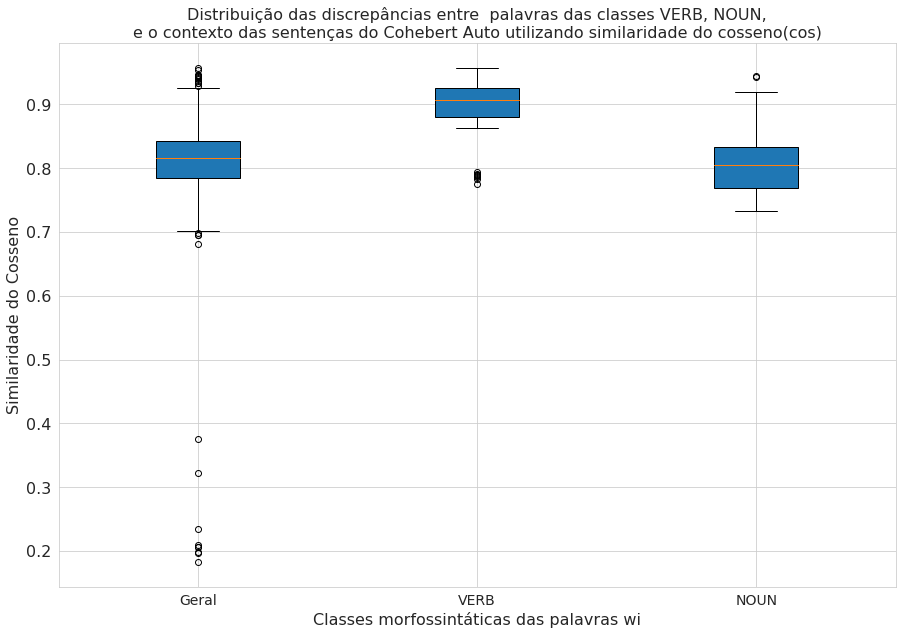

In [310]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Define o tamanho do gráfico 
fig, ax = plt.subplots(figsize =(15, 10))

# Estilo do gráfico
sns.set_style("whitegrid")

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre  palavras das classes VERB, NOUN,\ne o contexto das sentenças do Cohebert Auto utilizando similaridade do cosseno(cos)")
# Texto do eixo x
plt.xlabel("Classes morfossintáticas das palavras wi")
# Texto do eixo y
plt.ylabel("Similaridade do Cosseno")

colunas = [lista_comparacao_contexto[["cos_ctxall_mean"]], lista_comparacao_classesVV[["cos_ctxall_mean"]], lista_comparacao_classesNN[["cos_ctxall_mean"]]]
ax.boxplot(colunas, patch_artist=True)

# Rótulos para os boxplots
plt.xticks([1, 2, 3], ["Geral", "VERB", "NOUN"])

plt.show()

##### EUC

In [311]:
df_all = pd.concat([lista_comparacao_contexto[["euc_ctxall_mean"]],
                    lista_comparacao_classesVV[["euc_ctxall_mean"]], 
                    lista_comparacao_classesNN[["euc_ctxall_mean"]],                    
                    ], 
                    axis="columns", 
                    keys=["Geral", "VERB", "NOUN"])

df_all.describe(include=["float", "int"]) 

Geral            VERB            NOUN
      euc_ctxall_mean euc_ctxall_mean euc_ctxall_mean
count      434.000000       46.000000      108.000000
mean        22.545367       16.323555       24.261539
std          4.498635        5.069324        4.978141
min         10.615781       10.615781       11.953954
25%         20.726692       13.399829       21.326224
50%         22.453432       14.850517       24.944664
75%         24.581079       16.606049       27.752695
max         39.752243       28.985649       39.752243

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


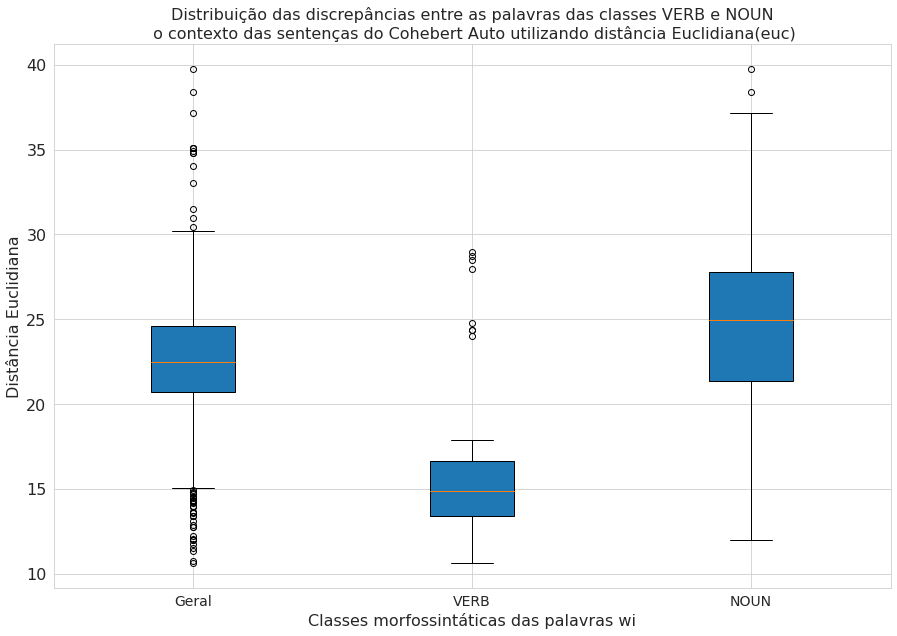

In [312]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Define o tamanho do gráfico 
fig, ax = plt.subplots(figsize =(15, 10))

# Estilo do gráfico
sns.set_style("whitegrid")

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras das classes VERB e NOUN\n o contexto das sentenças do Cohebert Auto utilizando distância Euclidiana(euc)")
# Texto do eixo x
plt.xlabel("Classes morfossintáticas das palavras wi")
# Texto do eixo y
plt.ylabel("Distância Euclidiana")

colunas = [lista_comparacao_contexto[["euc_ctxall_mean"]], lista_comparacao_classesVV[["euc_ctxall_mean"]], lista_comparacao_classesNN[["euc_ctxall_mean"]]]
ax.boxplot(colunas, patch_artist=True)

# Rótulos para os boxplots
plt.xticks([1, 2, 3 ], ["Geral", "VERB", "NOUN"])

plt.show()

##### MAN

In [313]:
df_all = pd.concat([lista_comparacao_contexto[["man_ctxall_mean"]],
                    lista_comparacao_classesVV[["man_ctxall_mean"]], 
                    lista_comparacao_classesNN[["man_ctxall_mean"]],                    
                    ], 
                    axis="columns", 
                    keys=["Geral", "VERB", "NOUN"])

df_all.describe(include=["float", "int"]) 

Geral            VERB            NOUN
      man_ctxall_mean man_ctxall_mean man_ctxall_mean
count      434.000000       46.000000      108.000000
mean      1079.184534      793.102282     1116.128691
std        181.745434      230.874340      185.761908
min        523.811300      523.811300      583.641850
25%       1012.812490      650.498055     1011.632858
50%       1096.618300      728.308000     1146.856650
75%       1176.546525      826.157740     1268.933250
max       1487.845600     1354.712900     1403.067900

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


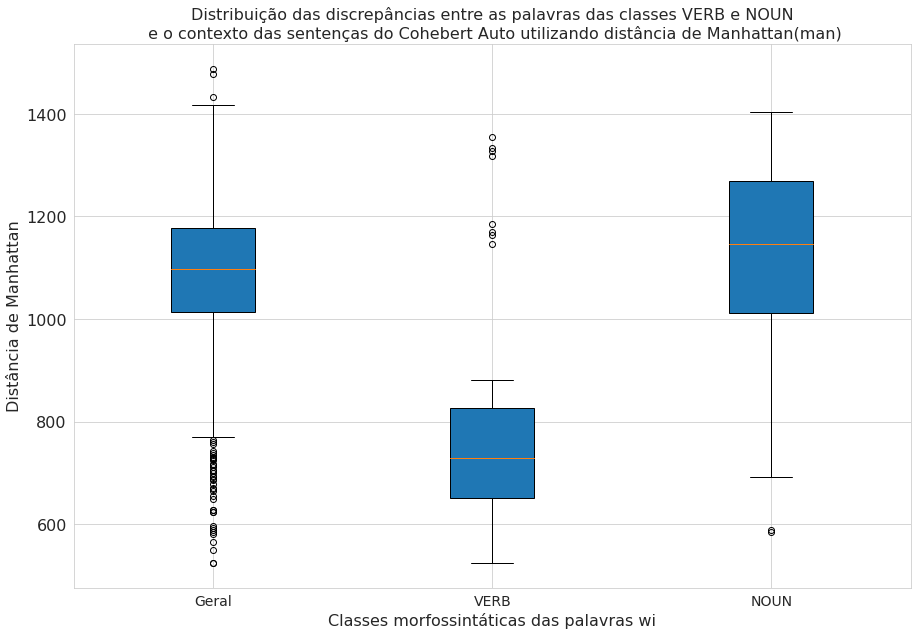

In [314]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Define o tamanho do gráfico 
fig, ax = plt.subplots(figsize =(15, 10))

# Estilo do gráfico
sns.set_style("whitegrid")

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras das classes VERB e NOUN\n e o contexto das sentenças do Cohebert Auto utilizando distância de Manhattan(man)")
# Texto do eixo x
plt.xlabel("Classes morfossintáticas das palavras wi")
# Texto do eixo y
plt.ylabel("Distância de Manhattan")

colunas = [lista_comparacao_contexto[["man_ctxall_mean"]], lista_comparacao_classesVV[["man_ctxall_mean"]], lista_comparacao_classesNN[["man_ctxall_mean"]]]
ax.boxplot(colunas, patch_artist=True)

# Rótulos para os boxplots
plt.xticks([1, 2, 3], ["Geral", "VERB", "NOUN"])

plt.show()

### Contexto com todas as palavras sem stopwords(ctxclean)

#### VERB

In [315]:
classe_morfosintatica = "VERB"

##### Estatísticas

Filtrar comparação contexto com verbos

In [316]:
lista_comparacao_classes = lista_comparacao_contexto[(lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]

lista_comparacao_classesVV = lista_comparacao_classes

print("Comparações:", len(lista_comparacao_classes))

Comparações: 46


Estatísticas das medidas dos contextos e palavras

In [317]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("precision", 6)

# Exibe as estatísticas
lista_comparacao_classes[["cos_ctxclean_mean","euc_ctxclean_mean","cos_ctxclean_max","euc_ctxclean_max","man_ctxclean_max","man_ctxclean_mean"]].describe(include=["float", "int"]) 

cos_ctxclean_mean  euc_ctxclean_mean  cos_ctxclean_max  \
count          46.000000          46.000000         46.000000   
mean            0.870055          18.181810          0.744079   
std             0.034174           3.343464          0.048538   
min             0.795053          13.852944          0.644451   
25%             0.844776          15.953062          0.708674   
50%             0.878028          17.146815          0.743577   
75%             0.898603          19.578509          0.772792   
max             0.923698          25.889809          0.848258   

       euc_ctxclean_max  man_ctxclean_max  man_ctxclean_mean  
count         46.000000         46.000000          46.000000  
mean          27.449556       1332.876183         874.695885  
std            2.359412        120.373245         154.373642  
min           22.535269       1126.992700         672.883540  
25%           25.572046       1254.296550         781.312135  
50%           27.431482       1312.431000         818.506435  
75%           29.034761       1406.279325         947.473330  
max           33.051857       1654.705700        1220.759600

##### Top 20

Top 20 palavras(wi) em mais ocorrências nas comparações de pos(wi) do tipo VERB

In [318]:
# Import das bibliotecas
import ast
from tqdm.notebook import tqdm as tqdm_notebook
from collections import Counter

# Barra de progresso dos documentos
lista_comparacao_classes_bar = tqdm_notebook(lista_comparacao_classes.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_comparacao_classes))

# Contador das palavras
contador = Counter()

# Percorre as comparações
for i, linha_comparacao in lista_comparacao_classes_bar:  
  #if i < 10:             
    contador[linha_comparacao[3]] += 1

Documentos:   0%|          | 0/46 [00:00<?, ? documento/s]

In [319]:
top = 20
lista = []
# Lista as ocorrências das palavras
for i, item in enumerate(sorted(contador, key = contador.get, reverse=True)):
  if i < top:
    lista.append([i+1, item, contador[item]])      

In [320]:
# Converte em um dataFrame
df1 = pd.DataFrame(lista, columns=("ranque", "palavra", "#wi"))

# Motra o rank
print(df1.to_string(index=False))

 ranque  palavra  #wi
      1        7   16
      2        1   12
      3        6    8
      4        3    4
      5        2    4
      6        8    2


##### COS - MEAN

In [321]:
medida = "cos_ctxclean_mean"

Documentos outliers

In [322]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 0.05382700264453888
Limite superior             : 0.9793438836932182
Limite inferior             : 0.7640358731150627


Encontra os documentos com as maiores similaridades (cos(wi,contexto) > limite_superior)

In [323]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 0 de 46 ( 0.0 )


Encontra os documentos com as maiores discrepâncias (cos(wi,contexto) < limite_inferior)

In [324]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 46 ( 0.0 )


In [325]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  0 de 46 ( 0.0 )


###### Top 5 documentos com as maiores similaridades (cos(wi,ctxclean) > limite_superior) entre palavras da classe VERB e o contexto de todas as palavras.

In [326]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxclean) < limite_inferior) entre palavras da classe VERB e o contexto de todas as palavras.

In [327]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxclean) < limite_inferior) entre palavras da classe VERB e o contexto de todas as palavras e a lista das palavras em ordem de discrepâncias.

In [328]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1

##### COS - MAX

In [329]:
medida = "cos_ctxclean_max"

Documentos outliers

In [330]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 0.06411732733249664
Limite superior             : 0.868967778980732
Limite inferior             : 0.6124984696507454


Encontra os documentos com as maiores similaridades (cos(wi,contexto) > limite_superior)

In [331]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 0 de 46 ( 0.0 )


Encontra os documentos com as maiores discrepâncias (cos(wi,contexto) < limite_inferior)

In [332]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 46 ( 0.0 )


In [333]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  0 de 46 ( 0.0 )


###### Top 5 documentos com as maiores similaridades (cos(wi,ctxclean) > limite_superior) entre palavras da classe VERB e o contexto de todas as palavras.

In [334]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxclean) < limite_inferior) entre palavras da classe VERB e o contexto de todas as palavras.

In [335]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxclean) < limite_inferior) entre palavras da classe VERB e o contexto de todas as palavras e a lista das palavras em ordem de discrepâncias.

In [336]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1

##### EUC - MEAN

In [337]:
medida = "euc_ctxclean_mean"

Documentos outliers

In [338]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 3.6254472732543945
Limite superior             : 25.016680240631104
Limite inferior             : 10.514891147613525


Encontra os documentos com as maiores discrepâncias (euc(wi,contexto) > limite_superior)

In [339]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 3 de 46 ( 0.06521739130434782 )


Encontra os documentos com as maiores similaridades (euc(wi,contexto) < limite_inferior)

In [340]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 46 ( 0.0 )


In [341]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  3 de 46 ( 0.06521739130434782 )


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxclean) > limite_superior) entre palavras da classe VERB e o contexto de todas as palavras.


In [342]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 25.88980865478516 ocorre
         Em uma pilha a operação de enfileirar ocorre em qual extremidade ?

 2 25.353496551513672 ocorre
         Em uma pilha a operação de empilhar ocorre em qual extremidade?

 3 25.142955780029297 ocorre
         Em uma fila a operação de empilhar ocorre em qual extremidade ?


###### Top 5 documentos com as maiores similaridades (euc(wi,ctxclean) < limite_superior) entre palavras da classe VERB e o contexto de todas as palavras.


In [343]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxclean) > limite_superior) entre palavras da classe VERB e o contexto de todas as palavras e a lista das palavras em ordem de discrepâncias.

In [344]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 Em uma pilha a operação de enfileirar ocorre em qual extremidade ?
       1 25.88980865478516 ocorre
       2 20.40549659729004 enfileirar

 2 Em uma pilha a operação de empilhar ocorre em qual extremidade?
       1 25.353496551513672 ocorre
       2 19.79294776916504 empilhar

 3 Em uma fila a operação de empilhar ocorre em qual extremidade ?
       1 25.142955780029297 ocorre
       2 19.880470275878903 empilhar


##### EUC - MAX

In [345]:
medida = "euc_ctxclean_max"

Documentos outliers

In [346]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 3.462714672088623
Limite superior             : 34.228832960128784
Limite inferior             : 20.377974271774292


Encontra os documentos com as maiores discrepâncias (euc(wi,contexto) > limite_superior)

In [347]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 0 de 46 ( 0.0 )


Encontra os documentos com as maiores similaridades (euc(wi,contexto) < limite_inferior)

In [348]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 46 ( 0.0 )


In [349]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  0 de 46 ( 0.0 )


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxclean) > limite_superior) entre palavras da classe VERB e o contexto de todas as palavras.


In [350]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores similaridades (euc(wi,ctxclean) < limite_superior) entre palavras da classe VERB e o contexto de todas as palavras.


In [351]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxclean) > limite_superior) entre palavras da classe VERB e o contexto de todas as palavras e a lista das palavras em ordem de discrepâncias.

In [352]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1

##### MAN - MEAN

In [353]:
medida = "man_ctxclean_mean"

Documentos outliers

In [354]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 166.16119500000013
Limite superior             : 1196.7151225000002
Limite inferior             : 532.0703424999997


Encontra os documentos com as maiores discrepâncias (man(wi,contexto) > limite_superior)

In [355]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 2 de 46 ( 0.043478260869565216 )


Encontra os documentos com as maiores similaridades (man(wi,wj) < limite_inferior)

In [356]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 46 ( 0.0 )


In [357]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  2 de 46 ( 0.043478260869565216 )


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxclean) > limite_superior) entre palavras da classe VERB e o contexto de todas as palavras.

In [358]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 1220.7596 ocorre
         Em uma pilha a operação de enfileirar ocorre em qual extremidade ?

 2 1197.041 ocorre
         Em uma pilha a operação de empilhar ocorre em qual extremidade?


###### Top 5 documentos com as maiores similaridades (man(wi,ctxclean) < limite_inferior) entre palavras da classe VERB e o contexto de todas as palavras.

In [359]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxclean) > limite_superior) entre palavras da classe VERB e o contexto de todas as palavras e a lista das palavras em ordem de discrepâncias.

In [360]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 Em uma pilha a operação de enfileirar ocorre em qual extremidade ?
       1 1220.7596 ocorre
       2 974.9752 enfileirar

 2 Em uma pilha a operação de empilhar ocorre em qual extremidade?
       1 1197.041 ocorre
       2 957.8224 empilhar


##### MAN - MAX

In [361]:
medida = "man_ctxclean_max"

Documentos outliers

In [362]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 151.98277499999995
Limite superior             : 1634.2534875
Limite inferior             : 1026.3223875


Encontra os documentos com as maiores discrepâncias (man(wi,contexto) > limite_superior)

In [363]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 1 de 46 ( 0.021739130434782608 )


Encontra os documentos com as maiores similaridades (man(wi,wj) < limite_inferior)

In [364]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 46 ( 0.0 )


In [365]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  1 de 46 ( 0.021739130434782608 )


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxclean) > limite_superior) entre palavras da classe VERB e o contexto de todas as palavras.

In [366]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 1654.7057 desempilhar
         Como são implementadas as operações de empilhar e desempilhar elementos em uma pilha?


###### Top 5 documentos com as maiores similaridades (man(wi,ctxclean) < limite_inferior) entre palavras da classe VERB e o contexto de todas as palavras.

In [367]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxclean) > limite_superior) entre palavras da classe VERB e o contexto de todas as palavras e a lista das palavras em ordem de discrepâncias.

In [368]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 Como são implementadas as operações de empilhar e desempilhar elementos em uma pilha?
       1 1654.7057 desempilhar
       2 1317.4816 empilhar
       3 1302.6589 implementadas


#### NOUN

In [369]:
classe_morfosintatica = "NOUN"

##### Estatísticas

Filtrar comparação contexto com verbos

In [370]:
lista_comparacao_classes = lista_comparacao_contexto[(lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]

lista_comparacao_classesNN = lista_comparacao_classes

print("Comparações:", len(lista_comparacao_classes))

Comparações: 108


Estatísticas das medidas dos contextos e palavras

In [371]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("precision", 6)

# Exibe as estatísticas
lista_comparacao_classes[["cos_ctxclean_mean","euc_ctxclean_mean","cos_ctxclean_max","euc_ctxclean_max","man_ctxclean_max","man_ctxclean_mean"]].describe(include=["float", "int"]) 

cos_ctxclean_mean  euc_ctxclean_mean  cos_ctxclean_max  \
count         108.000000         108.000000        108.000000   
mean            0.852564          21.743624          0.827833   
std             0.019892           3.313682          0.042814   
min             0.805090          15.049207          0.666820   
25%             0.839714          19.931090          0.805339   
50%             0.853680          21.173715          0.843952   
75%             0.867455          23.309369          0.856499   
max             0.910874          35.812756          0.880125   

       euc_ctxclean_max  man_ctxclean_max  man_ctxclean_mean  
count        108.000000        108.000000         108.000000  
mean          23.616702       1102.997194        1008.329189  
std            3.155514        137.463404         109.823918  
min           18.806923        853.086200         738.976800  
25%           21.105685       1001.130638         935.729925  
50%           23.181672       1094.705650        1000.031875  
75%           24.886296       1169.674100        1097.876975  
max           35.812756       1617.785800        1237.825200

##### Top 20

Top 20 palavras(wi) em mais ocorrências nas comparações de pos(wi) do tipo NOUN e pos(wj) do tipo NOUN

In [372]:
# Import das bibliotecas
import ast
from tqdm.notebook import tqdm as tqdm_notebook
from collections import Counter

# Barra de progresso dos documentos
lista_comparacao_classes_bar = tqdm_notebook(lista_comparacao_classes.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_comparacao_classes))

# Contador das palavras
contador = Counter()

# Percorre as comparações
for i, linha_comparacao in lista_comparacao_classes_bar:  
  #if i < 10:             
    contador[linha_comparacao[3]] += 1

Documentos:   0%|          | 0/108 [00:00<?, ? documento/s]

In [373]:
top = 20
lista = []
# Lista as ocorrências das palavras
for i, item in enumerate(sorted(contador, key = contador.get, reverse=True)):
  if i < top:
    lista.append([i+1, item, contador[item]])      

In [374]:
# Converte em um dataFrame
df1 = pd.DataFrame(lista, columns=("ranque", "palavra", "#wi"))

# Motra o rank
print(df1.to_string(index=False))

 ranque  palavra  #wi
      1        4   28
      2        9   20
      3        2   16
      4        5   12
      5        7   10
      6       10    6
      7        8    4
      8        1    4
      9       11    4
     10       12    4


##### COS - MEAN

In [375]:
medida = "cos_ctxclean_mean"

Documentos outliers

In [376]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 0.027741357684135437
Limite superior             : 0.9090670868754387
Limite inferior             : 0.7981016561388969


Encontra os documentos com as maiores similaridades (cos(wi,contexto) > limite_superior)

In [377]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 1 de 108 ( 0.009259259259259259 )


Encontra os documentos com as maiores discrepâncias (cos(wi,contexto) < limite_inferior)

In [378]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 108 ( 0.0 )


In [379]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)
print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  1 de 108 ( 0.009259259259259259 )


###### Top 5 documentos com as maiores similaridades (cos(wi,ctxclean) > limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras.

In [380]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 0.9108737707138062 desempilhar
         Como desempilhar elementos em uma fila ?


###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxclean) < limite_inferior) entre palavras da classe NOUN e o contexto de todas as palavras.


In [381]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxclean) < limite_inferior) entre palavras da classe NOUN e o contexto de todas as palavras e a lista das palavras em ordem de discrepâncias.

In [382]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1

##### COS - MAX

In [383]:
medida = "cos_ctxclean_max"

Documentos outliers

In [384]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 0.05115970969200134
Limite superior             : 0.9332386404275894
Limite inferior             : 0.728599801659584


Encontra os documentos com as maiores similaridades (cos(wi,contexto) > limite_superior)

In [385]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 0 de 108 ( 0.0 )


Encontra os documentos com as maiores discrepâncias (cos(wi,contexto) < limite_inferior)

In [386]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 4 de 108 ( 0.037037037037037035 )


In [387]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)
print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  4 de 108 ( 0.037037037037037035 )


###### Top 5 documentos com as maiores similaridades (cos(wi,ctxclean) > limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras.

In [388]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxclean) < limite_inferior) entre palavras da classe NOUN e o contexto de todas as palavras.


In [389]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 0.66681969165802 desempilhar
         O que é uma pilha e como empilhar e desempilhar seus elementos?

 2 0.695220410823822 desempilhar
         O que é uma fila e como empilhar e desempilhar seus elementos ?

 3 0.7095015048980713 desempilhar
         O que é uma pilha e como desempilhar um elemento nela?

 4 0.7107405066490173 desempilhar
         Como desempilhar elementos em uma estrutura de dados pilha?


###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxclean) < limite_inferior) entre palavras da classe NOUN e o contexto de todas as palavras e a lista das palavras em ordem de discrepâncias.

In [390]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 Como desempilhar elementos em uma estrutura de dados pilha?
       1 0.8649284243583679 elementos
       2 0.8602246046066284 pilha
       3 0.8506597876548767 estrutura
       4 0.8323292136192322 dados
       5 0.7107405066490173 desempilhar

 2 O que é uma pilha e como desempilhar um elemento nela?
       1 0.8558658361434937 elemento
       2 0.8544819355010986 pilha
       3 0.7095015048980713 desempilhar

 3 O que é uma fila e como empilhar e desempilhar seus elementos ?
       1 0.8327928185462952 elementos
       2 0.7742505669593811 fila
       3 0.695220410823822 desempilhar

 4 O que é uma pilha e como empilhar e desempilhar seus elementos?
       1 0.8331366181373596 pilha
       2 0.8306891918182373 elementos
       3 0.66681969165802 desempilhar


##### EUC - MEAN

In [391]:
medida = "euc_ctxclean_mean"

Documentos outliers

In [392]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 3.37827825546265
Limite superior             : 28.376785993576057
Limite inferior             : 14.863672971725455


Encontra os documentos com as maiores discrepâncias (euc(wi,contexto) > limite_superior)

In [393]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior:", len(lista_comparacao_outliers_superior))

Outliers superior: 3


Encontra os documentos com as maiores similaridades (euc(wi,contexto) < limite_inferior)

In [394]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 108 ( 0.0 )


In [395]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)
print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  3 de 108 ( 0.027777777777777776 )


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxclean) > limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras.

In [396]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 35.8127555847168 pilha
         Como empilhar e desempilhar elementos em uma estrutura de dados pilha?

 2 35.004634857177734 pilha
         Como desempilhar elementos em uma estrutura de dados pilha?

 3 34.46815872192383 pilha
         Como empilhar elementos em uma estrutura de dados pilha?


###### Top 5 documentos com as maiores similaridades (euc(wi,ctxclean) < limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras.


In [397]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxclean) > limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras e a lista das palavras em ordem de discrepâncias.

In [398]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 Como empilhar e desempilhar elementos em uma estrutura de dados pilha?
       1 35.8127555847168 pilha
       2 21.599092483520508 dados
       3 21.11241340637207 estrutura
       4 20.86341094970703 elementos

 2 Como desempilhar elementos em uma estrutura de dados pilha?
       1 35.004634857177734 pilha
       2 21.28177833557129 dados
       3 20.56780242919922 estrutura
       4 19.615434646606445 elementos
       5 18.85943031311035 desempilhar

 3 Como empilhar elementos em uma estrutura de dados pilha?
       1 34.46815872192383 pilha
       2 20.97435760498047 elementos
       3 20.80528450012207 dados
       4 20.43767738342285 estrutura


##### EUC - MAX

In [399]:
medida = "euc_ctxclean_max"

Documentos outliers

In [400]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 3.780611038208008
Limite superior             : 30.557212352752686
Limite inferior             : 15.434768199920654


Encontra os documentos com as maiores discrepâncias (euc(wi,contexto) > limite_superior)

In [401]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior:", len(lista_comparacao_outliers_superior))

Outliers superior: 5


Encontra os documentos com as maiores similaridades (euc(wi,contexto) < limite_inferior)

In [402]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 108 ( 0.0 )


In [403]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)
print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  5 de 108 ( 0.046296296296296294 )


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxclean) > limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras.

In [404]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 35.8127555847168 pilha
         Como empilhar e desempilhar elementos em uma estrutura de dados pilha?

 2 35.004634857177734 pilha
         Como desempilhar elementos em uma estrutura de dados pilha?

 3 34.46815872192383 pilha
         Como empilhar elementos em uma estrutura de dados pilha?

 4 32.13943862915039 desempilhar
         O que é uma pilha e como empilhar e desempilhar seus elementos?

 5 30.73666000366211 desempilhar
         O que é uma fila e como empilhar e desempilhar seus elementos ?


###### Top 5 documentos com as maiores similaridades (euc(wi,ctxclean) < limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras.


In [405]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxclean) > limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras e a lista das palavras em ordem de discrepâncias.

In [406]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 Como empilhar e desempilhar elementos em uma estrutura de dados pilha?
       1 35.8127555847168 pilha
       2 21.599092483520508 dados
       3 21.11241340637207 estrutura
       4 20.86341094970703 elementos

 2 Como desempilhar elementos em uma estrutura de dados pilha?
       1 35.004634857177734 pilha
       2 28.527645111083984 desempilhar
       3 21.28177833557129 dados
       4 20.56780242919922 estrutura
       5 19.615434646606445 elementos

 3 Como empilhar elementos em uma estrutura de dados pilha?
       1 34.46815872192383 pilha
       2 20.97435760498047 elementos
       3 20.80528450012207 dados
       4 20.43767738342285 estrutura

 4 O que é uma pilha e como empilhar e desempilhar seus elementos?
       1 32.13943862915039 desempilhar
       2 22.560619354248047 elementos
       3 21.8518180847168 pilha

 5 O que é uma fila e como empilhar e desempilhar seus elementos ?
       1 30.73666000366211 desempilhar
       2 24.567279815673828 fila
       3 24.114324569

##### MAN - MEAN

In [407]:
medida = "man_ctxclean_mean"

Documentos outliers

In [408]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 162.14705000000015
Limite superior             : 1341.0975500000004
Limite inferior             : 692.5093499999998


Encontra os documentos com as maiores discrepâncias (man(wi,contexto) > limite_superior)

In [409]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior:", len(lista_comparacao_outliers_superior))

Outliers superior: 0


Encontra os documentos com as maiores similaridades (man(wi,contexto) < limite_inferior)

In [410]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 108 ( 0.0 )


In [411]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  0 de 108 ( 0.0 )


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxclean) > limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras.

In [412]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores similaridades (man(wi,ctxclean) < limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras.

In [413]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxclean) > limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras e a lista das palavras em ordem de discrepâncias.

In [414]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1

##### MAN - MAX

In [415]:
medida = "man_ctxclean_max"

Documentos outliers

In [416]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 168.54346249999992
Limite superior             : 1422.48929375
Limite inferior             : 748.3154437500002


Encontra os documentos com as maiores discrepâncias (man(wi,contexto) > limite_superior)

In [417]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior:", len(lista_comparacao_outliers_superior))

Outliers superior: 3


Encontra os documentos com as maiores similaridades (man(wi,contexto) < limite_inferior)

In [418]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 108 ( 0.0 )


In [419]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  3 de 108 ( 0.027777777777777776 )


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxclean) > limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras.

In [420]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 1617.7858 desempilhar
         O que é uma pilha e como empilhar e desempilhar seus elementos?

 2 1559.3711 desempilhar
         O que é uma fila e como empilhar e desempilhar seus elementos ?

 3 1515.3376 desempilhar
         O que é uma pilha e como desempilhar um elemento nela?


###### Top 5 documentos com as maiores similaridades (man(wi,ctxclean) < limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras.

In [421]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxclean) > limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras e a lista das palavras em ordem de discrepâncias.

In [422]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 O que é uma pilha e como empilhar e desempilhar seus elementos?
       1 1617.7858 desempilhar
       2 1086.8846 elementos
       3 985.53467 pilha

 2 O que é uma fila e como empilhar e desempilhar seus elementos ?
       1 1559.3711 desempilhar
       2 1191.5267 fila
       3 1119.2704 elementos

 3 O que é uma pilha e como desempilhar um elemento nela?
       1 1515.3376 desempilhar
       2 1078.6517 elemento
       3 933.9047 pilha


#### Comparando discrepância entre o contexto de todas as palavras e palavras de todas as classes, VERB e NOUN.

##### COS, EUC, MAN

In [423]:
df_all = pd.concat([lista_comparacao_contexto[["cos_ctxclean_mean","euc_ctxclean_mean","cos_ctxclean_max","euc_ctxclean_max","man_ctxclean_max","man_ctxclean_mean"]],
                    lista_comparacao_classesVV[["cos_ctxclean_mean","euc_ctxclean_mean","cos_ctxclean_max","euc_ctxclean_max","man_ctxclean_max","man_ctxclean_mean"]], 
                    lista_comparacao_classesNN[["cos_ctxclean_mean","euc_ctxclean_mean","cos_ctxclean_max","euc_ctxclean_max","man_ctxclean_max","man_ctxclean_mean"]],
                    ], 
                    axis="columns", 
                   keys=["Geral", "VERB", "NOUN"])

df_all.describe(include=["float", "int"]) 

Geral                                                      \
      cos_ctxclean_mean euc_ctxclean_mean cos_ctxclean_max euc_ctxclean_max   
count        434.000000        434.000000       434.000000       434.000000   
mean           0.784257         23.907486         0.762148        25.553831   
std            0.111525          4.523539         0.105426         3.686188   
min            0.152244         13.852944         0.152244        18.806923   
25%            0.751316         21.299966         0.736898        23.036346   
50%            0.805256         23.652821         0.778704        24.970947   
75%            0.847642         25.793607         0.826447        27.289695   
max            0.923698         37.613647         0.880125        37.613647   

                                                      VERB                    \
      man_ctxclean_max man_ctxclean_mean cos_ctxclean_mean euc_ctxclean_mean   
count       434.000000        434.000000         46.000000         46.000000   
mean       1218.704918       1136.257946          0.870055         18.181810   
std         160.215061        194.450014          0.034174          3.343464   
min         853.086200        672.883540          0.795053         13.852944   
25%        1113.624450       1024.947675          0.844776         15.953062   
50%        1194.814200       1147.549550          0.878028         17.146815   
75%        1307.499925       1236.004825          0.898603         19.578509   
max        1694.084700       1694.084700          0.923698         25.889809   

                                                                            \
      cos_ctxclean_max euc_ctxclean_max man_ctxclean_max man_ctxclean_mean   
count        46.000000        46.000000        46.000000         46.000000   
mean          0.744079        27.449556      1332.876183        874.695885   
std           0.048538         2.359412       120.373245        154.373642   
min           0.644451        22.535269      1126.992700        672.883540   
25%           0.708674        25.572046      1254.296550        781.312135   
50%           0.743577        27.431482      1312.431000        818.506435   
75%           0.772792        29.034761      1406.279325        947.473330   
max           0.848258        33.051857      1654.705700       1220.759600   

                   NOUN                                                      \
      cos_ctxclean_mean euc_ctxclean_mean cos_ctxclean_max euc_ctxclean_max   
count        108.000000        108.000000       108.000000       108.000000   
mean           0.852564         21.743624         0.827833        23.616702   
std            0.019892          3.313682         0.042814         3.155514   
min            0.805090         15.049207         0.666820        18.806923   
25%            0.839714         19.931090         0.805339        21.105685   
50%            0.853680         21.173715         0.843952        23.181672   
75%            0.867455         23.309369         0.856499        24.886296   
max            0.910874         35.812756         0.880125        35.812756   

                                          
      man_ctxclean_max man_ctxclean_mean  
count       108.000000        108.000000  
mean       1102.997194       1008.329189  
std         137.463404        109.823918  
min         853.086200        738.976800  
25%        1001.130638        935.729925  
50%        1094.705650       1000.031875  
75%        1169.674100       1097.876975  
max        1617.785800       1237.825200

##### COS

In [424]:
df_all = pd.concat([lista_comparacao_contexto[["cos_ctxclean_mean"]],                    
                    lista_comparacao_classesVV[["cos_ctxclean_mean"]], 
                    lista_comparacao_classesNN[["cos_ctxclean_mean"]],
                    ], 
                    axis="columns", 
                    keys=["Geral", "VERB", "NOUN"])

df_all.describe(include=["float", "int"]) 

Geral              VERB              NOUN
      cos_ctxclean_mean cos_ctxclean_mean cos_ctxclean_mean
count        434.000000         46.000000        108.000000
mean           0.784257          0.870055          0.852564
std            0.111525          0.034174          0.019892
min            0.152244          0.795053          0.805090
25%            0.751316          0.844776          0.839714
50%            0.805256          0.878028          0.853680
75%            0.847642          0.898603          0.867455
max            0.923698          0.923698          0.910874

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


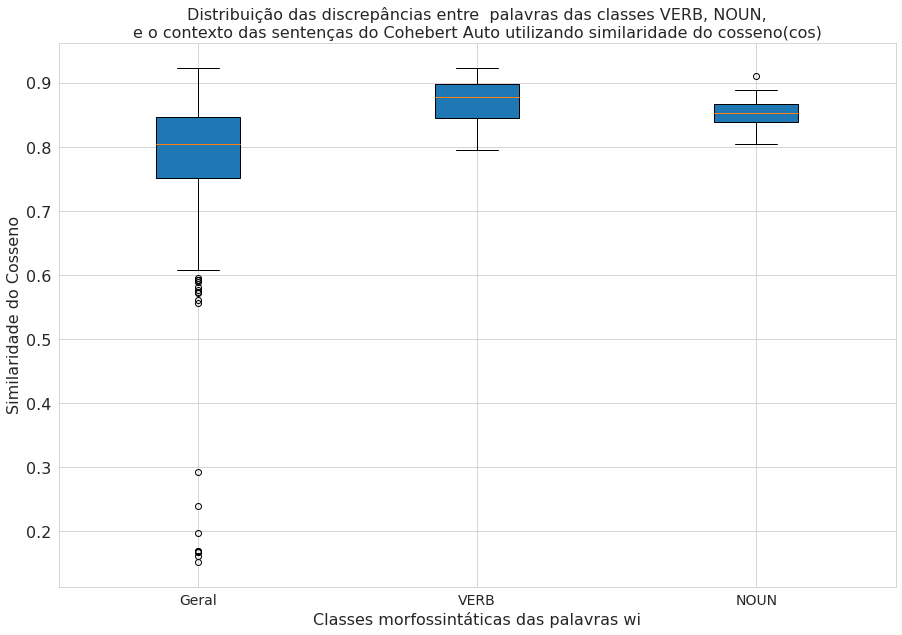

In [425]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Define o tamanho do gráfico 
fig, ax = plt.subplots(figsize =(15, 10))

# Estilo do gráfico
sns.set_style("whitegrid")

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre  palavras das classes VERB, NOUN,\ne o contexto das sentenças do Cohebert Auto utilizando similaridade do cosseno(cos)")
# Texto do eixo x
plt.xlabel("Classes morfossintáticas das palavras wi")
# Texto do eixo y
plt.ylabel("Similaridade do Cosseno")

colunas = [lista_comparacao_contexto[["cos_ctxclean_mean"]], lista_comparacao_classesVV[["cos_ctxclean_mean"]], lista_comparacao_classesNN[["cos_ctxclean_mean"]]]
ax.boxplot(colunas, patch_artist=True)

# Rótulos para os boxplots
plt.xticks([1, 2, 3], ["Geral", "VERB", "NOUN"])

plt.show()

##### EUC

In [426]:
df_all = pd.concat([lista_comparacao_contexto[["euc_ctxclean_mean"]],
                    lista_comparacao_classesVV[["euc_ctxclean_mean"]], 
                    lista_comparacao_classesNN[["euc_ctxclean_mean"]],                    
                    ], 
                    axis="columns", 
                    keys=["Geral", "VERB", "NOUN"])

df_all.describe(include=["float", "int"]) 

Geral              VERB              NOUN
      euc_ctxclean_mean euc_ctxclean_mean euc_ctxclean_mean
count        434.000000         46.000000        108.000000
mean          23.907486         18.181810         21.743624
std            4.523539          3.343464          3.313682
min           13.852944         13.852944         15.049207
25%           21.299966         15.953062         19.931090
50%           23.652821         17.146815         21.173715
75%           25.793607         19.578509         23.309369
max           37.613647         25.889809         35.812756

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


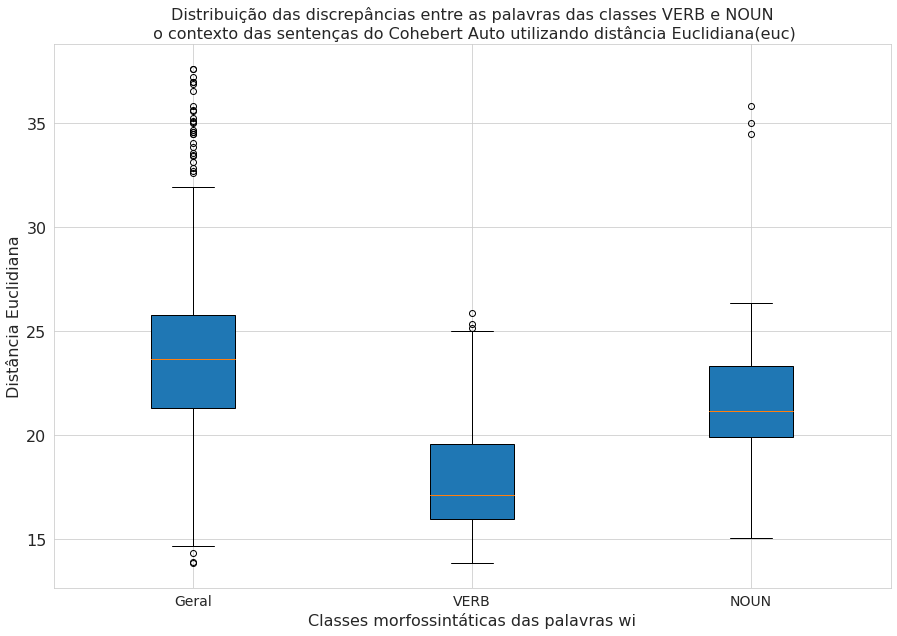

In [427]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Define o tamanho do gráfico 
fig, ax = plt.subplots(figsize =(15, 10))

# Estilo do gráfico
sns.set_style("whitegrid")

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras das classes VERB e NOUN\n o contexto das sentenças do Cohebert Auto utilizando distância Euclidiana(euc)")
# Texto do eixo x
plt.xlabel("Classes morfossintáticas das palavras wi")
# Texto do eixo y
plt.ylabel("Distância Euclidiana")

colunas = [lista_comparacao_contexto[["euc_ctxclean_mean"]], lista_comparacao_classesVV[["euc_ctxclean_mean"]], lista_comparacao_classesNN[["euc_ctxclean_mean"]]]
ax.boxplot(colunas, patch_artist=True)

# Rótulos para os boxplots
plt.xticks([1, 2, 3 ], ["Geral", "VERB", "NOUN"])

plt.show()

##### MAN

In [428]:
df_all = pd.concat([lista_comparacao_contexto[["man_ctxclean_mean"]],
                    lista_comparacao_classesVV[["man_ctxclean_mean"]], 
                    lista_comparacao_classesNN[["man_ctxclean_mean"]],                    
                    ], 
                    axis="columns", 
                    keys=["Geral", "VERB", "NOUN"])

df_all.describe(include=["float", "int"]) 

Geral              VERB              NOUN
      man_ctxclean_mean man_ctxclean_mean man_ctxclean_mean
count        434.000000         46.000000        108.000000
mean        1136.257946        874.695885       1008.329189
std          194.450014        154.373642        109.823918
min          672.883540        672.883540        738.976800
25%         1024.947675        781.312135        935.729925
50%         1147.549550        818.506435       1000.031875
75%         1236.004825        947.473330       1097.876975
max         1694.084700       1220.759600       1237.825200

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


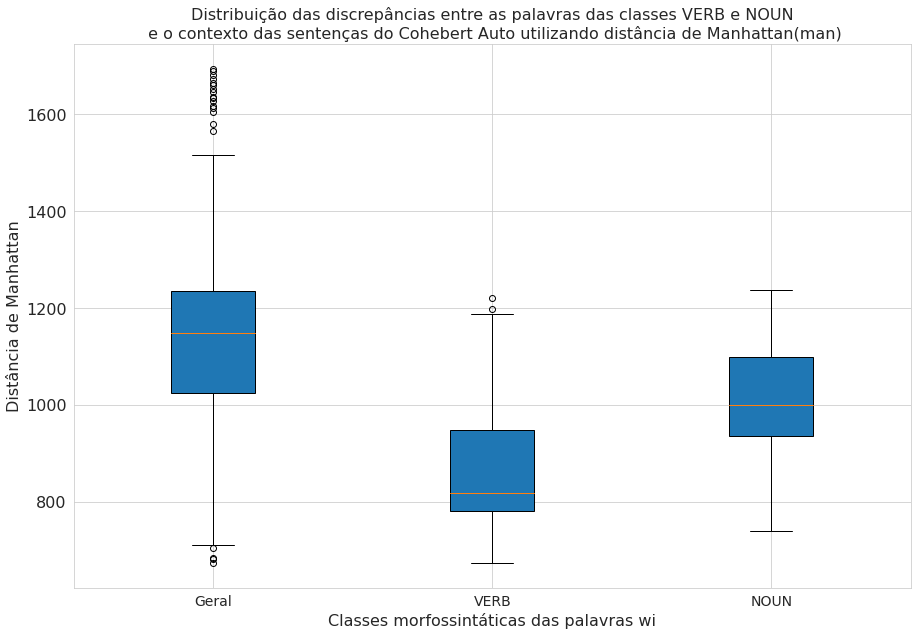

In [429]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Define o tamanho do gráfico 
fig, ax = plt.subplots(figsize =(15, 10))

# Estilo do gráfico
sns.set_style("whitegrid")

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras das classes VERB e NOUN\n e o contexto das sentenças do Cohebert Auto utilizando distância de Manhattan(man)")
# Texto do eixo x
plt.xlabel("Classes morfossintáticas das palavras wi")
# Texto do eixo y
plt.ylabel("Distância de Manhattan")

colunas = [lista_comparacao_contexto[["man_ctxclean_mean"]], lista_comparacao_classesVV[["man_ctxclean_mean"]], lista_comparacao_classesNN[["man_ctxclean_mean"]]]
ax.boxplot(colunas, patch_artist=True)

# Rótulos para os boxplots
plt.xticks([1, 2, 3], ["Geral", "VERB", "NOUN"])

plt.show()

### Contexto com palavras da classe VERB e AUX(ctxverb)

#### VERB

In [430]:
classe_morfosintatica = "VERB"

##### Estatísticas

Filtrar comparação contexto com verbos

In [431]:
lista_comparacao_classes = lista_comparacao_contexto[(lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]

lista_comparacao_classesVV = lista_comparacao_classes

print("Comparações:", len(lista_comparacao_classes))

Comparações: 46


Estatísticas das medidas dos contextos e palavras

In [432]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("precision", 6)

# Exibe as estatísticas
lista_comparacao_classes[["cos_ctxverb_mean", "euc_ctxverb_mean",
                          "man_ctxverb_mean", "cos_ctxverb_max",
                          "euc_ctxverb_max",  "man_ctxverb_max"]].describe(include=["float", "int"]) 

cos_ctxverb_mean  euc_ctxverb_mean  man_ctxverb_mean  cos_ctxverb_max  \
count         46.000000         46.000000         46.000000        46.000000   
mean           0.921061         12.801372        617.139205         0.797646   
std            0.052430          6.955124        333.938193         0.070152   
min            0.838702          0.000000          0.000000         0.670455   
25%            0.883408          8.283899        405.051170         0.749148   
50%            0.895120         16.264188        791.006409         0.788088   
75%            0.972769         17.946588        855.818146         0.844462   
max            1.000000         20.235275        964.706482         0.931386   

       euc_ctxverb_max  man_ctxverb_max  
count        46.000000        46.000000  
mean         24.434727      1220.762342  
std           4.029588       196.940437  
min          17.562273       842.355835  
25%          21.563921      1078.851562  
50%          25.010489      1247.949280  
75%          26.823060      1350.717987  
max          31.964499      1612.307739

##### Top 20

Top 20 palavras(wi) em mais ocorrências nas comparações de pos(wi) do tipo VERB

In [433]:
# Import das bibliotecas
import ast
from tqdm.notebook import tqdm as tqdm_notebook
from collections import Counter

# Barra de progresso dos documentos
lista_comparacao_classes_bar = tqdm_notebook(lista_comparacao_classes.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_comparacao_classes))

# Contador das palavras
contador = Counter()

# Percorre as comparações
for i, linha_comparacao in lista_comparacao_classes_bar:  
  #if i < 10:             
    contador[linha_comparacao[3]] += 1

Documentos:   0%|          | 0/46 [00:00<?, ? documento/s]

In [434]:
top = 20
lista = []
# Lista as ocorrências das palavras
for i, item in enumerate(sorted(contador, key = contador.get, reverse=True)):
  if i < top:
    lista.append([i+1, item, contador[item]])      

In [435]:
# Converte em um dataFrame
df1 = pd.DataFrame(lista, columns=("ranque", "palavra", "#wi"))

# Motra o rank
print(df1.to_string(index=False))

 ranque  palavra  #wi
      1        7   16
      2        1   12
      3        6    8
      4        3    4
      5        2    4
      6        8    2


##### COS - MEAN

In [436]:
medida = "cos_ctxverb_mean"

Documentos outliers

In [437]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 0.08936081826686848
Limite superior             : 1.106809891760349
Limite inferior             : 0.7493666186928751


Encontra os documentos com as maiores similaridades (cos(wi,contexto) > limite_superior)

In [438]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 0 de 46 ( 0.0 )


Encontra os documentos com as maiores discrepâncias (cos(wi,contexto) < limite_inferior)

In [439]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 46 ( 0.0 )


In [440]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  0 de 46 ( 0.0 )


###### Top 5 documentos com as maiores similaridades (cos(wi,ctxverb) > limite_superior) entre palavras da classe VERB e o contexto de palavras da classe VERB.

In [441]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxverb) < limite_inferior) entre palavras da classe VERB e o contexto de palavras da classe VERB.

In [442]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxverb) < limite_inferior) entre palavras da classe VERB e o contexto de palavras da classe VERB e a lista das palavras em ordem de discrepâncias.

In [443]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1

##### COS - MAX

In [444]:
medida = "cos_ctxverb_max"

Documentos outliers

In [445]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 0.09531441330909729
Limite superior             : 0.9874337911605835
Limite inferior             : 0.6061761379241943


Encontra os documentos com as maiores similaridades (cos(wi,contexto) > limite_superior)

In [446]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 0 de 46 ( 0.0 )


Encontra os documentos com as maiores discrepâncias (cos(wi,contexto) < limite_inferior)

In [447]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 46 ( 0.0 )


In [448]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  0 de 46 ( 0.0 )


###### Top 5 documentos com as maiores similaridades (cos(wi,ctxverb) > limite_superior) entre palavras da classe VERB e o contexto de palavras da classe VERB.

In [449]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxverb) < limite_inferior) entre palavras da classe VERB e o contexto de palavras da classe VERB.

In [450]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxverb) < limite_inferior) entre palavras da classe VERB e o contexto de palavras da classe VERB e a lista das palavras em ordem de discrepâncias.

In [451]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1

##### EUC - MEAN

In [452]:
medida = "euc_ctxverb_mean"

Documentos outliers

In [453]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 9.662688732147217
Limite superior             : 32.44062113761902
Limite inferior             : -6.210133790969849


Encontra os documentos com as maiores discrepâncias (euc(wi,contexto) > limite_superior)

In [454]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 0 de 46 ( 0.0 )


Encontra os documentos com as maiores similaridades (euc(wi,contexto) < limite_inferior)

In [455]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 46 ( 0.0 )


In [456]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  0 de 46 ( 0.0 )


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxverb) > limite_superior) entre palavras da classe VERB e o contexto de palavras da classe VERB.


In [457]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores similaridades (euc(wi,ctxverb) < limite_superior) entre palavras da classe VERB e o contexto de palavras da classe VERB.


In [458]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxverb) > limite_superior) entre palavras da classe VERB e o contexto de palavras da classe VERB e a lista das palavras em ordem de discrepâncias.

In [459]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1

##### EUC - MAX

In [460]:
medida = "euc_ctxverb_max"

Documentos outliers

In [461]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 5.259138584136966
Limite superior             : 34.71176791191102
Limite inferior             : 13.675213575363154


Encontra os documentos com as maiores discrepâncias (euc(wi,contexto) > limite_superior)

In [462]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 0 de 46 ( 0.0 )


Encontra os documentos com as maiores similaridades (euc(wi,contexto) < limite_inferior)

In [463]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 46 ( 0.0 )


In [464]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  0 de 46 ( 0.0 )


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxverb) > limite_superior) entre palavras da classe VERB e o contexto de palavras da classe VERB.


In [465]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores similaridades (euc(wi,ctxverb) < limite_superior) entre palavras da classe VERB e o contexto de palavras da classe VERB.


In [466]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxverb) > limite_superior) entre palavras da classe VERB e o contexto de palavras da classe VERB e a lista das palavras em ordem de discrepâncias.

In [467]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1

##### MAN - MEAN

In [468]:
medida = "man_ctxverb_mean"

Documentos outliers

In [469]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 450.76697540283203
Limite superior             : 1531.9686088562012
Limite inferior             : -271.09929275512695


Encontra os documentos com as maiores discrepâncias (man(wi,contexto) > limite_superior)

In [470]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 0 de 46 ( 0.0 )


Encontra os documentos com as maiores similaridades (man(wi,wj) < limite_inferior)

In [471]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 46 ( 0.0 )


In [472]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  0 de 46 ( 0.0 )


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxverb) > limite_superior) entre palavras da classe VERB e o contexto de palavras da classe VERB.

In [473]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores similaridades (man(wi,ctxverb) < limite_inferior) entre palavras da classe VERB e o contexto de palavras da classe VERB.

In [474]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxverb) > limite_superior) entre palavras da classe VERB e o contexto de palavras da classe VERB e a lista das palavras em ordem de discrepâncias.

In [475]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1

##### MAN - MAX

In [476]:
medida = "man_ctxverb_max"

Documentos outliers

In [477]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 271.8664245605469
Limite superior             : 1758.5176239013672
Limite inferior             : 671.0519256591797


Encontra os documentos com as maiores discrepâncias (man(wi,contexto) > limite_superior)

In [478]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 0 de 46 ( 0.0 )


Encontra os documentos com as maiores similaridades (man(wi,wj) < limite_inferior)

In [479]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 46 ( 0.0 )


In [480]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  0 de 46 ( 0.0 )


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxverb) > limite_superior) entre palavras da classe VERB e o contexto de palavras da classe VERB.

In [481]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores similaridades (man(wi,ctxverb) < limite_inferior) entre palavras da classe VERB e o contexto de palavras da classe VERB.

In [482]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxverb) > limite_superior) entre palavras da classe VERB e o contexto de palavras da classe VERB e a lista das palavras em ordem de discrepâncias.

In [483]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1

#### NOUN

In [484]:
classe_morfosintatica = "NOUN"

##### Estatísticas

Filtrar comparação contexto com verbos

In [485]:
lista_comparacao_classes = lista_comparacao_contexto[(lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]

lista_comparacao_classesNN = lista_comparacao_classes

print("Comparações:", len(lista_comparacao_classes))

Comparações: 108


Estatísticas das medidas dos contextos e palavras

In [486]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("precision", 6)

# Exibe as estatísticas
lista_comparacao_classes[["cos_ctxverb_mean","euc_ctxverb_mean",
                          "man_ctxverb_mean","cos_ctxverb_max",
                          "euc_ctxverb_max","man_ctxverb_max"]].describe(include=["float", "int"]) 

cos_ctxverb_mean  euc_ctxverb_mean  man_ctxverb_mean  cos_ctxverb_max  \
count         92.000000         92.000000         92.000000        92.000000   
mean           0.682682         31.080633       1449.237132         0.665070   
std            0.065309          4.813125        185.852195         0.062716   
min            0.480838         22.345469       1084.597900         0.480838   
25%            0.654796         28.087083       1337.831299         0.648251   
50%            0.694541         30.385395       1428.692078         0.674121   
75%            0.726632         33.155839       1550.790405         0.704838   
max            0.790527         46.616928       1988.902832         0.755232   

       euc_ctxverb_max  man_ctxverb_max  
count        92.000000        92.000000  
mean         32.289044      1510.411717  
std           4.243266       171.269542  
min          27.065489      1247.031250  
25%          29.645148      1407.397003  
50%          31.298631      1467.139709  
75%          33.383882      1561.662170  
max          46.616928      1988.902832

##### Top 20

Top 20 palavras(wi) em mais ocorrências nas comparações de pos(wi) do tipo NOUN e pos(wj) do tipo NOUN

In [487]:
# Import das bibliotecas
import ast
from tqdm.notebook import tqdm as tqdm_notebook
from collections import Counter

# Barra de progresso dos documentos
lista_comparacao_classes_bar = tqdm_notebook(lista_comparacao_classes.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_comparacao_classes))

# Contador das palavras
contador = Counter()

# Percorre as comparações
for i, linha_comparacao in lista_comparacao_classes_bar:  
  #if i < 10:             
    contador[linha_comparacao[3]] += 1

Documentos:   0%|          | 0/108 [00:00<?, ? documento/s]

In [488]:
top = 20
lista = []
# Lista as ocorrências das palavras
for i, item in enumerate(sorted(contador, key = contador.get, reverse=True)):
  if i < top:
    lista.append([i+1, item, contador[item]])      

In [489]:
# Converte em um dataFrame
df1 = pd.DataFrame(lista, columns=("ranque", "palavra", "#wi"))

# Motra o rank
print(df1.to_string(index=False))

 ranque  palavra  #wi
      1        4   28
      2        9   20
      3        2   16
      4        5   12
      5        7   10
      6       10    6
      7        8    4
      8        1    4
      9       11    4
     10       12    4


##### COS - MEAN

In [490]:
medida = "cos_ctxverb_mean"

Documentos outliers

In [491]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): nan
Limite superior             : nan
Limite inferior             : nan


Encontra os documentos com as maiores similaridades (cos(wi,contexto) > limite_superior)

In [492]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 0 de 108 ( 0.0 )


Encontra os documentos com as maiores discrepâncias (cos(wi,contexto) < limite_inferior)

In [493]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 108 ( 0.0 )


In [494]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)
print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  0 de 108 ( 0.0 )


###### Top 5 documentos com as maiores similaridades (cos(wi,ctxverb) > limite_superior) entre palavras da classe NOUN e o contexto de palavras da classe VERB.

In [495]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxverb) < limite_inferior) entre palavras da classe NOUN e o contexto de palavras da classe VERB.


In [496]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxverb) < limite_inferior) entre palavras da classe NOUN e o contexto de palavras da classe VERB e a lista das palavras em ordem de discrepâncias.

In [497]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1

##### COS - MAX

In [498]:
medida = "cos_ctxverb_max"

Documentos outliers

In [499]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): nan
Limite superior             : nan
Limite inferior             : nan


Encontra os documentos com as maiores similaridades (cos(wi,contexto) > limite_superior)

In [500]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 0 de 108 ( 0.0 )


Encontra os documentos com as maiores discrepâncias (cos(wi,contexto) < limite_inferior)

In [501]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 108 ( 0.0 )


In [502]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)
print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  0 de 108 ( 0.0 )


###### Top 5 documentos com as maiores similaridades (cos(wi,ctxverb) > limite_superior) entre palavras da classe NOUN e o contexto de palavras da classe VERB.

In [503]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxverb) < limite_inferior) entre palavras da classe NOUN e o contexto de palavras da classe VERB.


In [504]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxverb) < limite_inferior) entre palavras da classe NOUN e o contexto de palavras da classe VERB e a lista das palavras em ordem de discrepâncias.

In [505]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1

##### EUC - MEAN

In [506]:
medida = "euc_ctxverb_mean"

Documentos outliers

In [507]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): nan
Limite superior             : nan
Limite inferior             : nan


Encontra os documentos com as maiores discrepâncias (euc(wi,contexto) > limite_superior)

In [508]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior:", len(lista_comparacao_outliers_superior))

Outliers superior: 0


Encontra os documentos com as maiores similaridades (euc(wi,contexto) < limite_inferior)

In [509]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 108 ( 0.0 )


In [510]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)
print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  0 de 108 ( 0.0 )


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxverb) > limite_superior) entre palavras da classe NOUN e o contexto de palavras da classe VERB.

In [511]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores similaridades (euc(wi,ctxverb) < limite_superior) entre palavras da classe NOUN e o contexto de palavras da classe VERB.


In [512]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxverb) > limite_superior) entre palavras da classe NOUN e o contexto de palavras da classe VERB e a lista das palavras em ordem de discrepâncias.

In [513]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1

##### EUC - MAX

In [514]:
medida = "euc_ctxverb_max"

Documentos outliers

In [515]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): nan
Limite superior             : nan
Limite inferior             : nan


Encontra os documentos com as maiores discrepâncias (euc(wi,contexto) > limite_superior)

In [516]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior:", len(lista_comparacao_outliers_superior))

Outliers superior: 0


Encontra os documentos com as maiores similaridades (euc(wi,contexto) < limite_inferior)

In [517]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 108 ( 0.0 )


In [518]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)
print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  0 de 108 ( 0.0 )


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxverb) > limite_superior) entre palavras da classe NOUN e o contexto de palavras da classe VERB.

In [519]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores similaridades (euc(wi,ctxverb) < limite_superior) entre palavras da classe NOUN e o contexto de palavras da classe VERB.


In [520]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxverb) > limite_superior) entre palavras da classe NOUN e o contexto de palavras da classe VERB e a lista das palavras em ordem de discrepâncias.

In [521]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1

##### MAN - MEAN

In [522]:
medida = "man_ctxverb_mean"

Documentos outliers

In [523]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): nan
Limite superior             : nan
Limite inferior             : nan


Encontra os documentos com as maiores discrepâncias (man(wi,contexto) > limite_superior)

In [524]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior:", len(lista_comparacao_outliers_superior))

Outliers superior: 0


Encontra os documentos com as maiores similaridades (man(wi,contexto) < limite_inferior)

In [525]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 108 ( 0.0 )


In [526]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  0 de 108 ( 0.0 )


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxverb) > limite_superior) entre palavras da classe NOUN e o contexto de palavras da classe VERB.

In [527]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores similaridades (man(wi,ctxverb) < limite_superior) entre palavras da classe NOUN e o contexto de palavras da classe VERB.

In [528]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxvern) > limite_superior)  entre palavras da classe NOUN e o contexto de palavras da classe VERB e a lista das palavras em ordem de discrepâncias.

In [529]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1

##### MAN - MAX

In [530]:
medida = "man_ctxverb_max"

Documentos outliers

In [531]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): nan
Limite superior             : nan
Limite inferior             : nan


Encontra os documentos com as maiores discrepâncias (man(wi,contexto) > limite_superior)

In [532]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior:", len(lista_comparacao_outliers_superior))

Outliers superior: 0


Encontra os documentos com as maiores similaridades (man(wi,contexto) < limite_inferior)

In [533]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 108 ( 0.0 )


In [534]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  0 de 108 ( 0.0 )


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxverb) > limite_superior) entre palavras da classe NOUN e o contexto de palavras da classe VERB.

In [535]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores similaridades (man(wi,ctxverb) < limite_superior) entre palavras da classe NOUN e o contexto de palavras da classe VERB.

In [536]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxvern) > limite_superior)  entre palavras da classe NOUN e o contexto de palavras da classe VERB e a lista das palavras em ordem de discrepâncias.

In [537]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1

#### Comparando discrepância entre o contexto de palavras da classe VERB e palavras de todas classes, VERB e NOUN.

##### COS, EUC, MAN

In [538]:
df_all = pd.concat([lista_comparacao_contexto[["cos_ctxverb_mean","euc_ctxverb_mean",
                                               "man_ctxverb_mean","cos_ctxverb_max",
                                               "euc_ctxverb_max","man_ctxverb_max"]],
                    lista_comparacao_classesVV[["cos_ctxverb_mean","euc_ctxverb_mean",
                                                "man_ctxverb_mean","cos_ctxverb_max",
                                                "euc_ctxverb_max","man_ctxverb_max"]], 
                    lista_comparacao_classesNN[["cos_ctxverb_mean","euc_ctxverb_mean",
                                                "man_ctxverb_mean","cos_ctxverb_max",
                                                "euc_ctxverb_max","man_ctxverb_max"]],
                    ], 
                    axis="columns", 
                   keys=["Geral", "VERB", "NOUN"])

df_all.describe(include=["float", "int"]) 

Geral                                                    \
      cos_ctxverb_mean euc_ctxverb_mean man_ctxverb_mean cos_ctxverb_max   
count       400.000000       400.000000       400.000000      400.000000   
mean          0.733458        26.401851      1269.694131        0.712948   
std           0.130248         7.606234       347.742879        0.117730   
min           0.102380         0.000000         0.000000        0.102380   
25%           0.691360        24.990921      1223.450165        0.678993   
50%           0.733142        27.363439      1343.094482        0.723459   
75%           0.771328        30.296926      1456.679169        0.761683   
max           1.000000        46.616928      1988.902832        1.000000   

                                                  VERB                   \
      euc_ctxverb_max man_ctxverb_max cos_ctxverb_mean euc_ctxverb_mean   
count      400.000000      400.000000        46.000000        46.000000   
mean        28.180100     1361.569711         0.921061        12.801372   
std          5.748429      251.646705         0.052430         6.955124   
min          0.000000        0.000000         0.838702         0.000000   
25%         25.745354     1278.155640         0.883408         8.283899   
50%         27.960430     1365.575439         0.895120        16.264188   
75%         30.814656     1483.296814         0.972769        17.946588   
max         46.616928     1988.902832         1.000000        20.235275   

                                                                        \
      man_ctxverb_mean cos_ctxverb_max euc_ctxverb_max man_ctxverb_max   
count        46.000000       46.000000       46.000000       46.000000   
mean        617.139205        0.797646       24.434727     1220.762342   
std         333.938193        0.070152        4.029588      196.940437   
min           0.000000        0.670455       17.562273      842.355835   
25%         405.051170        0.749148       21.563921     1078.851562   
50%         791.006409        0.788088       25.010489     1247.949280   
75%         855.818146        0.844462       26.823060     1350.717987   
max         964.706482        0.931386       31.964499     1612.307739   

                  NOUN                                                    \
      cos_ctxverb_mean euc_ctxverb_mean man_ctxverb_mean cos_ctxverb_max   
count        92.000000        92.000000        92.000000       92.000000   
mean          0.682682        31.080633      1449.237132        0.665070   
std           0.065309         4.813125       185.852195        0.062716   
min           0.480838        22.345469      1084.597900        0.480838   
25%           0.654796        28.087083      1337.831299        0.648251   
50%           0.694541        30.385395      1428.692078        0.674121   
75%           0.726632        33.155839      1550.790405        0.704838   
max           0.790527        46.616928      1988.902832        0.755232   

                                       
      euc_ctxverb_max man_ctxverb_max  
count       92.000000       92.000000  
mean        32.289044     1510.411717  
std          4.243266      171.269542  
min         27.065489     1247.031250  
25%         29.645148     1407.397003  
50%         31.298631     1467.139709  
75%         33.383882     1561.662170  
max         46.616928     1988.902832

##### COS

In [539]:
df_all = pd.concat([lista_comparacao_contexto[["cos_ctxverb_mean"]],                    
                    lista_comparacao_classesVV[["cos_ctxverb_mean"]], 
                    lista_comparacao_classesNN[["cos_ctxverb_mean"]],
                    ], 
                    axis="columns", 
                    keys=["Geral", "VERB", "NOUN"])

df_all.describe(include=["float", "int"]) 

Geral             VERB             NOUN
      cos_ctxverb_mean cos_ctxverb_mean cos_ctxverb_mean
count       400.000000        46.000000        92.000000
mean          0.733458         0.921061         0.682682
std           0.130248         0.052430         0.065309
min           0.102380         0.838702         0.480838
25%           0.691360         0.883408         0.654796
50%           0.733142         0.895120         0.694541
75%           0.771328         0.972769         0.726632
max           1.000000         1.000000         0.790527

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


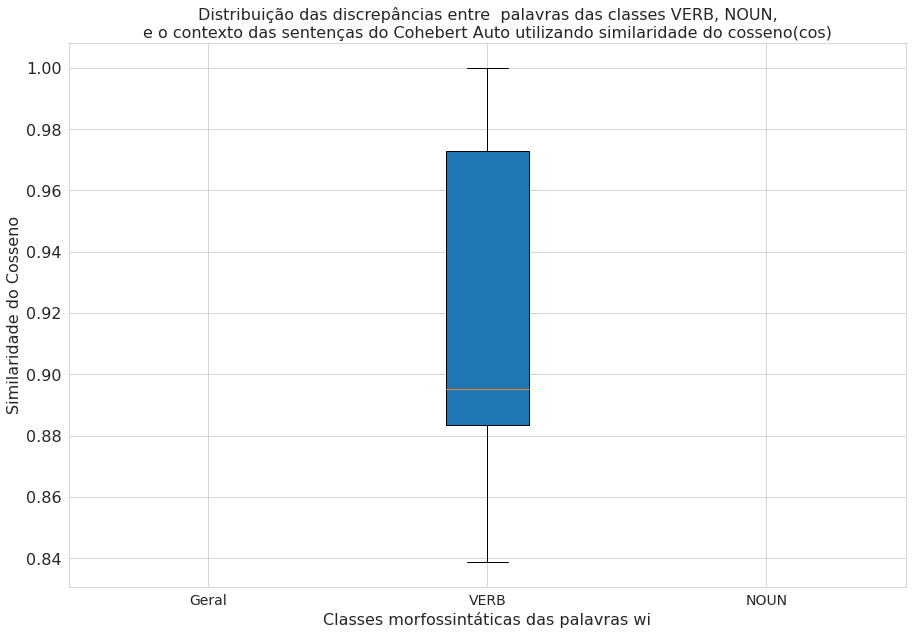

In [540]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Define o tamanho do gráfico 
fig, ax = plt.subplots(figsize =(15, 10))

# Estilo do gráfico
sns.set_style("whitegrid")

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre  palavras das classes VERB, NOUN,\ne o contexto das sentenças do Cohebert Auto utilizando similaridade do cosseno(cos)")
# Texto do eixo x
plt.xlabel("Classes morfossintáticas das palavras wi")
# Texto do eixo y
plt.ylabel("Similaridade do Cosseno")

colunas = [lista_comparacao_contexto[["cos_ctxverb_mean"]], lista_comparacao_classesVV[["cos_ctxverb_mean"]], lista_comparacao_classesNN[["cos_ctxverb_mean"]]]
ax.boxplot(colunas, patch_artist=True)

# Rótulos para os boxplots
plt.xticks([1, 2, 3], ["Geral", "VERB", "NOUN"])

plt.show()

##### EUC

In [541]:
df_all = pd.concat([lista_comparacao_contexto[["euc_ctxverb_mean"]],
                    lista_comparacao_classesVV[["euc_ctxverb_mean"]], 
                    lista_comparacao_classesNN[["euc_ctxverb_mean"]],                    
                    ], 
                    axis="columns", 
                    keys=["Geral", "VERB", "NOUN"])

df_all.describe(include=["float", "int"]) 

Geral             VERB             NOUN
      euc_ctxverb_mean euc_ctxverb_mean euc_ctxverb_mean
count       400.000000        46.000000        92.000000
mean         26.401851        12.801372        31.080633
std           7.606234         6.955124         4.813125
min           0.000000         0.000000        22.345469
25%          24.990921         8.283899        28.087083
50%          27.363439        16.264188        30.385395
75%          30.296926        17.946588        33.155839
max          46.616928        20.235275        46.616928

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


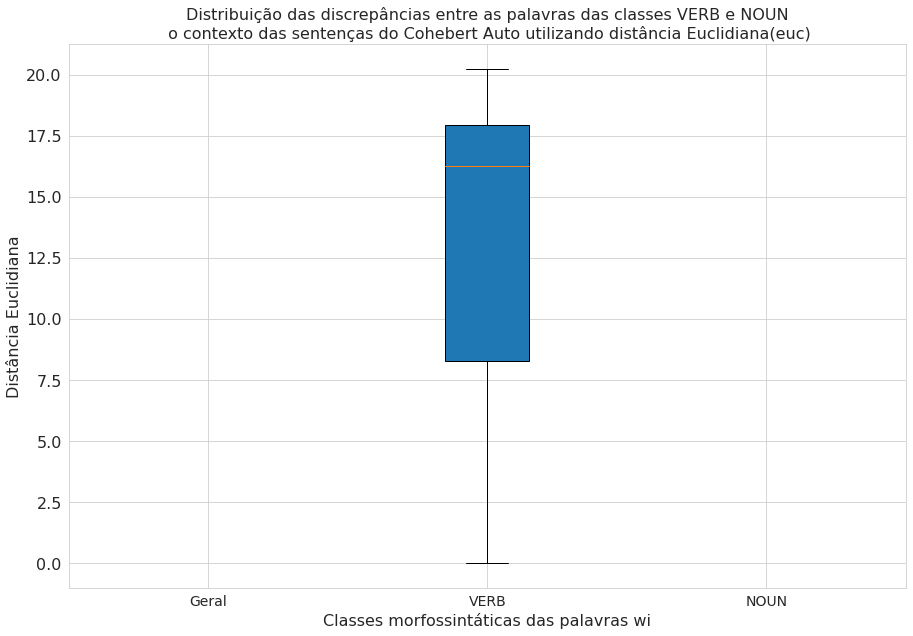

In [542]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Define o tamanho do gráfico 
fig, ax = plt.subplots(figsize =(15, 10))

# Estilo do gráfico
sns.set_style("whitegrid")

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras das classes VERB e NOUN\n o contexto das sentenças do Cohebert Auto utilizando distância Euclidiana(euc)")
# Texto do eixo x
plt.xlabel("Classes morfossintáticas das palavras wi")
# Texto do eixo y
plt.ylabel("Distância Euclidiana")

colunas = [lista_comparacao_contexto[["euc_ctxverb_mean"]], 
           lista_comparacao_classesVV[["euc_ctxverb_mean"]], 
           lista_comparacao_classesNN[["euc_ctxverb_mean"]]]
ax.boxplot(colunas, patch_artist=True)

# Rótulos para os boxplots
plt.xticks([1, 2, 3 ], ["Geral", "VERB", "NOUN"])

plt.show()

##### MAN

In [543]:
df_all = pd.concat([lista_comparacao_contexto[["man_ctxverb_mean"]],
                    lista_comparacao_classesVV[["man_ctxverb_mean"]], 
                    lista_comparacao_classesNN[["man_ctxverb_mean"]],                    
                    ], 
                    axis="columns", 
                    keys=["Geral", "VERB", "NOUN"])

df_all.describe(include=["float", "int"]) 

Geral             VERB             NOUN
      man_ctxverb_mean man_ctxverb_mean man_ctxverb_mean
count       400.000000        46.000000        92.000000
mean       1269.694131       617.139205      1449.237132
std         347.742879       333.938193       185.852195
min           0.000000         0.000000      1084.597900
25%        1223.450165       405.051170      1337.831299
50%        1343.094482       791.006409      1428.692078
75%        1456.679169       855.818146      1550.790405
max        1988.902832       964.706482      1988.902832

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


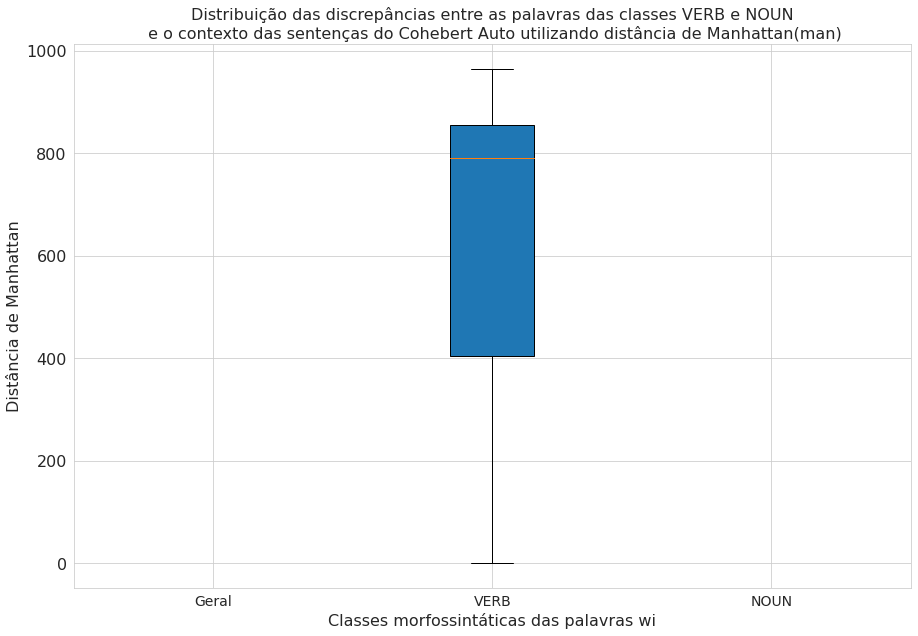

In [544]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Define o tamanho do gráfico 
fig, ax = plt.subplots(figsize =(15, 10))

# Estilo do gráfico
sns.set_style("whitegrid")

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras das classes VERB e NOUN\n e o contexto das sentenças do Cohebert Auto utilizando distância de Manhattan(man)")
# Texto do eixo x
plt.xlabel("Classes morfossintáticas das palavras wi")
# Texto do eixo y
plt.ylabel("Distância de Manhattan")

colunas = [lista_comparacao_contexto[["man_ctxverb_mean"]], 
           lista_comparacao_classesVV[["man_ctxverb_mean"]], 
           lista_comparacao_classesNN[["man_ctxverb_mean"]]]
ax.boxplot(colunas, patch_artist=True)

# Rótulos para os boxplots
plt.xticks([1, 2, 3], ["Geral", "VERB", "NOUN"])

plt.show()

### Contexto com palavras da classe NOUN(ctxnoun)

#### VERB

In [545]:
classe_morfosintatica = "VERB"

##### Estatísticas

Filtrar comparação contexto com verbos

In [546]:
lista_comparacao_classes = lista_comparacao_contexto[(lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]

lista_comparacao_classesVV = lista_comparacao_classes

print("Comparações:", len(lista_comparacao_classes))

Comparações: 46


Estatísticas das medidas dos contextos e palavras

In [547]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("precision", 6)

# Exibe as estatísticas
lista_comparacao_classes[["cos_ctxnoun_mean","euc_ctxnoun_mean",
                          "man_ctxnoun_mean","cos_ctxnoun_max",
                          "euc_ctxnoun_max","man_ctxnoun_max"]].describe(include=["float", "int"]) 

cos_ctxnoun_mean  euc_ctxnoun_mean  man_ctxnoun_mean  cos_ctxnoun_max  \
count         46.000000         46.000000         46.000000        46.000000   
mean           0.758516         25.604029       1210.909298         0.643140   
std            0.041452          3.095116        145.352283         0.053293   
min            0.682117         18.897543        897.339970         0.538292   
25%            0.733888         23.741280       1137.720600         0.608251   
50%            0.755251         25.307844       1192.478400         0.635877   
75%            0.786102         27.197792       1279.407575         0.681920   
max            0.845183         32.435139       1543.213400         0.750776   

       euc_ctxnoun_max  man_ctxnoun_max  
count        46.000000        46.000000  
mean         33.007389      1565.012846  
std           2.619525       119.870640  
min          27.314680      1333.597400  
25%          31.470810      1482.689575  
50%          33.026672      1547.926400  
75%          34.451274      1620.855625  
max          38.622162      1861.415000

##### Top 20

Top 20 palavras(wi) em mais ocorrências nas comparações de pos(wi) do tipo VERB

In [548]:
# Import das bibliotecas
import ast
from tqdm.notebook import tqdm as tqdm_notebook
from collections import Counter

# Barra de progresso dos documentos
lista_comparacao_classes_bar = tqdm_notebook(lista_comparacao_classes.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_comparacao_classes))

# Contador das palavras
contador = Counter()

# Percorre as comparações
for i, linha_comparacao in lista_comparacao_classes_bar:  
  #if i < 10:             
    contador[linha_comparacao[3]] += 1

Documentos:   0%|          | 0/46 [00:00<?, ? documento/s]

In [549]:
top = 20
lista = []
# Lista as ocorrências das palavras
for i, item in enumerate(sorted(contador, key = contador.get, reverse=True)):
  if i < top:
    lista.append([i+1, item, contador[item]])      

In [550]:
# Converte em um dataFrame
df1 = pd.DataFrame(lista, columns=("ranque", "palavra", "#wi"))

# Motra o rank
print(df1.to_string(index=False))

 ranque  palavra  #wi
      1        7   16
      2        1   12
      3        6    8
      4        3    4
      5        2    4
      6        8    2


##### COS - MEAN

In [551]:
medida = "cos_ctxnoun_mean"

Documentos outliers

In [552]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 0.052214205265045166
Limite superior             : 0.8644232749938965
Limite inferior             : 0.6555664539337158


Encontra os documentos com as maiores similaridades (cos(wi,contexto) > limite_superior)

In [553]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 0 de 46 ( 0.0 )


Encontra os documentos com as maiores discrepâncias (cos(wi,contexto) < limite_inferior)

In [554]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 46 ( 0.0 )


In [555]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  0 de 46 ( 0.0 )


###### Top 5 documentos com as maiores similaridades (cos(wi,ctxnoun) > limite_superior) entre palavras da classe VERB e o contexto de palavras da classe NOUN.

In [556]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxnoun) < limite_inferior) entre palavras da classe VERB e o contexto de palavras da classe NOUN.

In [557]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxnoun) < limite_inferior)  entre palavras da classe VERB e o contexto de palavras da classe NOUN e a lista das palavras em ordem de discrepâncias.

In [558]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1

##### COS - MAX

In [559]:
medida = "cos_ctxnoun_max"

Documentos outliers

In [560]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 0.07366864383220673
Limite superior             : 0.7924225702881813
Limite inferior             : 0.4977479949593544


Encontra os documentos com as maiores similaridades (cos(wi,contexto) > limite_superior)

In [561]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 0 de 46 ( 0.0 )


Encontra os documentos com as maiores discrepâncias (cos(wi,contexto) < limite_inferior)

In [562]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 46 ( 0.0 )


In [563]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  0 de 46 ( 0.0 )


###### Top 5 documentos com as maiores similaridades (cos(wi,ctxnoun) > limite_superior) entre palavras da classe VERB e o contexto de palavras da classe NOUN.

In [564]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxnoun) < limite_inferior) entre palavras da classe VERB e o contexto de palavras da classe NOUN.

In [565]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxnoun) < limite_inferior)  entre palavras da classe VERB e o contexto de palavras da classe NOUN e a lista das palavras em ordem de discrepâncias.

In [566]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1

##### EUC - MEAN

In [567]:
medida = "euc_ctxnoun_mean"

Documentos outliers

In [568]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 3.456511974334717
Limite superior             : 32.38256001472473
Limite inferior             : 18.556512117385864


Encontra os documentos com as maiores discrepâncias (euc(wi,contexto) > limite_superior)

In [569]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 1 de 46 ( 0.021739130434782608 )


Encontra os documentos com as maiores similaridades (euc(wi,contexto) < limite_inferior)

In [570]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 46 ( 0.0 )


In [571]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  1 de 46 ( 0.021739130434782608 )


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxnoun) > limite_superior) entre palavras da classe VERB e o contexto de palavras da classe NOUN.


In [572]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 32.43513870239258 ocorre
         Em uma pilha a operação de enfileirar ocorre em qual extremidade ?


###### Top 5 documentos com as maiores similaridades (euc(wi,ctxnoun) < limite_superior) entre palavras da classe VERB e o contexto de palavras da classe NOUN.


In [573]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxnoun) > limite_superior) entre palavras da classe VERB e o contexto de palavras da classe NOUN e a lista das palavras em ordem de discrepâncias.

In [574]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 Em uma pilha a operação de enfileirar ocorre em qual extremidade ?
       1 32.43513870239258 ocorre
       2 27.251022338867188 enfileirar


##### EUC - MAX

In [575]:
medida = "euc_ctxnoun_max"

Documentos outliers

In [576]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 2.9804639816284286
Limite superior             : 38.921969890594504
Limite inferior             : 27.00011396408079


Encontra os documentos com as maiores discrepâncias (euc(wi,contexto) > limite_superior)

In [577]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 0 de 46 ( 0.0 )


Encontra os documentos com as maiores similaridades (euc(wi,contexto) < limite_inferior)

In [578]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 46 ( 0.0 )


In [579]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  0 de 46 ( 0.0 )


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxnoun) > limite_superior) entre palavras da classe VERB e o contexto de palavras da classe NOUN.


In [580]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores similaridades (euc(wi,ctxnoun) < limite_superior) entre palavras da classe VERB e o contexto de palavras da classe NOUN.


In [581]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxnoun) > limite_superior) entre palavras da classe VERB e o contexto de palavras da classe NOUN e a lista das palavras em ordem de discrepâncias.

In [582]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1

##### MAN - MEAN

In [583]:
medida = "man_ctxnoun_mean"

Documentos outliers

In [584]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 141.68697499999985
Limite superior             : 1491.9380374999996
Limite inferior             : 925.1901375000003


Encontra os documentos com as maiores discrepâncias (man(wi,contexto) > limite_superior)

In [585]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 2 de 46 ( 0.043478260869565216 )


Encontra os documentos com as maiores similaridades (man(wi,wj) < limite_inferior)

In [586]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 1 de 46 ( 0.021739130434782608 )


In [587]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  3 de 46 ( 0.06521739130434782 )


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxnoun) > limite_superior) entre palavras da classe VERB e o contexto de palavras da classe NOUN.

In [588]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 1543.2134 ocorre
         Em uma pilha a operação de enfileirar ocorre em qual extremidade ?

 2 1505.723 ocorre
         Em uma pilha a operação de empilhar ocorre em qual extremidade?


###### Top 5 documentos com as maiores similaridades (man(wi,ctxnoun) < limite_inferior) entre palavras da classe VERB e o contexto de palavras da classe NOUN.

In [589]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 897.33997 empilhar
         O que é uma fila e como empilhar e desempilhar seus elementos ?


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxnoun) > limite_superior) entre palavras da classe VERB e o contexto de palavras da classe NOUN e a lista das palavras em ordem de discrepâncias.

In [590]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 Em uma pilha a operação de enfileirar ocorre em qual extremidade ?
       1 1543.2134 ocorre
       2 1257.8588 enfileirar

 2 Em uma pilha a operação de empilhar ocorre em qual extremidade?
       1 1505.723 ocorre
       2 1202.0065 empilhar


##### MAN - MAX

In [591]:
medida = "man_ctxnoun_max"

Documentos outliers

In [592]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 138.1660499999998
Limite superior             : 1828.1046999999996
Limite inferior             : 1275.4405000000004


Encontra os documentos com as maiores discrepâncias (man(wi,contexto) > limite_superior)

In [593]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 1 de 46 ( 0.021739130434782608 )


Encontra os documentos com as maiores similaridades (man(wi,wj) < limite_inferior)

In [594]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 46 ( 0.0 )


In [595]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  1 de 46 ( 0.021739130434782608 )


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxnoun) > limite_superior) entre palavras da classe VERB e o contexto de palavras da classe NOUN.

In [596]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 1861.415 desempilhar
         Como são implementadas as operações de empilhar e desempilhar elementos em uma pilha?


###### Top 5 documentos com as maiores similaridades (man(wi,ctxnoun) < limite_inferior) entre palavras da classe VERB e o contexto de palavras da classe NOUN.

In [597]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxnoun) > limite_superior) entre palavras da classe VERB e o contexto de palavras da classe NOUN e a lista das palavras em ordem de discrepâncias.

In [598]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 Como são implementadas as operações de empilhar e desempilhar elementos em uma pilha?
       1 1861.415 desempilhar
       2 1574.1866 implementadas
       3 1540.3955 empilhar


#### NOUN

In [599]:
classe_morfosintatica = "NOUN"

##### Estatísticas

Filtrar comparação contexto com verbos

In [600]:
lista_comparacao_classes = lista_comparacao_contexto[(lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]

lista_comparacao_classesNN = lista_comparacao_classes

print("Comparações:", len(lista_comparacao_classes))

Comparações: 108


Estatísticas das medidas dos contextos e palavras

In [601]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("precision", 6)

# Exibe as estatísticas
lista_comparacao_classes[["cos_ctxnoun_mean","euc_ctxnoun_mean","man_ctxnoun_mean","cos_ctxnoun_max","euc_ctxnoun_max","man_ctxnoun_max"]].describe(include=["float", "int"]) 

cos_ctxnoun_mean  euc_ctxnoun_mean  man_ctxnoun_mean  cos_ctxnoun_max  \
count        108.000000        108.000000        108.000000       108.000000   
mean           0.888524         19.057229        876.930347         0.864111   
std            0.025915          2.890300         98.406364         0.058816   
min            0.825329         14.569006        697.053340         0.654618   
25%            0.870703         17.207865        785.963300         0.828783   
50%            0.885522         18.936301        880.169000         0.878747   
75%            0.907312         20.135258        942.397150         0.906829   
max            0.938791         34.023926       1165.996800         0.938791   

       euc_ctxnoun_max  man_ctxnoun_max  
count       108.000000       108.000000  
mean         20.936219       974.212930  
std           4.069775       189.534783  
min          15.253929       712.051200  
25%          17.949716       825.967145  
50%          20.074553       936.972900  
75%          22.766421      1061.291750  
max          34.023926      1632.805500

##### Top 20

Top 20 palavras(wi) em mais ocorrências nas comparações de pos(wi) do tipo NOUN e pos(wj) do tipo NOUN

In [602]:
# Import das bibliotecas
import ast
from tqdm.notebook import tqdm as tqdm_notebook
from collections import Counter

# Barra de progresso dos documentos
lista_comparacao_classes_bar = tqdm_notebook(lista_comparacao_classes.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_comparacao_classes))

# Contador das palavras
contador = Counter()

# Percorre as comparações
for i, linha_comparacao in lista_comparacao_classes_bar:  
  #if i < 10:             
    contador[linha_comparacao[3]] += 1

Documentos:   0%|          | 0/108 [00:00<?, ? documento/s]

In [603]:
top = 20
lista = []
# Lista as ocorrências das palavras
for i, item in enumerate(sorted(contador, key = contador.get, reverse=True)):
  if i < top:
    lista.append([i+1, item, contador[item]])      

In [604]:
# Converte em um dataFrame
df1 = pd.DataFrame(lista, columns=("ranque", "palavra", "#wi"))

# Motra o rank
print(df1.to_string(index=False))

 ranque  palavra  #wi
      1        4   28
      2        9   20
      3        2   16
      4        5   12
      5        7   10
      6       10    6
      7        8    4
      8        1    4
      9       11    4
     10       12    4


##### COS - MEAN

In [605]:
medida = "cos_ctxnoun_mean"

Documentos outliers

In [606]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 0.03660903871059418
Limite superior             : 0.962225966155529
Limite inferior             : 0.8157898113131523


Encontra os documentos com as maiores similaridades (cos(wi,contexto) > limite_superior)

In [607]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 0 de 108 ( 0.0 )


Encontra os documentos com as maiores discrepâncias (cos(wi,contexto) < limite_inferior)

In [608]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 108 ( 0.0 )


In [609]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)
print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  0 de 108 ( 0.0 )


###### Top 5 documentos com as maiores similaridades (cos(wi,ctxnoun) > limite_superior) entre palavras da classe NOUN e o contexto de palavras da classe NOUN.

In [610]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxnoun) < limite_inferior) entre palavras da classe NOUN e o contexto de palavras da classe NOUN.


In [611]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxnoun) < limite_inferior)  entre palavras da classe NOUN e o contexto de palavras da classe NOUN e a lista das palavras em ordem de discrepâncias.

In [612]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1

##### COS - MAX

In [613]:
medida = "cos_ctxnoun_mean"

Documentos outliers

In [614]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 0.03660903871059418
Limite superior             : 0.962225966155529
Limite inferior             : 0.8157898113131523


Encontra os documentos com as maiores similaridades (cos(wi,contexto) > limite_superior)

In [615]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 0 de 108 ( 0.0 )


Encontra os documentos com as maiores discrepâncias (cos(wi,contexto) < limite_inferior)

In [616]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 108 ( 0.0 )


In [617]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)
print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  0 de 108 ( 0.0 )


###### Top 5 documentos com as maiores similaridades (cos(wi,ctxnoun) > limite_superior) entre palavras da classe NOUN e o contexto de palavras da classe NOUN.

In [618]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxnoun) < limite_inferior) entre palavras da classe NOUN e o contexto de palavras da classe NOUN.


In [619]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxnoun) < limite_inferior)  entre palavras da classe NOUN e o contexto de palavras da classe NOUN e a lista das palavras em ordem de discrepâncias.

In [620]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1

##### EUC - MEAN

In [621]:
medida = "euc_ctxnoun_mean"

Documentos outliers

In [622]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 2.9273924827575684
Limite superior             : 24.526346445083618
Limite inferior             : 12.816776514053345


Encontra os documentos com as maiores discrepâncias (euc(wi,contexto) > limite_superior)

In [623]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior:", len(lista_comparacao_outliers_superior))

Outliers superior: 3


Encontra os documentos com as maiores similaridades (euc(wi,contexto) < limite_inferior)

In [624]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 108 ( 0.0 )


In [625]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)
print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  3 de 108 ( 0.027777777777777776 )


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxnoun) > limite_superior) entre palavras da classe NOUN e o contexto de palavras da classe NOUN.

In [626]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 34.02392578125 pilha
         Como desempilhar elementos em uma estrutura de dados pilha?

 2 31.914247512817383 pilha
         Como empilhar elementos em uma estrutura de dados pilha?

 3 31.518970489501957 pilha
         Como empilhar e desempilhar elementos em uma estrutura de dados pilha?


###### Top 5 documentos com as maiores similaridades (euc(wi,ctxnoun) < limite_superior) entre palavras da classe NOUN e o contexto de palavras da classe NOUN.


In [627]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxnoun) > limite_superior)  entre palavras da classe NOUN e o contexto de palavras da classe NOUN e a lista das palavras em ordem de discrepâncias.

In [628]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 Como desempilhar elementos em uma estrutura de dados pilha?
       1 34.02392578125 pilha
       2 20.68986701965332 dados
       3 19.93473052978516 estrutura
       4 19.830671310424805 desempilhar
       5 18.9652156829834 elementos

 2 Como empilhar elementos em uma estrutura de dados pilha?
       1 31.914247512817383 pilha
       2 20.79932403564453 elementos
       3 20.022951126098636 dados
       4 19.906099319458008 estrutura

 3 Como empilhar e desempilhar elementos em uma estrutura de dados pilha?
       1 31.518970489501957 pilha
       2 20.928598403930664 elementos
       3 20.13155746459961 estrutura
       4 20.00775146484375 dados


##### EUC - MAX

In [629]:
medida = "euc_ctxnoun_max"

Documentos outliers

In [630]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 4.816705226898197
Limite superior             : 29.991479158401496
Limite inferior             : 10.72465825080871


Encontra os documentos com as maiores discrepâncias (euc(wi,contexto) > limite_superior)

In [631]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior:", len(lista_comparacao_outliers_superior))

Outliers superior: 5


Encontra os documentos com as maiores similaridades (euc(wi,contexto) < limite_inferior)

In [632]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 108 ( 0.0 )


In [633]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)
print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  5 de 108 ( 0.046296296296296294 )


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxnoun) > limite_superior) entre palavras da classe NOUN e o contexto de palavras da classe NOUN.

In [634]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 34.02392578125 pilha
         Como desempilhar elementos em uma estrutura de dados pilha?

 2 32.878944396972656 desempilhar
         O que é uma pilha e como empilhar e desempilhar seus elementos?

 3 31.914247512817383 pilha
         Como empilhar elementos em uma estrutura de dados pilha?

 4 31.518970489501957 pilha
         Como empilhar e desempilhar elementos em uma estrutura de dados pilha?

 5 31.18284034729004 desempilhar
         O que é uma fila e como empilhar e desempilhar seus elementos ?


###### Top 5 documentos com as maiores similaridades (euc(wi,ctxnoun) < limite_superior) entre palavras da classe NOUN e o contexto de palavras da classe NOUN.


In [635]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxnoun) > limite_superior)  entre palavras da classe NOUN e o contexto de palavras da classe NOUN e a lista das palavras em ordem de discrepâncias.

In [636]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 Como desempilhar elementos em uma estrutura de dados pilha?
       1 34.02392578125 pilha
       2 29.330642700195312 desempilhar
       3 20.68986701965332 dados
       4 19.93473052978516 estrutura
       5 18.9652156829834 elementos

 2 O que é uma pilha e como empilhar e desempilhar seus elementos?
       1 32.878944396972656 desempilhar
       2 19.48836898803711 pilha
       3 19.37257957458496 elementos

 3 Como empilhar elementos em uma estrutura de dados pilha?
       1 31.914247512817383 pilha
       2 20.79932403564453 elementos
       3 20.022951126098636 dados
       4 19.906099319458008 estrutura

 4 Como empilhar e desempilhar elementos em uma estrutura de dados pilha?
       1 31.518970489501957 pilha
       2 20.928598403930664 elementos
       3 20.13155746459961 estrutura
       4 20.00775146484375 dados

 5 O que é uma fila e como empilhar e desempilhar seus elementos ?
       1 31.18284034729004 desempilhar
       2 23.63088798522949 fila
       3 20.7012157440

##### MAN - MEAN

In [637]:
medida = "man_ctxnoun_mean"

Documentos outliers

In [638]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 156.43385
Limite superior             : 1177.047925
Limite inferior             : 551.312525


Encontra os documentos com as maiores discrepâncias (man(wi,contexto) > limite_superior)

In [639]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior:", len(lista_comparacao_outliers_superior))

Outliers superior: 0


Encontra os documentos com as maiores similaridades (man(wi,contexto) < limite_inferior)

In [640]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 108 ( 0.0 )


In [641]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  0 de 108 ( 0.0 )


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxnoun) > limite_superior) entre palavras da classe NOUN e o contexto de palavras da classe NOUN.

In [642]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores similaridades (man(wi,ctxnoun) < limite_superior) entre palavras da classe NOUN e o contexto de palavras da classe NOUN.

In [643]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxnoun) > limite_superior)  entre palavras da classe NOUN e o contexto de palavras da classe NOUN e a lista das palavras em ordem de discrepâncias.

In [644]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1

##### MAN - MAX

In [645]:
medida = "man_ctxnoun_max"

Documentos outliers

In [646]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 235.3246049999998
Limite superior             : 1414.2786574999996
Limite inferior             : 472.9802375000004


Encontra os documentos com as maiores discrepâncias (man(wi,contexto) > limite_superior)

In [647]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior:", len(lista_comparacao_outliers_superior))

Outliers superior: 3


Encontra os documentos com as maiores similaridades (man(wi,contexto) < limite_inferior)

In [648]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 108 ( 0.0 )


In [649]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  3 de 108 ( 0.027777777777777776 )


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxnoun) > limite_superior) entre palavras da classe NOUN e o contexto de palavras da classe NOUN.

In [650]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 1632.8055 desempilhar
         O que é uma pilha e como empilhar e desempilhar seus elementos?

 2 1568.8291 desempilhar
         O que é uma fila e como empilhar e desempilhar seus elementos ?

 3 1493.9644 desempilhar
         O que é uma pilha e como desempilhar um elemento nela?


###### Top 5 documentos com as maiores similaridades (man(wi,ctxnoun) < limite_superior) entre palavras da classe NOUN e o contexto de palavras da classe NOUN.

In [651]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxnoun) > limite_superior)  entre palavras da classe NOUN e o contexto de palavras da classe NOUN e a lista das palavras em ordem de discrepâncias.

In [652]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 O que é uma pilha e como empilhar e desempilhar seus elementos?
       1 1632.8055 desempilhar
       2 922.1848 elementos
       3 890.49243 pilha

 2 O que é uma fila e como empilhar e desempilhar seus elementos ?
       1 1568.8291 desempilhar
       2 1132.4749 fila
       3 960.897 elementos

 3 O que é uma pilha e como desempilhar um elemento nela?
       1 1493.9644 desempilhar
       2 906.63074 elemento
       3 836.6113 pilha


#### Comparando discrepância entre o contexto de palavras NOUN e palavras de todas classes, VERB e NOUN

##### COS, EUC, MAN

In [653]:
df_all = pd.concat([lista_comparacao_contexto[["cos_ctxnoun_mean","euc_ctxnoun_mean","man_ctxnoun_mean","cos_ctxnoun_max","euc_ctxnoun_max","man_ctxnoun_max"]],
                    lista_comparacao_classesVV[["cos_ctxnoun_mean","euc_ctxnoun_mean","man_ctxnoun_mean","cos_ctxnoun_max","euc_ctxnoun_max","man_ctxnoun_max"]], 
                    lista_comparacao_classesNN[["cos_ctxnoun_mean","euc_ctxnoun_mean","man_ctxnoun_mean","cos_ctxnoun_max","euc_ctxnoun_max","man_ctxnoun_max"]],
                    ], 
                    axis="columns", 
                   keys=["Geral", "VERB", "NOUN"])

df_all.describe(include=["float", "int"]) 

Geral                                                    \
      cos_ctxnoun_mean euc_ctxnoun_mean man_ctxnoun_mean cos_ctxnoun_max   
count       434.000000       434.000000       434.000000      434.000000   
mean          0.725902        27.295900      1281.832050        0.705413   
std           0.138156         6.326536       294.433708        0.136051   
min           0.147500        14.569006       697.053340        0.147500   
25%           0.650279        21.664404      1023.520670        0.628455   
50%           0.726938        28.133000      1318.147700        0.690586   
75%           0.839177        31.694495      1507.857500        0.806419   
max           0.938791        41.862366      1930.248700        0.938791   

                                                  VERB                   \
      euc_ctxnoun_max man_ctxnoun_max cos_ctxnoun_mean euc_ctxnoun_mean   
count      434.000000      434.000000        46.000000        46.000000   
mean        28.697973     1351.410877         0.758516        25.604029   
std          6.105160      285.668437         0.041452         3.095116   
min         15.253929      712.051200         0.682117        18.897543   
25%         24.145485     1163.928300         0.733888        23.741280   
50%         29.854590     1405.890950         0.755251        25.307844   
75%         32.940389     1550.109050         0.786102        27.197792   
max         41.862366     1930.248700         0.845183        32.435139   

                                                                        \
      man_ctxnoun_mean cos_ctxnoun_max euc_ctxnoun_max man_ctxnoun_max   
count        46.000000       46.000000       46.000000       46.000000   
mean       1210.909298        0.643140       33.007389     1565.012846   
std         145.352283        0.053293        2.619525      119.870640   
min         897.339970        0.538292       27.314680     1333.597400   
25%        1137.720600        0.608251       31.470810     1482.689575   
50%        1192.478400        0.635877       33.026672     1547.926400   
75%        1279.407575        0.681920       34.451274     1620.855625   
max        1543.213400        0.750776       38.622162     1861.415000   

                  NOUN                                                    \
      cos_ctxnoun_mean euc_ctxnoun_mean man_ctxnoun_mean cos_ctxnoun_max   
count       108.000000       108.000000       108.000000      108.000000   
mean          0.888524        19.057229       876.930347        0.864111   
std           0.025915         2.890300        98.406364        0.058816   
min           0.825329        14.569006       697.053340        0.654618   
25%           0.870703        17.207865       785.963300        0.828783   
50%           0.885522        18.936301       880.169000        0.878747   
75%           0.907312        20.135258       942.397150        0.906829   
max           0.938791        34.023926      1165.996800        0.938791   

                                       
      euc_ctxnoun_max man_ctxnoun_max  
count      108.000000      108.000000  
mean        20.936219      974.212930  
std          4.069775      189.534783  
min         15.253929      712.051200  
25%         17.949716      825.967145  
50%         20.074553      936.972900  
75%         22.766421     1061.291750  
max         34.023926     1632.805500

##### COS

In [654]:
df_all = pd.concat([lista_comparacao_contexto[["cos_ctxnoun_mean"]],                    
                    lista_comparacao_classesVV[["cos_ctxnoun_mean"]], 
                    lista_comparacao_classesNN[["cos_ctxnoun_mean"]],
                    ], 
                    axis="columns", 
                    keys=["Geral", "VERB", "NOUN"])

df_all.describe(include=["float", "int"]) 

Geral             VERB             NOUN
      cos_ctxnoun_mean cos_ctxnoun_mean cos_ctxnoun_mean
count       434.000000        46.000000       108.000000
mean          0.725902         0.758516         0.888524
std           0.138156         0.041452         0.025915
min           0.147500         0.682117         0.825329
25%           0.650279         0.733888         0.870703
50%           0.726938         0.755251         0.885522
75%           0.839177         0.786102         0.907312
max           0.938791         0.845183         0.938791

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


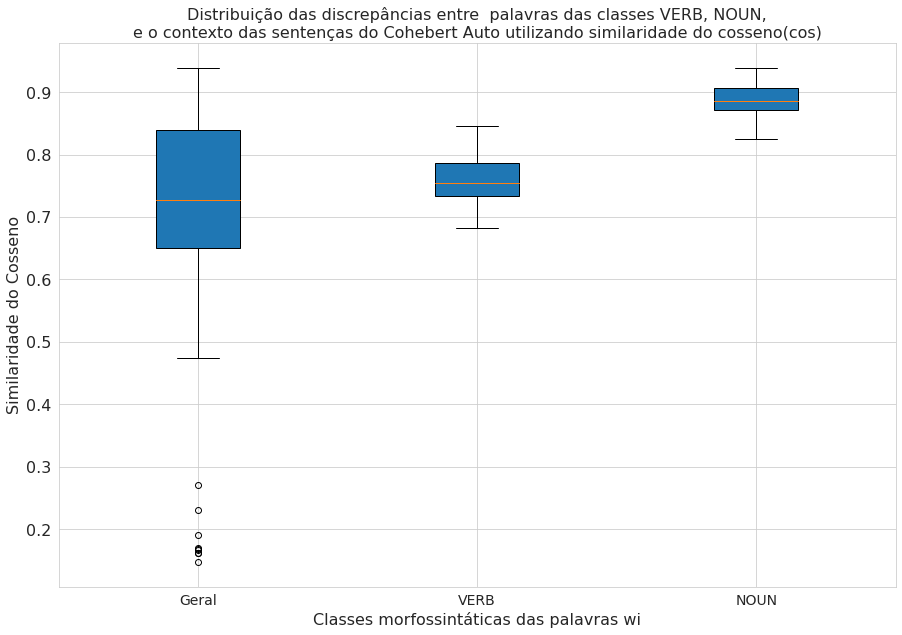

In [655]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Define o tamanho do gráfico 
fig, ax = plt.subplots(figsize =(15, 10))

# Estilo do gráfico
sns.set_style("whitegrid")

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre  palavras das classes VERB, NOUN,\ne o contexto das sentenças do Cohebert Auto utilizando similaridade do cosseno(cos)")
# Texto do eixo x
plt.xlabel("Classes morfossintáticas das palavras wi")
# Texto do eixo y
plt.ylabel("Similaridade do Cosseno")

colunas = [lista_comparacao_contexto[["cos_ctxnoun_mean"]], lista_comparacao_classesVV[["cos_ctxnoun_mean"]], lista_comparacao_classesNN[["cos_ctxnoun_mean"]]]
ax.boxplot(colunas, patch_artist=True)

# Rótulos para os boxplots
plt.xticks([1, 2, 3], ["Geral", "VERB", "NOUN"])

plt.show()

##### EUC

In [656]:
df_all = pd.concat([lista_comparacao_contexto[["euc_ctxnoun_mean"]],
                    lista_comparacao_classesVV[["euc_ctxnoun_mean"]], 
                    lista_comparacao_classesNN[["euc_ctxnoun_mean"]],                    
                    ], 
                    axis="columns", 
                    keys=["Geral", "VERB", "NOUN"])

df_all.describe(include=["float", "int"]) 

Geral             VERB             NOUN
      euc_ctxnoun_mean euc_ctxnoun_mean euc_ctxnoun_mean
count       434.000000        46.000000       108.000000
mean         27.295900        25.604029        19.057229
std           6.326536         3.095116         2.890300
min          14.569006        18.897543        14.569006
25%          21.664404        23.741280        17.207865
50%          28.133000        25.307844        18.936301
75%          31.694495        27.197792        20.135258
max          41.862366        32.435139        34.023926

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


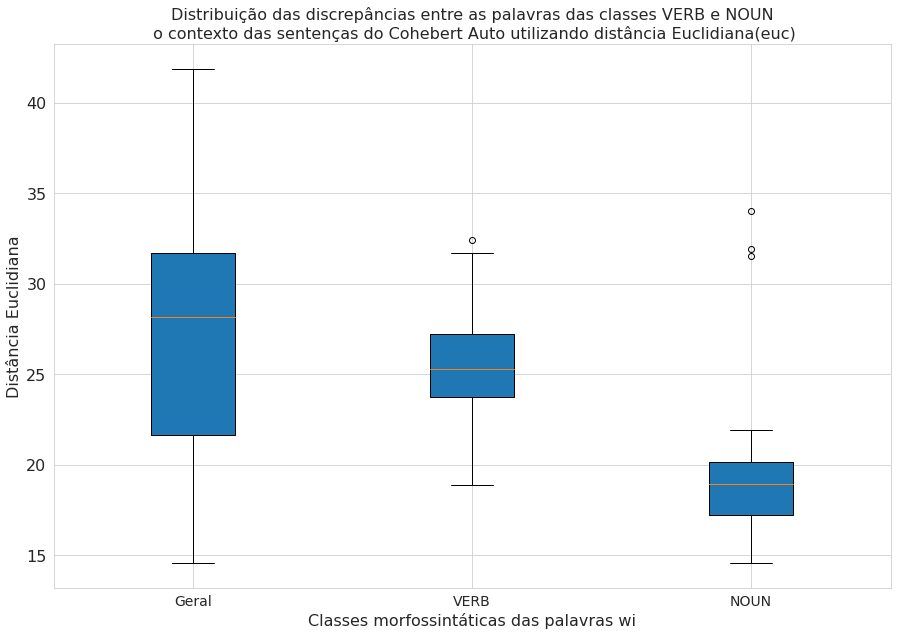

In [657]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Define o tamanho do gráfico 
fig, ax = plt.subplots(figsize =(15, 10))

# Estilo do gráfico
sns.set_style("whitegrid")

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras das classes VERB e NOUN\n o contexto das sentenças do Cohebert Auto utilizando distância Euclidiana(euc)")
# Texto do eixo x
plt.xlabel("Classes morfossintáticas das palavras wi")
# Texto do eixo y
plt.ylabel("Distância Euclidiana")

colunas = [lista_comparacao_contexto[["euc_ctxnoun_mean"]], lista_comparacao_classesVV[["euc_ctxnoun_mean"]], lista_comparacao_classesNN[["euc_ctxnoun_mean"]]]
ax.boxplot(colunas, patch_artist=True)

# Rótulos para os boxplots
plt.xticks([1, 2, 3 ], ["Geral", "VERB", "NOUN"])

plt.show()

##### MAN

In [658]:
df_all = pd.concat([lista_comparacao_contexto[["man_ctxnoun_mean"]],
                    lista_comparacao_classesVV[["man_ctxnoun_mean"]], 
                    lista_comparacao_classesNN[["man_ctxnoun_mean"]],                    
                    ], 
                    axis="columns", 
                    keys=["Geral", "VERB", "NOUN"])

df_all.describe(include=["float", "int"]) 

Geral             VERB             NOUN
      man_ctxnoun_mean man_ctxnoun_mean man_ctxnoun_mean
count       434.000000        46.000000       108.000000
mean       1281.832050      1210.909298       876.930347
std         294.433708       145.352283        98.406364
min         697.053340       897.339970       697.053340
25%        1023.520670      1137.720600       785.963300
50%        1318.147700      1192.478400       880.169000
75%        1507.857500      1279.407575       942.397150
max        1930.248700      1543.213400      1165.996800

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


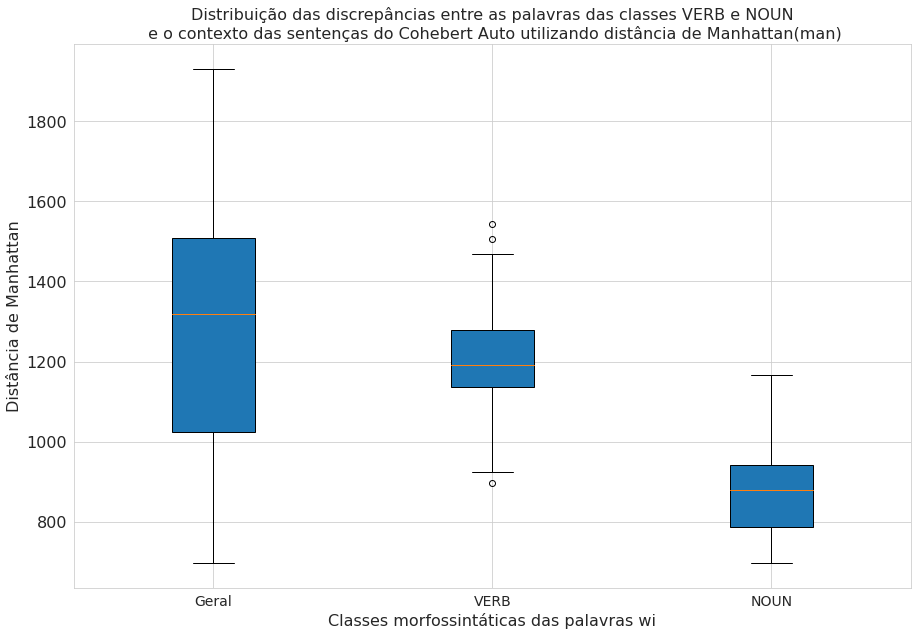

In [659]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Define o tamanho do gráfico 
fig, ax = plt.subplots(figsize =(15, 10))

# Estilo do gráfico
sns.set_style("whitegrid")

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras das classes VERB e NOUN\n e o contexto das sentenças do Cohebert Auto utilizando distância de Manhattan(man)")
# Texto do eixo x
plt.xlabel("Classes morfossintáticas das palavras wi")
# Texto do eixo y
plt.ylabel("Distância de Manhattan")

colunas = [lista_comparacao_contexto[["man_ctxnoun_mean"]], lista_comparacao_classesVV[["man_ctxnoun_mean"]], lista_comparacao_classesNN[["man_ctxnoun_mean"]]]
ax.boxplot(colunas, patch_artist=True)

# Rótulos para os boxplots
plt.xticks([1, 2, 3], ["Geral", "VERB", "NOUN"])

plt.show()

### Contexto com palavras da classe VERB(AUX) e NOUN(ctxverbnoun)

#### VERB

In [660]:
classe_morfosintatica = "VERB"

##### Estatísticas

Filtrar comparação contexto com verbos

In [661]:
lista_comparacao_classes = lista_comparacao_contexto[(lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]

lista_comparacao_classesVV = lista_comparacao_classes

print("Comparações:", len(lista_comparacao_classes))

Comparações: 46


Estatísticas das medidas dos contextos e palavras

In [662]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("precision", 6)

# Exibe as estatísticas
lista_comparacao_classes[["cos_ctxverbnoun_mean","euc_ctxverbnoun_mean","man_ctxverbnoun_mean","cos_ctxverbnoun_max","euc_ctxverbnoun_max","man_ctxverbnoun_max",]].describe(include=["float", "int"]) 

cos_ctxverbnoun_mean  euc_ctxverbnoun_mean  man_ctxverbnoun_mean  \
count             46.000000             46.000000             46.000000   
mean               0.870809             18.200638            869.365683   
std                0.031808              3.079528            144.405540   
min                0.813792             13.450160            655.001040   
25%                0.845761             16.229404            785.531113   
50%                0.871724             17.537029            835.677175   
75%                0.894941             19.923605            947.866625   
max                0.926419             25.065130           1193.968600   

       cos_ctxverbnoun_max  euc_ctxverbnoun_max  man_ctxverbnoun_max  
count            46.000000            46.000000            46.000000  
mean              0.745678            27.412402          1327.436465  
std               0.053294             2.602303           130.476255  
min               0.641902            22.566936          1108.135500  
25%               0.704491            25.498053          1245.445950  
50%               0.746549            26.969605          1312.332300  
75%               0.774696            29.001858          1406.444075  
max               0.858533            33.166889          1659.436400

##### Top 20

Top 20 palavras(wi) em mais ocorrências nas comparações de pos(wi) do tipo VERB

In [663]:
# Import das bibliotecas
import ast
from tqdm.notebook import tqdm as tqdm_notebook
from collections import Counter

# Barra de progresso dos documentos
lista_comparacao_classes_bar = tqdm_notebook(lista_comparacao_classes.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_comparacao_classes))

# Contador das palavras
contador = Counter()

# Percorre as comparações
for i, linha_comparacao in lista_comparacao_classes_bar:  
  #if i < 10:             
    contador[linha_comparacao[3]] += 1

Documentos:   0%|          | 0/46 [00:00<?, ? documento/s]

In [664]:
top = 20
lista = []
# Lista as ocorrências das palavras
for i, item in enumerate(sorted(contador, key = contador.get, reverse=True)):
  if i < top:
    lista.append([i+1, item, contador[item]])      

In [665]:
# Converte em um dataFrame
df1 = pd.DataFrame(lista, columns=("ranque", "palavra", "#wi"))

# Motra o rank
print(df1.to_string(index=False))

 ranque  palavra  #wi
      1        7   16
      2        1   12
      3        6    8
      4        3    4
      5        2    4
      6        8    2


##### COS - MEAN

In [666]:
medida = "cos_ctxverbnoun_mean"

Documentos outliers

In [667]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 0.04917982220649719
Limite superior             : 0.9687103480100632
Limite inferior             : 0.7719910591840744


Encontra os documentos com as maiores similaridades (cos(wi,contexto) > limite_superior)

In [668]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 0 de 46 ( 0.0 )


Encontra os documentos com as maiores discrepâncias (cos(wi,contexto) < limite_inferior)

In [669]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 46 ( 0.0 )


In [670]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  0 de 46 ( 0.0 )


###### Top 5 documentos com as maiores similaridades (cos(wi,ctxverbnoun) > limite_superior) entre palavras da classe VERB e NOUN e o contexto de palavras da classe VERB e NOUN.

In [671]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxverbnoun) < limite_inferior) entre palavras da classe VERB e NOUN e o contexto de palavras da classe VERB e NOUN.

In [672]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxverbnoun) < limite_inferior)  entre palavras da classe VERB e NOUN e o contexto de palavras da classe VERB e NOUN e a lista das palavras em ordem de discrepâncias.

In [673]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1

##### COS - MAX

In [674]:
medida = "cos_ctxverbnoun_max"

Documentos outliers

In [675]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 0.07020460069179535
Limite superior             : 0.8800025209784508
Limite inferior             : 0.5991841182112694


Encontra os documentos com as maiores similaridades (cos(wi,contexto) > limite_superior)

In [676]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 0 de 46 ( 0.0 )


Encontra os documentos com as maiores discrepâncias (cos(wi,contexto) < limite_inferior)

In [677]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 46 ( 0.0 )


In [678]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  0 de 46 ( 0.0 )


###### Top 5 documentos com as maiores similaridades (cos(wi,ctxverbnoun) > limite_superior) entre palavras da classe VERB e NOUN e o contexto de palavras da classe VERB e NOUN.

In [679]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxverbnoun) < limite_inferior) entre palavras da classe VERB e NOUN e o contexto de palavras da classe VERB e NOUN.

In [680]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxverbnoun) < limite_inferior)  entre palavras da classe VERB e NOUN e o contexto de palavras da classe VERB e NOUN e a lista das palavras em ordem de discrepâncias.

In [681]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1

##### EUC - MEAN

In [682]:
medida = "euc_ctxverbnoun_mean"

Documentos outliers

In [683]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 3.6942005157470703
Limite superior             : 25.464905738830566
Limite inferior             : 10.688103675842285


Encontra os documentos com as maiores discrepâncias (euc(wi,contexto) > limite_superior)

In [684]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 0 de 46 ( 0.0 )


Encontra os documentos com as maiores similaridades (euc(wi,contexto) < limite_inferior)

In [685]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 46 ( 0.0 )


In [686]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  0 de 46 ( 0.0 )


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxverbnoun) > limite_superior) entre palavras da classe VERB e NOUN e o contexto de palavras da classe VERB e NOUN.


In [687]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores similaridades (euc(wi,ctxverbnoun) < limite_superior) entre palavras da classe VERB e NOUN e o contexto de palavras da classe VERB e NOUN.


In [688]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxverbnoun) > limite_superior)   entre palavras da classe VERB e NOUN e o contexto de palavras da classe VERB e NOUN e a lista das palavras em ordem de discrepâncias.

In [689]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1

##### EUC - MAX

In [690]:
medida = "euc_ctxverbnoun_max"

Documentos outliers

In [691]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 3.503805160522461
Limite superior             : 34.25756549835205
Limite inferior             : 20.242344856262207


Encontra os documentos com as maiores discrepâncias (euc(wi,contexto) > limite_superior)

In [692]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 0 de 46 ( 0.0 )


Encontra os documentos com as maiores similaridades (euc(wi,contexto) < limite_inferior)

In [693]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 46 ( 0.0 )


In [694]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  0 de 46 ( 0.0 )


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxverbnoun) > limite_superior) entre palavras da classe VERB e NOUN e o contexto de palavras da classe VERB e NOUN.


In [695]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores similaridades (euc(wi,ctxverbnoun) < limite_superior) entre palavras da classe VERB e NOUN e o contexto de palavras da classe VERB e NOUN.


In [696]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxverbnoun) > limite_superior)   entre palavras da classe VERB e NOUN e o contexto de palavras da classe VERB e NOUN e a lista das palavras em ordem de discrepâncias.

In [697]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1

##### MAN - MEAN

In [698]:
medida = "man_ctxverbnoun_mean"

Documentos outliers

In [699]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 162.33551249999994
Limite superior             : 1191.3698937499998
Limite inferior             : 542.0278437500001


Encontra os documentos com as maiores discrepâncias (man(wi,contexto) > limite_superior)

In [700]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 1 de 46 ( 0.021739130434782608 )


Encontra os documentos com as maiores similaridades (man(wi,wj) < limite_inferior)

In [701]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 46 ( 0.0 )


In [702]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  1 de 46 ( 0.021739130434782608 )


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxverbnoun) > limite_superior) entre palavras da classe VERB e NOUN e o contexto de palavras da classe VERB e NOUN.

In [703]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 1193.9686 ocorre
         Em uma pilha a operação de enfileirar ocorre em qual extremidade ?


###### Top 5 documentos com as maiores similaridades (man(wi,ctxverbnoun) < limite_inferior) entre palavras da classe VERB e NOUN e o contexto de palavras da classe VERB e NOUN.

In [704]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxverbnoun) > limite_superior)   entre palavras da classe VERB e NOUN e o contexto de palavras da classe VERB e NOUN e a lista das palavras em ordem de discrepâncias.

In [705]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 Em uma pilha a operação de enfileirar ocorre em qual extremidade ?
       1 1193.9686 ocorre
       2 976.15137 enfileirar


##### MAN - MAX

In [706]:
medida = "man_ctxverbnoun_max"

Documentos outliers

In [707]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 160.99812499999985
Limite superior             : 1647.9412624999995
Limite inferior             : 1003.9487625000003


Encontra os documentos com as maiores discrepâncias (man(wi,contexto) > limite_superior)

In [708]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 1 de 46 ( 0.021739130434782608 )


Encontra os documentos com as maiores similaridades (man(wi,wj) < limite_inferior)

In [709]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 46 ( 0.0 )


In [710]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  1 de 46 ( 0.021739130434782608 )


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxverbnoun) > limite_superior) entre palavras da classe VERB e NOUN e o contexto de palavras da classe VERB e NOUN.

In [711]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 1659.4364 desempilhar
         Como são implementadas as operações de empilhar e desempilhar elementos em uma pilha?


###### Top 5 documentos com as maiores similaridades (man(wi,ctxverbnoun) < limite_inferior) entre palavras da classe VERB e NOUN e o contexto de palavras da classe VERB e NOUN.

In [712]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxverbnoun) > limite_superior)   entre palavras da classe VERB e NOUN e o contexto de palavras da classe VERB e NOUN e a lista das palavras em ordem de discrepâncias.

In [713]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 Como são implementadas as operações de empilhar e desempilhar elementos em uma pilha?
       1 1659.4364 desempilhar
       2 1316.3633 empilhar
       3 1274.8257 implementadas


#### NOUN

In [714]:
classe_morfosintatica = "NOUN"

##### Estatísticas

Filtrar comparação contexto com verbos

In [715]:
lista_comparacao_classes = lista_comparacao_contexto[(lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]

lista_comparacao_classesNN = lista_comparacao_classes

print("Comparações:", len(lista_comparacao_classes))

Comparações: 108


Estatísticas das medidas dos contextos e palavras

In [716]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("precision", 6)

# Exibe as estatísticas
lista_comparacao_classes[["cos_ctxverbnoun_mean","euc_ctxverbnoun_mean","man_ctxverbnoun_mean","cos_ctxverbnoun_max","euc_ctxverbnoun_max","man_ctxverbnoun_max",]].describe(include=["float", "int"]) 

cos_ctxverbnoun_mean  euc_ctxverbnoun_mean  man_ctxverbnoun_mean  \
count            108.000000            108.000000            108.000000   
mean               0.860804             21.145817            977.633517   
std                0.024822              3.379122            118.570648   
min                0.802245             14.569006            697.053340   
25%                0.846128             19.062768            901.420675   
50%                0.860213             20.715960            966.033520   
75%                0.875497             22.599946           1063.882475   
max                0.918863             35.277199           1236.895300   

       cos_ctxverbnoun_max  euc_ctxverbnoun_max  man_ctxverbnoun_max  
count           108.000000           108.000000           108.000000  
mean              0.836471            23.010553          1073.501115  
std               0.047681             3.471957           155.219401  
min               0.671942            16.810907           770.116940  
25%               0.812471            20.582219           941.427000  
50%               0.849512            22.575870          1057.011500  
75%               0.866011            24.666563          1161.485100  
max               0.909825            35.277199          1609.833100

##### Top 20

Top 20 palavras(wi) em mais ocorrências nas comparações de pos(wi) do tipo NOUN e pos(wj) do tipo NOUN

In [717]:
# Import das bibliotecas
import ast
from tqdm.notebook import tqdm as tqdm_notebook
from collections import Counter

# Barra de progresso dos documentos
lista_comparacao_classes_bar = tqdm_notebook(lista_comparacao_classes.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_comparacao_classes))

# Contador das palavras
contador = Counter()

# Percorre as comparações
for i, linha_comparacao in lista_comparacao_classes_bar:  
  #if i < 10:             
    contador[linha_comparacao[3]] += 1

Documentos:   0%|          | 0/108 [00:00<?, ? documento/s]

In [718]:
top = 20
lista = []
# Lista as ocorrências das palavras
for i, item in enumerate(sorted(contador, key = contador.get, reverse=True)):
  if i < top:
    lista.append([i+1, item, contador[item]])      

In [719]:
# Converte em um dataFrame
df1 = pd.DataFrame(lista, columns=("ranque", "palavra", "#wi"))

# Motra o rank
print(df1.to_string(index=False))

 ranque  palavra  #wi
      1        4   28
      2        9   20
      3        2   16
      4        5   12
      5        7   10
      6       10    6
      7        8    4
      8        1    4
      9       11    4
     10       12    4


##### COS - MEAN

In [720]:
medida = "cos_ctxverbnoun_mean"

Documentos outliers

In [721]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 0.029369190335273743
Limite superior             : 0.9195510223507881
Limite inferior             : 0.8020742610096931


Encontra os documentos com as maiores similaridades (cos(wi,contexto) > limite_superior)

In [722]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 0 de 108 ( 0.0 )


Encontra os documentos com as maiores discrepâncias (cos(wi,contexto) < limite_inferior)

In [723]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 108 ( 0.0 )


In [724]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)
print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  0 de 108 ( 0.0 )


###### Top 5 documentos com as maiores similaridades (cos(wi,ctxverbnoun) > limite_superior) entre palavras da classe VERB e NOUN e o contexto de palavras da classe VERB e NOUN.

In [725]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepânciass (cos(wi,ctxverbnoun) < limite_inferior) entre palavras da classe VERB e NOUN e o contexto de palavras da classe VERB e NOUN.


In [726]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias  (cos(wi,ctxverbnoun) < limite_inferior) entre palavras da classe NOUN e o contexto de palavras da classe VERB e NOUN e a lista das palavras em ordem de discrepâncias.

In [727]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1

##### COS - MAX

In [728]:
medida = "cos_ctxverbnoun_max"

Documentos outliers

In [729]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 0.05354002118110657
Limite superior             : 0.9463213682174683
Limite inferior             : 0.732161283493042


Encontra os documentos com as maiores similaridades (cos(wi,contexto) > limite_superior)

In [730]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 0 de 108 ( 0.0 )


Encontra os documentos com as maiores discrepâncias (cos(wi,contexto) < limite_inferior)

In [731]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 4 de 108 ( 0.037037037037037035 )


In [732]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)
print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  4 de 108 ( 0.037037037037037035 )


###### Top 5 documentos com as maiores similaridades (cos(wi,ctxverbnoun) > limite_superior) entre palavras da classe VERB e NOUN e o contexto de palavras da classe VERB e NOUN.

In [733]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepânciass (cos(wi,ctxverbnoun) < limite_inferior) entre palavras da classe VERB e NOUN e o contexto de palavras da classe VERB e NOUN.


In [734]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 0.671942412853241 desempilhar
         O que é uma pilha e como empilhar e desempilhar seus elementos?

 2 0.697194516658783 desempilhar
         O que é uma fila e como empilhar e desempilhar seus elementos ?

 3 0.7006033062934875 desempilhar
         Como desempilhar elementos em uma estrutura de dados pilha?

 4 0.7207643985748291 desempilhar
         O que é uma pilha e como desempilhar um elemento nela?


###### Top 5 documentos com as maiores discrepâncias  (cos(wi,ctxverbnoun) < limite_inferior) entre palavras da classe NOUN e o contexto de palavras da classe VERB e NOUN e a lista das palavras em ordem de discrepâncias.

In [735]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 O que é uma pilha e como desempilhar um elemento nela?
       1 0.8670498728752136 elemento
       2 0.8527915477752686 pilha
       3 0.7207643985748291 desempilhar

 2 Como desempilhar elementos em uma estrutura de dados pilha?
       1 0.875388503074646 elementos
       2 0.8673977851867676 pilha
       3 0.8618021607398987 estrutura
       4 0.8448513150215149 dados
       5 0.7006033062934875 desempilhar

 3 O que é uma fila e como empilhar e desempilhar seus elementos ?
       1 0.823227047920227 elementos
       2 0.7742826342582703 fila
       3 0.697194516658783 desempilhar

 4 O que é uma pilha e como empilhar e desempilhar seus elementos?
       1 0.829513669013977 elementos
       2 0.8226721286773682 pilha
       3 0.671942412853241 desempilhar


##### EUC - MEAN

In [736]:
medida = "euc_ctxverbnoun_mean"

Documentos outliers

In [737]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 3.537178516387943
Limite superior             : 27.905714273452766
Limite inferior             : 13.757000207900992


Encontra os documentos com as maiores discrepâncias (euc(wi,contexto) > limite_superior)

In [738]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior:", len(lista_comparacao_outliers_superior))

Outliers superior: 3


Encontra os documentos com as maiores similaridades (euc(wi,contexto) < limite_inferior)

In [739]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 108 ( 0.0 )


In [740]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)
print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  3 de 108 ( 0.027777777777777776 )


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxverbnoun) > limite_superior) entre palavras da classe NOUN e o contexto de palavras da classe VERB e NOUN.

In [741]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 35.277198791503906 pilha
         Como empilhar e desempilhar elementos em uma estrutura de dados pilha?

 2 34.02392578125 pilha
         Como desempilhar elementos em uma estrutura de dados pilha?

 3 33.557735443115234 pilha
         Como empilhar elementos em uma estrutura de dados pilha?


###### Top 5 documentos com as maiores similaridades (euc(wi,ctxverbnoun) < limite_superior) entre palavras da classe NOUN e o contexto de palavras da classe VERB e NOUN.


In [742]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxverbnoun) > limite_superior)  entre palavras da classe NOUN e o contexto de palavras da classe VERB e NOUN e a lista das palavras em ordem de discrepâncias.

In [743]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 Como empilhar e desempilhar elementos em uma estrutura de dados pilha?
       1 35.277198791503906 pilha
       2 21.13629722595215 dados
       3 20.534181594848636 estrutura
       4 20.212766647338867 elementos

 2 Como desempilhar elementos em uma estrutura de dados pilha?
       1 34.02392578125 pilha
       2 20.68986701965332 dados
       3 19.93473052978516 estrutura
       4 19.830671310424805 desempilhar
       5 18.9652156829834 elementos

 3 Como empilhar elementos em uma estrutura de dados pilha?
       1 33.557735443115234 pilha
       2 20.28210830688477 elementos
       3 20.22356605529785 dados
       4 19.784996032714844 estrutura


##### EUC - MAX

In [744]:
medida = "euc_ctxverbnoun_max"

Documentos outliers

In [745]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 4.084343910217285
Limite superior             : 30.793078899383545
Limite inferior             : 14.455703258514404


Encontra os documentos com as maiores discrepâncias (euc(wi,contexto) > limite_superior)

In [746]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior:", len(lista_comparacao_outliers_superior))

Outliers superior: 4


Encontra os documentos com as maiores similaridades (euc(wi,contexto) < limite_inferior)

In [747]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 108 ( 0.0 )


In [748]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)
print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  4 de 108 ( 0.037037037037037035 )


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxverbnoun) > limite_superior) entre palavras da classe NOUN e o contexto de palavras da classe VERB e NOUN.

In [749]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 35.277198791503906 pilha
         Como empilhar e desempilhar elementos em uma estrutura de dados pilha?

 2 34.02392578125 pilha
         Como desempilhar elementos em uma estrutura de dados pilha?

 3 33.557735443115234 pilha
         Como empilhar elementos em uma estrutura de dados pilha?

 4 31.933061599731445 desempilhar
         O que é uma pilha e como empilhar e desempilhar seus elementos?


###### Top 5 documentos com as maiores similaridades (euc(wi,ctxverbnoun) < limite_superior) entre palavras da classe NOUN e o contexto de palavras da classe VERB e NOUN.


In [750]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxverbnoun) > limite_superior)  entre palavras da classe NOUN e o contexto de palavras da classe VERB e NOUN e a lista das palavras em ordem de discrepâncias.

In [751]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 Como empilhar e desempilhar elementos em uma estrutura de dados pilha?
       1 35.277198791503906 pilha
       2 21.13629722595215 dados
       3 20.534181594848636 estrutura
       4 20.212766647338867 elementos

 2 Como desempilhar elementos em uma estrutura de dados pilha?
       1 34.02392578125 pilha
       2 29.330642700195312 desempilhar
       3 20.68986701965332 dados
       4 19.93473052978516 estrutura
       5 18.9652156829834 elementos

 3 Como empilhar elementos em uma estrutura de dados pilha?
       1 33.557735443115234 pilha
       2 20.28210830688477 elementos
       3 20.22356605529785 dados
       4 19.784996032714844 estrutura

 4 O que é uma pilha e como empilhar e desempilhar seus elementos?
       1 31.933061599731445 desempilhar
       2 22.61772918701172 elementos
       3 22.43887710571289 pilha


##### MAN - MEAN

In [752]:
medida = "man_ctxverbnoun_mean"

Documentos outliers

In [753]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 162.46179999999993
Limite superior             : 1307.5751749999997
Limite inferior             : 657.727975


Encontra os documentos com as maiores discrepâncias (man(wi,contexto) > limite_superior)

In [754]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior:", len(lista_comparacao_outliers_superior))

Outliers superior: 0


Encontra os documentos com as maiores similaridades (man(wi,contexto) < limite_inferior)

In [755]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 108 ( 0.0 )


In [756]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  0 de 108 ( 0.0 )


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxverbnoun) > limite_superior) entre palavras da classe VERB e NOUN e o contexto de palavras da classe VERB e NOUN.

In [757]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores similaridades (man(wi,ctxverbnoun) < limite_superior) entre palavras da classe VERB e NOUN e o contexto de palavras da classe VERB e NOUN.

In [758]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxverbnoun) > limite_superior)  entre palavras da classe NOUN e o contexto de palavras da classe VERB e NOUN e a lista das palavras em ordem de discrepâncias.

In [759]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1

##### MAN - MAX

In [760]:
medida = "man_ctxverbnoun_max"

Documentos outliers

In [761]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 220.05809999999985
Limite superior             : 1491.5722499999997
Limite inferior             : 611.3398500000003


Encontra os documentos com as maiores discrepâncias (man(wi,contexto) > limite_superior)

In [762]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior:", len(lista_comparacao_outliers_superior))

Outliers superior: 3


Encontra os documentos com as maiores similaridades (man(wi,contexto) < limite_inferior)

In [763]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 108 ( 0.0 )


In [764]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  3 de 108 ( 0.027777777777777776 )


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxverbnoun) > limite_superior) entre palavras da classe VERB e NOUN e o contexto de palavras da classe VERB e NOUN.

In [765]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 1609.8331 desempilhar
         O que é uma pilha e como empilhar e desempilhar seus elementos?

 2 1558.0613 desempilhar
         O que é uma fila e como empilhar e desempilhar seus elementos ?

 3 1494.8447 desempilhar
         O que é uma pilha e como desempilhar um elemento nela?


###### Top 5 documentos com as maiores similaridades (man(wi,ctxverbnoun) < limite_superior) entre palavras da classe VERB e NOUN e o contexto de palavras da classe VERB e NOUN.

In [766]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxverbnoun) > limite_superior)  entre palavras da classe NOUN e o contexto de palavras da classe VERB e NOUN e a lista das palavras em ordem de discrepâncias.

In [767]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes = lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 O que é uma pilha e como empilhar e desempilhar seus elementos?
       1 1609.8331 desempilhar
       2 1088.1521 elementos
       3 1015.64404 pilha

 2 O que é uma fila e como empilhar e desempilhar seus elementos ?
       1 1558.0613 desempilhar
       2 1194.6241 fila
       3 1142.4852 elementos

 3 O que é uma pilha e como desempilhar um elemento nela?
       1 1494.8447 desempilhar
       2 1037.2339 elemento
       3 942.5017 pilha


#### Comparando discrepância entre o contexto de palavras VERB e NOUN e palavras de todas as classes, VERB e NOUN.

##### COS, EUC, MAN

In [768]:
df_all = pd.concat([lista_comparacao_contexto[["cos_ctxverbnoun_mean","euc_ctxverbnoun_mean","man_ctxverbnoun_mean","cos_ctxverbnoun_max","euc_ctxverbnoun_max","man_ctxverbnoun_max",]].dropna(),
                    lista_comparacao_classesVV[["cos_ctxverbnoun_mean","euc_ctxverbnoun_mean","man_ctxverbnoun_mean","cos_ctxverbnoun_max","euc_ctxverbnoun_max","man_ctxverbnoun_max",]].dropna(), 
                    lista_comparacao_classesNN[["cos_ctxverbnoun_mean","euc_ctxverbnoun_mean","man_ctxverbnoun_mean","cos_ctxverbnoun_max","euc_ctxverbnoun_max","man_ctxverbnoun_max",]].dropna(),
                    ], 
                    axis="columns", 
                   keys=["Geral", "VERB", "NOUN"])

df_all.describe(include=["float", "int"]) 

Geral                                            \
      cos_ctxverbnoun_mean euc_ctxverbnoun_mean man_ctxverbnoun_mean   
count           434.000000           434.000000           434.000000   
mean              0.776572            24.362522          1158.727311   
std               0.112074             4.538284           206.959266   
min               0.135959            13.450160           655.001040   
25%               0.727206            21.498970          1019.978270   
50%               0.790383            24.612207          1168.372300   
75%               0.849129            27.394274          1339.489400   
max               0.926419            38.309658          1563.725700   

                                                                   \
      cos_ctxverbnoun_max euc_ctxverbnoun_max man_ctxverbnoun_max   
count          434.000000          434.000000          434.000000   
mean             0.754915           25.972212         1239.890828   
std              0.105817            3.690693          170.277563   
min              0.135959           16.810907          770.116940   
25%              0.715690           23.314416         1118.110075   
50%              0.764626           25.974965         1243.392750   
75%              0.818144           28.002842         1358.202000   
max              0.909825           38.309658         1714.956900   

                      VERB                                            \
      cos_ctxverbnoun_mean euc_ctxverbnoun_mean man_ctxverbnoun_mean   
count            46.000000            46.000000            46.000000   
mean              0.870809            18.200638           869.365683   
std               0.031808             3.079528           144.405540   
min               0.813792            13.450160           655.001040   
25%               0.845761            16.229404           785.531113   
50%               0.871724            17.537029           835.677175   
75%               0.894941            19.923605           947.866625   
max               0.926419            25.065130          1193.968600   

                                                                   \
      cos_ctxverbnoun_max euc_ctxverbnoun_max man_ctxverbnoun_max   
count           46.000000           46.000000           46.000000   
mean             0.745678           27.412402         1327.436465   
std              0.053294            2.602303          130.476255   
min              0.641902           22.566936         1108.135500   
25%              0.704491           25.498053         1245.445950   
50%              0.746549           26.969605         1312.332300   
75%              0.774696           29.001858         1406.444075   
max              0.858533           33.166889         1659.436400   

                      NOUN                                            \
      cos_ctxverbnoun_mean euc_ctxverbnoun_mean man_ctxverbnoun_mean   
count           108.000000           108.000000           108.000000   
mean              0.860804            21.145817           977.633517   
std               0.024822             3.379122           118.570648   
min               0.802245            14.569006           697.053340   
25%               0.846128            19.062768           901.420675   
50%               0.860213            20.715960           966.033520   
75%               0.875497            22.599946          1063.882475   
max               0.918863            35.277199          1236.895300   

                                                                   
      cos_ctxverbnoun_max euc_ctxverbnoun_max man_ctxverbnoun_max  
count          108.000000          108.000000          108.000000  
mean             0.836471           23.010553         1073.501115  
std              0.047681            3.471957          155.219401  
min              0.671942           16.810907          770.116940  
25%              0.812471           20.582219          941.427000  


##### COS

In [769]:
df_all = pd.concat([lista_comparacao_contexto[["cos_ctxverbnoun_mean"]].dropna(),                    
                    lista_comparacao_classesVV[["cos_ctxverbnoun_mean"]].dropna(), 
                    lista_comparacao_classesNN[["cos_ctxverbnoun_mean"]].dropna(),
                    ], 
                    axis="columns", 
                    keys=["Geral", "VERB", "NOUN"])

df_all.describe(include=["float", "int"]) 

Geral                 VERB                 NOUN
      cos_ctxverbnoun_mean cos_ctxverbnoun_mean cos_ctxverbnoun_mean
count           434.000000            46.000000           108.000000
mean              0.776572             0.870809             0.860804
std               0.112074             0.031808             0.024822
min               0.135959             0.813792             0.802245
25%               0.727206             0.845761             0.846128
50%               0.790383             0.871724             0.860213
75%               0.849129             0.894941             0.875497
max               0.926419             0.926419             0.918863

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


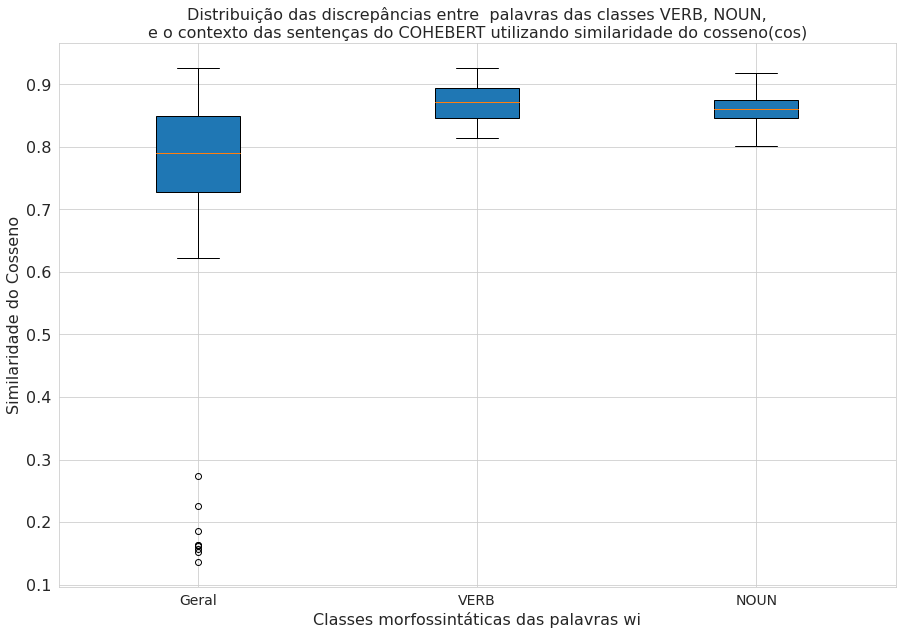

In [770]:
# Import das bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Define o tamanho do gráfico 
fig, ax = plt.subplots(figsize =(15, 10))

# Estilo do gráfico
sns.set_style("whitegrid")

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre  palavras das classes VERB, NOUN,\ne o contexto das sentenças do COHEBERT utilizando similaridade do cosseno(cos)")
# Texto do eixo x
plt.xlabel("Classes morfossintáticas das palavras wi")
# Texto do eixo y
plt.ylabel("Similaridade do Cosseno")

colunas = [lista_comparacao_contexto[["cos_ctxverbnoun_mean"]].dropna(), 
           lista_comparacao_classesVV[["cos_ctxverbnoun_mean"]].dropna(), 
           lista_comparacao_classesNN[["cos_ctxverbnoun_mean"]].dropna()]

ax.boxplot(colunas, patch_artist=True)

# Rótulos para os boxplots
plt.xticks([1, 2, 3], ["Geral", "VERB", "NOUN"])

plt.show()

##### EUC

In [771]:
df_all = pd.concat([lista_comparacao_contexto[["euc_ctxverbnoun_mean"]].dropna(),
                    lista_comparacao_classesVV[["euc_ctxverbnoun_mean"]].dropna(), 
                    lista_comparacao_classesNN[["euc_ctxverbnoun_mean"]].dropna(),                    
                    ], 
                    axis="columns", 
                    keys=["Geral", "VERB", "NOUN"])

df_all.describe(include=["float", "int"]) 

Geral                 VERB                 NOUN
      euc_ctxverbnoun_mean euc_ctxverbnoun_mean euc_ctxverbnoun_mean
count           434.000000            46.000000           108.000000
mean             24.362522            18.200638            21.145817
std               4.538284             3.079528             3.379122
min              13.450160            13.450160            14.569006
25%              21.498970            16.229404            19.062768
50%              24.612207            17.537029            20.715960
75%              27.394274            19.923605            22.599946
max              38.309658            25.065130            35.277199

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


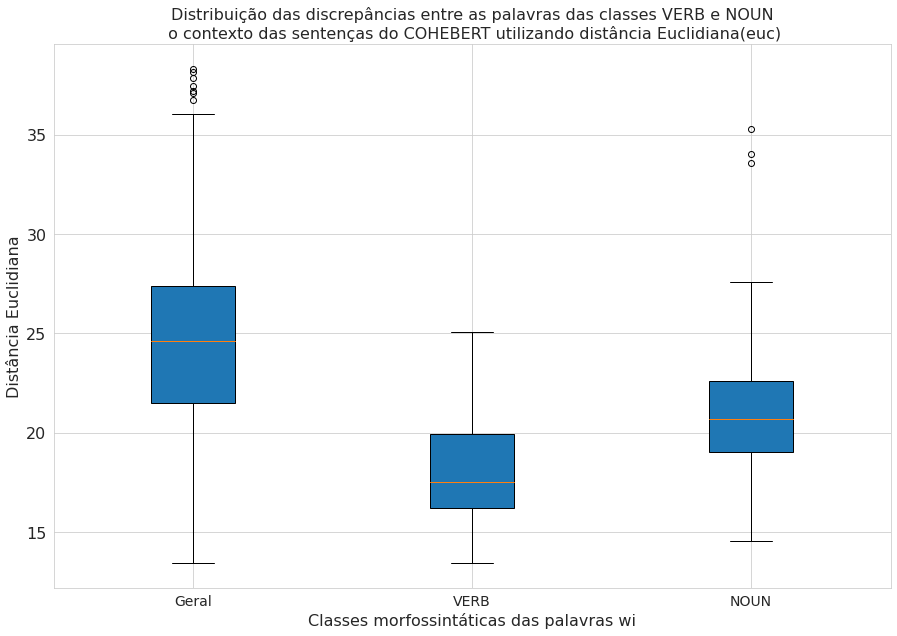

In [772]:
# Import das bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Define o tamanho do gráfico 
fig, ax = plt.subplots(figsize =(15, 10))

# Estilo do gráfico
sns.set_style("whitegrid")

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras das classes VERB e NOUN\n o contexto das sentenças do COHEBERT utilizando distância Euclidiana(euc)")
# Texto do eixo x
plt.xlabel("Classes morfossintáticas das palavras wi")
# Texto do eixo y
plt.ylabel("Distância Euclidiana")

colunas = [lista_comparacao_contexto[["euc_ctxverbnoun_mean"]].dropna(), 
           lista_comparacao_classesVV[["euc_ctxverbnoun_mean"]].dropna(), 
           lista_comparacao_classesNN[["euc_ctxverbnoun_mean"]].dropna()]
ax.boxplot(colunas, patch_artist=True)

# Rótulos para os boxplots
plt.xticks([1, 2, 3 ], ["Geral", "VERB", "NOUN"])

plt.show()

##### MAN

In [773]:
df_all = pd.concat([lista_comparacao_contexto[["man_ctxverbnoun_mean"]].dropna(),
                    lista_comparacao_classesVV[["man_ctxverbnoun_mean"]].dropna(), 
                    lista_comparacao_classesNN[["man_ctxverbnoun_mean"]].dropna(),                    
                    ], 
                    axis="columns", 
                    keys=["Geral", "VERB", "NOUN"])

df_all.describe(include=["float", "int"]) 

Geral                 VERB                 NOUN
      man_ctxverbnoun_mean man_ctxverbnoun_mean man_ctxverbnoun_mean
count           434.000000            46.000000           108.000000
mean           1158.727311           869.365683           977.633517
std             206.959266           144.405540           118.570648
min             655.001040           655.001040           697.053340
25%            1019.978270           785.531113           901.420675
50%            1168.372300           835.677175           966.033520
75%            1339.489400           947.866625          1063.882475
max            1563.725700          1193.968600          1236.895300

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


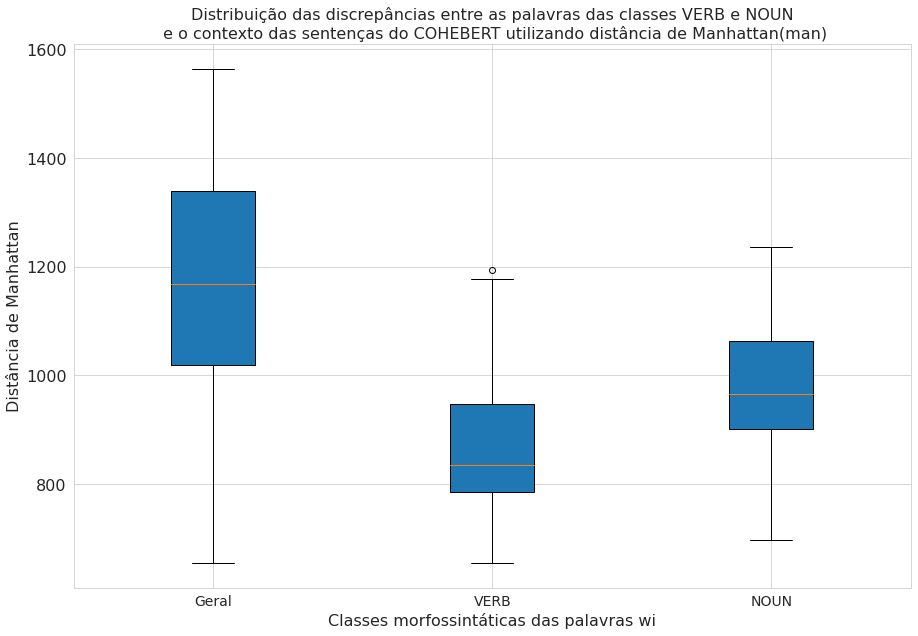

In [774]:
# Import das bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Define o tamanho do gráfico 
fig, ax = plt.subplots(figsize =(15, 10))

# Estilo do gráfico
sns.set_style("whitegrid")

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras das classes VERB e NOUN\n e o contexto das sentenças do COHEBERT utilizando distância de Manhattan(man)")
# Texto do eixo x
plt.xlabel("Classes morfossintáticas das palavras wi")
# Texto do eixo y
plt.ylabel("Distância de Manhattan")

colunas = [lista_comparacao_contexto[["man_ctxverbnoun_mean"]].dropna(), 
           lista_comparacao_classesVV[["man_ctxverbnoun_mean"]].dropna(), 
           lista_comparacao_classesNN[["man_ctxverbnoun_mean"]].dropna()]
ax.boxplot(colunas, patch_artist=True)

# Rótulos para os boxplots
plt.xticks([1, 2, 3], ["Geral", "VERB", "NOUN"])

plt.show()

## 3.6 Ocorrências palavras e contexto

### Indexa os dados das comparações pelo id do documento

In [775]:
# Expecifica o(s) campo(s) indexado(s) e faz uma cópia da lista indexada
lista_comparacao_contexto_indexado = lista_comparacao_contexto.set_index(["id"])
lista_comparacao_contexto_indexado.head()

index_documento  index_sentenca  index_wi          wi  pos_i  \
id                                                                 
1                 0               0         0        Como  SCONJ   
1                 0               0         1  enfileirar   VERB   
1                 0               0         2   elementos   NOUN   
1                 0               0         3          em    ADP   
1                 0               0         4         uma    DET   

    cos_ctxall_mean  euc_ctxall_mean  man_ctxall_mean  cos_ctxclean_mean  \
id                                                                         
1          0.828282        21.519108      1075.545000           0.795338   
1          0.957184        10.615781       524.864750           0.923698   
1          0.803867        26.599089      1214.868700           0.868563   
1          0.871055        20.539906       985.528100           0.828741   
1          0.840564        20.068256       958.674870           0.787430   

    euc_ctxclean_mean  ...  man_ctxclean_max  cos_ctxverb_max  \
id                     ...                                      
1           23.453634  ...       1157.058100         0.759586   
1           13.929336  ...       1131.780300         0.888775   
1           22.597616  ...       1028.900600         0.740469   
1           23.203224  ...       1111.173300         0.796027   
1           23.178740  ...       1096.644800         0.744569   

    euc_ctxverb_max  man_ctxverb_max  cos_ctxnoun_max  euc_ctxnoun_max  \
id                                                                       
1         25.941952      1294.481323         0.680192        29.916761   
1         18.006966       972.863525         0.740781        27.314680   
1         30.121443      1415.033447         0.927326        17.372259   
1         25.312115      1248.880005         0.801385        24.997398   
1         26.130171      1257.120117         0.727426        27.010202   

    man_ctxnoun_max  cos_ctxverbnoun_max  euc_ctxverbnoun_max  \
id                                                              
1       1453.618900             0.733323            26.951654   
1       1333.597400             0.819909            22.602352   
1        782.108400             0.897772            20.224216   
1       1188.405400             0.829802            23.141649   
1       1257.071300             0.760827            24.886763   

    man_ctxverbnoun_max  
id                       
1           1323.588600  
1           1117.259800  
1            922.564500  
1           1105.196000  
1           1168.039800  

[5 rows x 35 columns]

### 3.6.1 Similaridade coseno

#### 3.6.1.1 Organiza as comparações das palavras antes e depois da palavra chave

In [776]:
# Import das bibliotecas.
from tqdm.notebook import tqdm as tqdm_notebook

# Medida
# Para usar outras medidas altere aqui
medida = 'cos' # medidas = {cos, euc, man}

# Estratégia medida
estrategia_medida = 'mean' # medidas = {mean, max}

# Equação medida
equacao_medida = "ctxall" # equação medida = {ctxall, ctxclean, ctxverb, ctxnoun, ctxverbnoun}

# Coluna da medida
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

# Constrói uma lista com as palavras próximas
lista_proximidade = []

# conta comparações
conta = 0

soma_medida = 0

# Barra de progresso dos documentos
lista_documentos_agrupados_bar = tqdm_notebook(lista_documentos_agrupados.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_documentos_agrupados))

# Percorre os documentos
for i, linha1 in lista_documentos_agrupados_bar:  

  # if i < 5:

    # Lista para as comparações
    lista_proximidade_documento = []

    # Localiza as comparações do documento
    lista_comp = lista_comparacao_contexto_indexado.loc[linha1['id']]
    
    # Percorre as comparações do documento
    for i, linha in lista_comp.iterrows():
      
          # Conta o número de comparações
          conta = conta + 1
            
          # Acumula medida
          soma_medida = soma_medida +  linha[coluna_equacao]

          # Guarda os dados da comparação          
          lista_proximidade_documento.append([linha['wi'],          # 0
                                                    linha['pos_i'],       # 1
                                                    linha[coluna_equacao],# 2
                                                    ])
    
    # Guarda as comparações do documento
    lista_proximidade.append([linha1['id'], lista_proximidade_documento])

print("Número de comparações :", conta)
media = soma_medida / conta
print("Média medida", coluna_equacao, " : ", media)

Documentos:   0%|          | 0/40 [00:00<?, ? documento/s]

Número de comparações : 434
Média medida cos_ctxall_mean  :  0.8090358638475018


#### 3.6.1.2 Seleciona comparações entre palavras onde a similaridade do coseno é maior que um determinado threshold

In [777]:
# Import das bibliotecas.
from tqdm.notebook import tqdm as tqdm_notebook

# Limite da medida
threshold = 0.5

# Dicionário para guardar as ocorrências de comparações
frequencia_ocorrencia_palavra = {}

# Barra de progresso das proximidades
lista_proximidade_bar = tqdm_notebook(enumerate(lista_proximidade), desc=f"Comparações", unit=f" comparação", total=len(lista_proximidade))

# Percorre a lista de comparações com a chave
for i, linha1 in lista_proximidade_bar:
  # if i < 5:

    # Verifica se existe comparações 
    if len(linha1[1]) != 0:

      # Percorre as comparações 
      for j, linha2 in enumerate(linha1[1]):
          
        # Compara a medida se está acima do Threshold
        if linha2[2] >= threshold:

            # Monta a chave do dicionário
            chave = linha2[0] + "(" + linha2[1] + ") "

            # Recupera a chave para atualizar o valor
            if chave in frequencia_ocorrencia_palavra:
              valor = frequencia_ocorrencia_palavra.get(chave)
              frequencia_ocorrencia_palavra.update({chave: valor + 1})
            
            else:
              # Atualiza a chave com valor 1 se não existir
              frequencia_ocorrencia_palavra.update({chave: 1})

Comparações:   0%|          | 0/40 [00:00<?, ? comparação/s]

#### 3.6.1.3 Lista as 20 maiores ocorrências de palavras com similaridade acima do threshold com o contexto

In [778]:
top = 20

print("Lista ordenada das ", top, " maiores ocorrências ordenadas de palavras comparadas com o contexto")
print("usando medida", medida ,",estratégia", estrategia_medida, "e equação", equacao_medida,"acima do threshold com o contexto")

# Lista as ocorrências das palavras
for i, item in enumerate(sorted(frequencia_ocorrencia_palavra, key = frequencia_ocorrencia_palavra.get, reverse=True)):
  if i < top:
    print (i+1, item, frequencia_ocorrencia_palavra[item])

Lista ordenada das  20  maiores ocorrências ordenadas de palavras comparadas com o contexto
usando medida cos ,estratégia mean e equação ctxall acima do threshold com o contexto
1 uma(DET)  40
2 ?(PUNCT)  40
3 elementos(NOUN)  24
4 em(ADP)  24
5 fila(NOUN)  20
6 pilha(NOUN)  20
7 e(CCONJ)  19
8 empilhar(VERB)  18
9 O(PRON)  16
10 que(PRON)  16
11 é(AUX)  16
12 como(ADV)  13
13 Como(SCONJ)  12
14 enfileirar(VERB)  12
15 elemento(NOUN)  12
16 desempilhar(NOUN)  8
17 um(DET)  8
18 nela(PRON)  8
19 de(SCONJ)  8
20 desempilhar(VERB)  6


### 3.6.2 Distância Euclidiana

#### 3.6.2.1 Organiza as comparações das palavras antes e depois da palavra chave

In [779]:
# Import das bibliotecas.
from tqdm.notebook import tqdm as tqdm_notebook

# Medida
# Para usar outras medidas altere aqui
medida = 'euc' # medidas = {cos, euc, man}

# Estratégia medida
estrategia_medida = 'mean' # medidas = {mean, max}

# Equação medida
equacao_medida = "ctxall" # equação medida = {ctxall, ctxclean, ctxverb, ctxnoun, ctxverbnoun}

# Coluna da medida
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

# Constrói uma lista com as palavras próximas
lista_proximidade = []

# conta comparações
conta = 0

soma_medida = 0

# Barra de progresso dos documentos
lista_documentos_agrupados_bar = tqdm_notebook(lista_documentos_agrupados.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_documentos_agrupados))

# Percorre os documentos
for i, linha1 in lista_documentos_agrupados_bar:  

  # if i < 5:

    # Lista para as comparações
    lista_proximidade_documento = []

    # Localiza as comparações do documento
    lista_comp = lista_comparacao_contexto_indexado.loc[linha1['id']]
    
    # Percorre as comparações do documento
    for i, linha in lista_comp.iterrows():
      
          # Conta o número de comparações
          conta = conta + 1
            
          # Acumula medida
          soma_medida = soma_medida +  linha[coluna_equacao]

          # Guarda os dados da comparação          
          lista_proximidade_documento.append([linha['wi'],          # 0
                                                    linha['pos_i'],       # 1
                                                    linha[coluna_equacao],# 2
                                                    ])
    
    # Guarda as comparações do documento
    lista_proximidade.append([linha1['id'], lista_proximidade_documento])

print("Número de comparações :", conta)
media = soma_medida / conta
print("Média medida", coluna_equacao, " : ", media)

Documentos:   0%|          | 0/40 [00:00<?, ? documento/s]

Número de comparações : 434
Média medida euc_ctxall_mean  :  22.54536717058876


#### 3.6.2.2 Seleciona comparações entre palavras onde a similaridade do coseno é maior que um determinado threshold

In [780]:
# Import das bibliotecas.
from tqdm.notebook import tqdm as tqdm_notebook

# Limite da medida
threshold = 0.5

# Dicionário para guardar as ocorrências de comparações
frequencia_ocorrencia_palavra = {}

# Barra de progresso das proximidades
lista_proximidade_bar = tqdm_notebook(enumerate(lista_proximidade), desc=f"Comparações", unit=f" comparação", total=len(lista_proximidade))

# Percorre a lista de comparações com a chave
for i, linha1 in lista_proximidade_bar:
  # if i < 5:

    # Verifica se existe comparações
    if len(linha1[1]) != 0:

      # Percorre as comparações
      for j, linha2 in enumerate(linha1[1]):
          
        # Compara a medida se está acima do Threshold
        if linha2[2] >= threshold:

            # Monta a chave do dicionário
            chave = linha2[0] + "(" + linha2[1] + ") "

            # Recupera a chave para atualizar o valor
            if chave in frequencia_ocorrencia_palavra:
              valor = frequencia_ocorrencia_palavra.get(chave)
              frequencia_ocorrencia_palavra.update({chave: valor + 1})
            
            else:
              # Atualiza a chave com valor 1 se não existir
              frequencia_ocorrencia_palavra.update({chave: 1})

Comparações:   0%|          | 0/40 [00:00<?, ? comparação/s]

#### 3.6.2.3 Lista as 20 maiores ocorrências de palavras com similaridade acima do threshold com o contexto

In [781]:
top = 20

print("Lista ordenada das ", top, " maiores ocorrências ordenadas de palavras comparadas com o contexto")
print("usando medida", medida ,",estratégia", estrategia_medida, "e equação", equacao_medida,"acima do threshold com o contexto")

# Lista as ocorrências das palavras
for i, item in enumerate(sorted(frequencia_ocorrencia_palavra, key = frequencia_ocorrencia_palavra.get, reverse=True)):
  if i < top:
    print (i+1, item, frequencia_ocorrencia_palavra[item])

Lista ordenada das  20  maiores ocorrências ordenadas de palavras comparadas com o contexto
usando medida euc ,estratégia mean e equação ctxall acima do threshold com o contexto
1 uma(DET)  40
2 ?(PUNCT)  40
3 e(CCONJ)  28
4 elementos(NOUN)  24
5 em(ADP)  24
6 fila(NOUN)  20
7 pilha(NOUN)  20
8 empilhar(VERB)  18
9 O(PRON)  16
10 que(PRON)  16
11 é(AUX)  16
12 como(ADV)  13
13 Como(SCONJ)  12
14 enfileirar(VERB)  12
15 elemento(NOUN)  12
16 desempilhar(NOUN)  8
17 um(DET)  8
18 nela(PRON)  8
19 de(SCONJ)  8
20 desempilhar(VERB)  6


### 3.6.3 Distância de Manhattan

#### 3.6.3.1 Organiza as comparações das palavras antes e depois da palavra chave

In [782]:
# Import das bibliotecas.
from tqdm.notebook import tqdm as tqdm_notebook

# Medida
# Para usar outras medidas altere aqui
medida = 'man' # medidas = {cos, euc, man}

# Estratégia medida
estrategia_medida = 'mean' # medidas = {mean, max}

# Equação medida
equacao_medida = "ctxall" # equação medida = {ctxall, ctxclean, ctxverb, ctxnoun, ctxverbnoun}

# Coluna da medida
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

# Constrói uma lista com as palavras próximas
lista_proximidade = []

# conta comparações
conta = 0

soma_medida = 0

# Barra de progresso dos documentos
lista_documentos_agrupados_bar = tqdm_notebook(lista_documentos_agrupados.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_documentos_agrupados))

# Percorre os documentos
for i, linha1 in lista_documentos_agrupados_bar:  

  # if i < 5:

    # Lista para as comparações
    lista_proximidade_documento = []

    # Localiza as comparações do documento
    lista_comp = lista_comparacao_contexto_indexado.loc[linha1['id']]
    
    # Percorre as comparações do documento
    for i, linha in lista_comp.iterrows():
      
          # Conta o número de comparações
          conta = conta + 1
            
          # Acumula medida
          soma_medida = soma_medida +  linha[coluna_equacao]

          # Guarda os dados da comparação          
          lista_proximidade_documento.append([linha['wi'],          # 0
                                                    linha['pos_i'],       # 1
                                                    linha[coluna_equacao],# 2
                                                    ])
    
    # Guarda as comparações do documento
    lista_proximidade.append([linha1['id'], lista_proximidade_documento])

print("Número de comparações :", conta)
media = soma_medida / conta
print("Média medida", coluna_equacao, " : ", media)

Documentos:   0%|          | 0/40 [00:00<?, ? documento/s]

Número de comparações : 434
Média medida man_ctxall_mean  :  1079.1845338940082


#### 3.6.3.2 Seleciona comparações entre palavras onde a similaridade do coseno é maior que um determinado threshold

In [783]:
# Import das bibliotecas.
from tqdm.notebook import tqdm as tqdm_notebook

# Limite da medida
threshold = 0.5

# Dicionário para guardar as ocorrências de comparações
frequencia_ocorrencia_palavra = {}

# Barra de progresso das proximidades
lista_proximidade_bar = tqdm_notebook(enumerate(lista_proximidade), desc=f"Comparações", unit=f" comparação", total=len(lista_proximidade))

# Percorre a lista de comparações com a chave
for i, linha1 in lista_proximidade_bar:
  # if i < 5:

    # Verifica se existe comparações
    if len(linha1[1]) != 0:

      # Percorre as comparações
      for j, linha2 in enumerate(linha1[1]):
          
        # Compara a medida se está acima do Threshold
        if linha2[2] >= threshold:

            # Monta a chave do dicionário
            chave = linha2[0] + "(" + linha2[1] + ") "

            # Recupera a chave para atualizar o valor
            if chave in frequencia_ocorrencia_palavra:
              valor = frequencia_ocorrencia_palavra.get(chave)
              frequencia_ocorrencia_palavra.update({chave: valor + 1})
            
            else:
              # Atualiza a chave com valor 1 se não existir
              frequencia_ocorrencia_palavra.update({chave: 1})

Comparações:   0%|          | 0/40 [00:00<?, ? comparação/s]

#### 3.6.3.3 Lista as 20 maiores ocorrências de palavras com similaridade acima do threshold com o contexto

In [784]:
top = 20

print("Lista ordenada das ", top, " maiores ocorrências ordenadas de palavras comparadas com o contexto")
print("usando medida", medida ,",estratégia", estrategia_medida, "e equação", equacao_medida,"acima do threshold com o contexto")

# Lista as ocorrências das palavras
for i, item in enumerate(sorted(frequencia_ocorrencia_palavra, key = frequencia_ocorrencia_palavra.get, reverse=True)):
  if i < top:
    print (i+1, item, frequencia_ocorrencia_palavra[item])

Lista ordenada das  20  maiores ocorrências ordenadas de palavras comparadas com o contexto
usando medida man ,estratégia mean e equação ctxall acima do threshold com o contexto
1 uma(DET)  40
2 ?(PUNCT)  40
3 e(CCONJ)  28
4 elementos(NOUN)  24
5 em(ADP)  24
6 fila(NOUN)  20
7 pilha(NOUN)  20
8 empilhar(VERB)  18
9 O(PRON)  16
10 que(PRON)  16
11 é(AUX)  16
12 como(ADV)  13
13 Como(SCONJ)  12
14 enfileirar(VERB)  12
15 elemento(NOUN)  12
16 desempilhar(NOUN)  8
17 um(DET)  8
18 nela(PRON)  8
19 de(SCONJ)  8
20 desempilhar(VERB)  6


# 4 Finalização

## 4.1 Tempo final de processamento



In [785]:
# Pega o tempo atual menos o tempo do início do processamento.
final_processamento = time.time()
tempo_total_processamento = formataTempo(final_processamento - inicio_processamento)

print("")
print("  Tempo processamento:  {:} (h:mm:ss)".format(tempo_total_processamento))


  Tempo processamento:  0:01:55 (h:mm:ss)
